# Coursework 1: Chest X-ray

We will analyze the dataset, and train deep learning models to classify whether an x-ray exhibits pneumonia.


In [ ]:
!pip install kaggle
!pip install wandb

In [ ]:
import os
import random
import shutil
os.environ["KAGGLE_USERNAME"] = "enternamehere"
os.environ["KAGGLE_KEY"] = "enterkeyhere"
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, f1_score

import pandas as pd
import seaborn as sns

import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import models, transforms
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
from tqdm import tqdm
import wandb
wandb.login(key="enterkeyhere")

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and Re-split the Raw Data

The original data is poorly split, so we will resplit it here. Do NOT edit this code.

In [ ]:
# Hyperparameters
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1  # This is implicitly defined as 1 - (TRAIN_SPLIT + VAL_SPLIT)

In [ ]:
# Set up the Kaggle API
api = KaggleApi()
api.authenticate()

# Specify the dataset
dataset = "paultimothymooney/chest-xray-pneumonia"

# Specify the download path
download_path = "chest_xray_dataset"

# Check if the dataset is already downloaded
if os.path.exists(os.path.join(download_path, "chest_xray")):
    print(f"Dataset already exists at {download_path}. Skipping download.")
else:
    # Create the download directory if it doesn't exist
    os.makedirs(download_path, exist_ok=True)

    # Download the dataset
    print(f"Downloading {dataset} to {download_path}")
    api.dataset_download_files(dataset, path=download_path, unzip=True)
    print("Download complete!")

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
Download complete!


In [ ]:
# Re-split data
dataset_path = os.path.join(download_path, "chest_xray")
new_dataset_path = "chest_xray_dataset_new_split"
train_files = []
val_files = []
test_files = []

if not os.path.exists(new_dataset_path):
    # Create new directory structure
    for split in ['train', 'val', 'test']:
        for cls in ['NORMAL', 'PNEUMONIA']:
            os.makedirs(os.path.join(new_dataset_path, split, cls), exist_ok=True)

    for cls in ['NORMAL', 'PNEUMONIA']:
        all_files = []
        for split in ['train', 'val', 'test']:
            source_folder = os.path.join(dataset_path, split, cls)
            files = os.listdir(source_folder)
            all_files.extend([(file, source_folder) for file in files])

        # Sort files to ensure consistent order before shuffling
        all_files.sort()

        # Create a new Random object with the seed
        rng = random.Random(42)

        # Use the shuffle method of the Random object
        rng.shuffle(all_files)

        total_files = len(all_files)
        train_end = int(total_files * TRAIN_SPLIT)
        val_end = int(total_files * (TRAIN_SPLIT + VAL_SPLIT))

        train_files = all_files[:train_end]
        val_files = all_files[train_end:val_end]
        test_files = all_files[val_end:]

        for split, file_list in [('train', train_files), ('val', val_files), ('test', test_files)]:
            for file, source_folder in file_list:
                source = os.path.join(source_folder, file)
                dest = os.path.join(new_dataset_path, split, cls, file)
                shutil.copy(source, dest)

    print(f"Data re-split complete. New dataset location: {new_dataset_path}")
else:
    print(f"Re-split dataset already exists at {new_dataset_path}")

Data re-split complete. New dataset location: chest_xray_dataset_new_split


In [ ]:
def dataset_stats(training_data, validation_data, testing_data, datasetpath):
  """
  1. Visualizes distribution of training, validation and testing data
  2. Gives information on the data types of our data
  """
  #default code, given --
  splits = ['train', 'val', 'test']
  classes = ['NORMAL', 'PNEUMONIA']

  total_file_count = 0

  stats = {split: {cls: 0 for cls in ['NORMAL', 'PNEUMONIA']} for split in ['train', 'val', 'test']}
  for split in splits:
      for cls in classes:
          path = os.path.join(datasetpath, split, cls)
          stats[split][cls] = len(os.listdir(path))
          total_file_count += len(os.listdir(path))
  #end of given code --

  #information on datatypes of our data
  print(f"Total number of x-rays in data set: {total_file_count}")
  print(stats)
  print(f"Each sample is a {type(training_data[0])} of length {len(training_data[0])}")
  print(f"The first tuple consists of: {type(training_data[0][0])} and {type(training_data[0][1])}")
  print(f"And the first tuple looks like this: {training_data[0]}")

  #plot the dataset distribution
  stats_df = pd.DataFrame(stats)
  stats_df = stats_df.transpose() #change columns (train,val,test) to rows (normal,pneumonia) and vice versa for better visualisation

  ax = stats_df.plot(kind='bar', figsize=(10, 6), color=['red', 'blue'])
  plt.title("Dataset distribution")
  plt.xlabel("Data Split")
  plt.ylabel("Number of X-Rays")
  plt.xticks(rotation=0)
  plt.legend(title="Class")
  plt.show()

In [ ]:
def image_analysis(training_data, validation_data, testing_data, datasetpath):
  """
  1. Visualizes 10 x-ray images, 5 per class - to visualize our labeled data
  2. Shows the number of different image modes (L, RGB)
  3. Shows the distribution of image sizes
  """
  label_list = ['NORMAL', 'PNEUMONIA'] #two classes existing in dataset
  fig = plt.figure(figsize=(15,5))
  img_mode = Counter()
  widths, heights = [], []
  subplot_idx = 1

  for label in label_list:
    folder_path = os.path.join(datasetpath, "train", label)

    img_file_show = os.listdir(folder_path)[:5] #for showing 5 images in each class
    img_file_distr = os.listdir(folder_path) #for distribution of data

    #show 10 images
    for index, img_file in enumerate(img_file_show):
      image_path = os.path.join(folder_path, img_file)
      image = Image.open(image_path)

      ax = fig.add_subplot(2, 5, subplot_idx, xticks=[], yticks=[])
      subplot_idx += 1
      ax.imshow(image, cmap="gray")
      ax.set_title(label)

    #distributions of the whole dataset
    for index, img_file in enumerate(img_file_distr):
      image_path = os.path.join(folder_path, img_file)
      image = Image.open(image_path)

      #for mode counter
      img_mode[image.mode] += 1

      #for size distribution
      width, height = image.size
      widths.append(width)
      heights.append(height)

  fig.tight_layout()
  plt.show()

  print("Image Mode Counts:")
  for mode, count in img_mode.items():
    print(f"{mode}: {count}")

  fig, axes = plt.subplots(1, 2, figsize=(15, 5))

  sns.histplot(widths, bins=30, ax=axes[0], color='blue')
  axes[0].set_title("Image Width Distribution")
  axes[0].set_xlabel("Width")

  sns.histplot(heights, bins=30, ax=axes[1], color='red')
  axes[1].set_title("Image Height Distribution")
  axes[1].set_xlabel("Height")

  fig.tight_layout()
  plt.show()

Total number of x-rays in data set: 5856
{'train': {'NORMAL': 1266, 'PNEUMONIA': 3418}, 'val': {'NORMAL': 158, 'PNEUMONIA': 427}, 'test': {'NORMAL': 159, 'PNEUMONIA': 428}}
Each sample is a <class 'tuple'> of length 2
The first tuple consists of: <class 'str'> and <class 'str'>
And the first tuple looks like this: ('person360_virus_739.jpeg', 'chest_xray_dataset/chest_xray/train/PNEUMONIA')


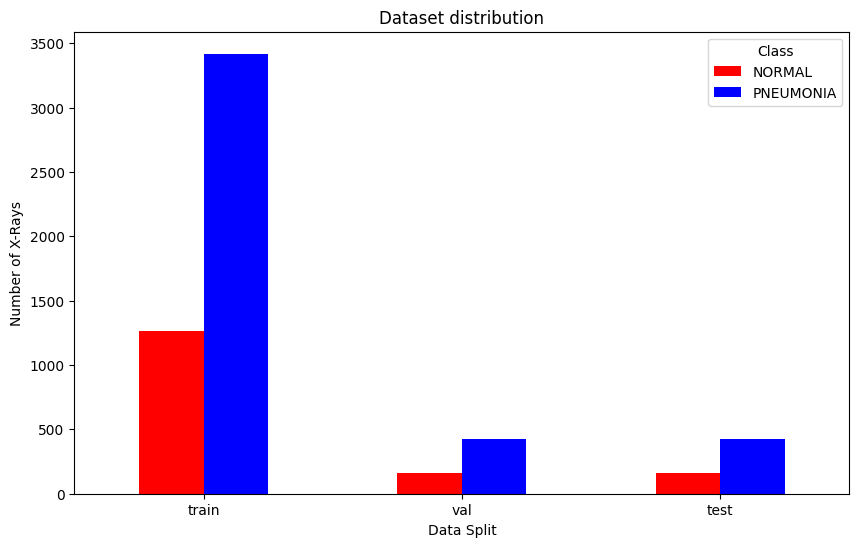

In [ ]:
dataset_stats(train_files, val_files, test_files, new_dataset_path)

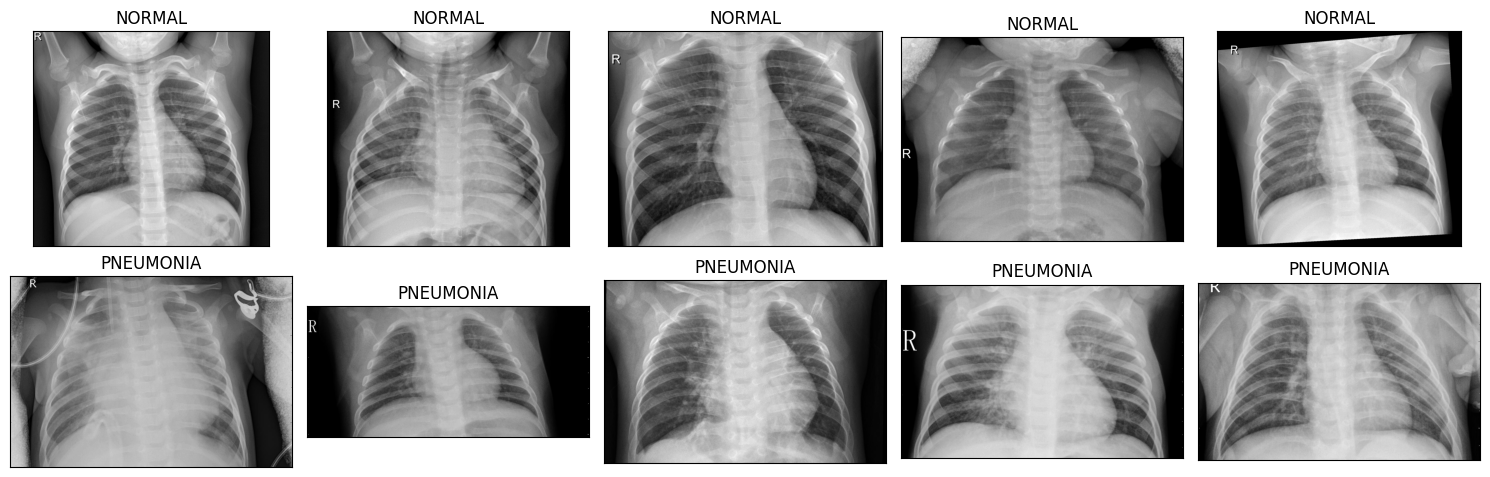

Image Mode Counts:
L: 4460
RGB: 224


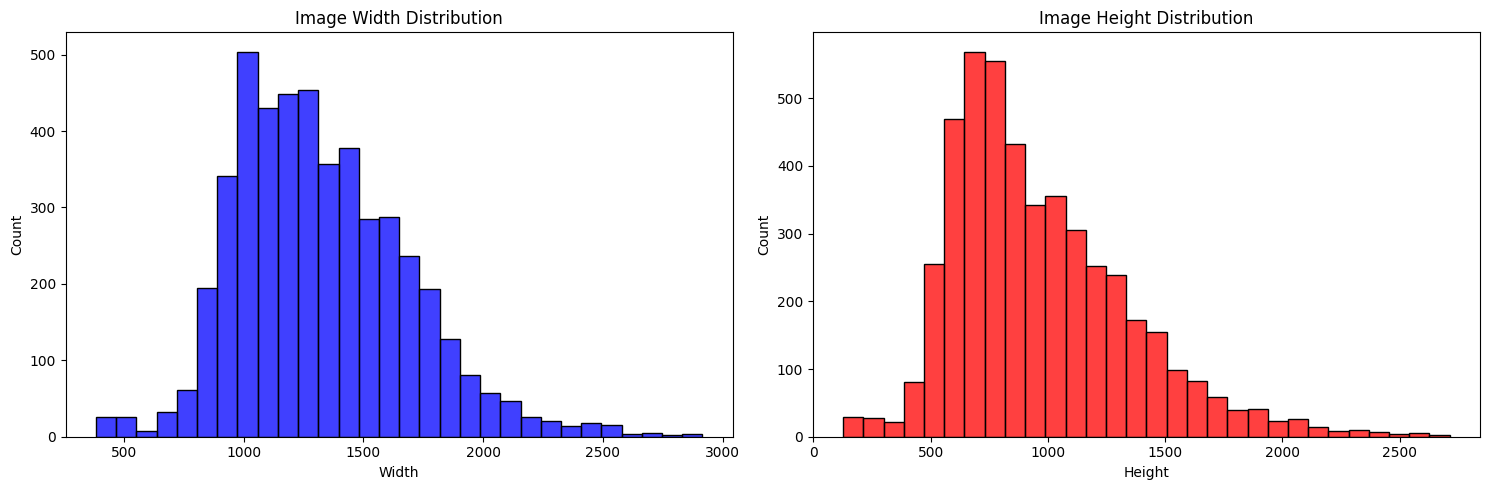

In [ ]:
image_analysis(train_files, val_files, test_files, new_dataset_path)

**(a)**

_Insert brief discussion of analysis here_

1. Class distribution

As shown in the data visualisation, we can see that there are 5856 X-Rays in the dataset. Within the training data, the distribution of Normal images and Pneumonia images is respectively 1266 and 3418. This imbalance might cause a biased model towards Pneumonia images.

2. Image information

The images are now saved as string values for the path to the right directory, so these need to be transformed to images before the training starts. There are also two different Image Modes present in the dataset, namely 'L' and 'RGB' (4460, 224 respectively). Therefore, we need to convert the minority of RGB images to L so there is only one type of input to the model. In addition, the images have different sizes which need to be rescaled as well.

3. Noise

In the input images we can see the letter r appearing in the images, with varying size and position but generally in the top left corner of the X-Ray. Therefore, it is expected that this will not affect the model in great deal. In addition, some of the images exhibit unrelated visuals (e.g. a pacemaker, unidentifyable objects). However, because these seem to appear random in both classes, they are not expected to impact the model.


# Question 2: Data Preparation (5 marks)

Here, you should load the dataset into torch dataloaders, performing any preprocessing required in the process.

Within the ChestXrayDataset class, the root_dir parameter is a string defining the directory containing the "train", "val" and "test" folders.

In [ ]:
dataset_path = "chest_xray_dataset_new_split"
batch_size = 64

In [ ]:
class ChestXrayDataset(Dataset):
    """
    To load the X-Ray dataset in a PyTorch compatible format and apply transformations on the images and labels
    """
    def __init__(self, root_dir, split='train', transform=None):

        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.images = []

        for cls in ['NORMAL', 'PNEUMONIA']:
            folder_path = os.path.join(self.root_dir, self.split, cls)
            for img in os.listdir(folder_path):
                self.images.append((img, cls))

        #print(self.images)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        img_path, label = self.images[idx]
        image_path = os.path.join(self.root_dir, self.split, label, img_path) #to get full path name instead of relative only
        image = Image.open(image_path) #to get image format

        if self.transform:
            image = self.transform(image)

        #set labels to 0 and 1 for efficiency, binary classification
        if label == "NORMAL":
          label = 0
        else:
          label = 1

        return image, label

In [ ]:
# Define data transforms

"""
Steps to take in transform:
1. Resize; all images need same size
2. Set all in same mode (L)
3. Covert to tensor
4. Normalize by mean and std which will be calculated later based on the first transformer, hence 2 different transformers

"""

#Needed for calculation for mean and std
data_transforms_without_normalization = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: img.convert('L')),
    transforms.ToTensor()
])

#Final datatransformer with normalization based on values calculated later on
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: img.convert('L')),
    transforms.ToTensor(),
    transforms.Normalize((0.4813,), (0.2215,))
])

In [ ]:
# Create datasets

training_data = ChestXrayDataset(root_dir=dataset_path, split='train', transform=data_transforms)
validation_data = ChestXrayDataset(root_dir=dataset_path, split='val', transform=data_transforms)
testing_data = ChestXrayDataset(root_dir=dataset_path, split='test', transform=data_transforms)

# Create data loaders

training_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=False)
testing_dataloader = DataLoader(testing_data, batch_size=batch_size, shuffle=False)

# Print dataset sizes
print(f"Training set size: {len(training_data)}")
print(f"Validation set size: {len(validation_data)}")
print(f"Testing set size: {len(testing_data)}")

# Print batch shapes
for batch in training_dataloader:
    images, labels = batch
    print(f"Batch images shape: {images.shape}")
    print(f"Batch labels shape: {labels.shape}")
    break

Training set size: 4684
Validation set size: 585
Testing set size: 587
Batch images shape: torch.Size([64, 1, 224, 224])
Batch labels shape: torch.Size([64])


In [ ]:
#mean & std calculation based on first transfomer
training_data_no_normalization = ChestXrayDataset(root_dir=dataset_path, split='train', transform=data_transforms_without_normalization)
data_loader_before_normalization = DataLoader(training_data_no_normalization, batch_size=batch_size, shuffle=True)

def mean_std(data_loader):
  """
  To calculate the mean and std of the training dataset needed for normalization
  Only on training data to prevent data leakage
  """
  mean = 0.0
  std = 0.0

  for images, _ in data_loader:
      batch_size = images.size(0)
      images = images.view(batch_size, -1)  #(batch_size, channels * height * width)
      mean += images.mean(1).sum()
      std += images.std(1).sum()

  mean /= len(data_loader.dataset)
  std /= len(data_loader.dataset)

  print(mean, std)

mean_std(data_loader_before_normalization)

#gives mean: 0.4813, std: 0.2215, after normalization it is 0.0002 and 0.9999, which is basically 0 and 1 as needed after normalization

tensor(0.4813) tensor(0.2215)


**(a)**

_Insert brief discussion of any design choices you made here_

1. Transforms

Based on the visualisations of the data, we transformed the data with respect to image size and mode. An image size of (224,224) is a popular choice in visual tasks for CNNs since the trade-off between detail and computational costs seems to be effective. Furthermore, the images are normalized for several reasons: stabilizing the gradient, allowing the model to learn more effectively, reducing the impact of variations in the image we do not want to take into account. Finally, since the notebook uses Pytorch, the dataset is transformed into Pytorch compatible data using tensors, the ChestXrayDataset class and the dataloaders.

2. ChestXrayDataset

The dataset class is set up with a list containing all the image files and a getitem function. This getitem retrieves an image from the path, transforms the image and sets the labels to 0 (normal) and 1 (pneumonia).  

3. Class imbalance

Regarding the imbalanced datasets, the transforms does not include a strategy to make it more balanced (e.g. oversampling, weigthed sampling). This is because a biased model towards pneumonia might be desired since it is safer to predict pneumonia when it is actually healthy than vice versa (minimize false negatives). For a baseline this is a good starting point and it might be reviewed later.

# Question 3: Training a Baseline (30 marks)

You will now establish an initial baseline model and training procedure. This should be as simple as possible, without using any elaborate design choices, whilst still obtaining reasonable performance (i.e., at least better than random chance). You will attempt to improve upon this baseline in later questions.

When answering this question, consider what makes a good baseline:
* Easily converges;
* Easy to implement;
* Established architectural components that have proved well suited to the data-type and problem.
* Obtains reasonable performance e.g, better than random guess

You will be required to explain your design choices, and to present and discuss you results.

The code below is a suggested structure to guide you. You are free to deviate from this __however, it must be obvious to the marker__:
* What the final proposed baseline model is (in terms of architecture);
* What the performance of the baseline model is and how the model has been trained;
* What your written justification and discussion is;



In [ ]:
default_config = {
    'optimizer': 'sgd',
    'learning_rate': 0.01,
    'batch_size': 64,
    'num_epochs': 30,
    'loss_function': nn.CrossEntropyLoss()} #cross entropy handles softmax activation

In [ ]:
# Define the model
class SimpleModel(nn.Module):

    """
    A simple CNN that consists of the basic 3 layers (Convolutional, pooling and fully connected)
    recall: Batch images shape: torch.Size([64, 1, 224, 224]) && Batch labels shape: torch.Size([64])
    """

    def __init__(self):
        super().__init__()
        self.conv_relu_pool_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #224 -> 112

            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #112 -> 56

            nn.Flatten(),
            nn.Linear(16 * 56 * 56, 2)
        )

    def forward(self, x):
        x = self.conv_relu_pool_stack(x)
        return x


In [ ]:
def calculate_class_accuracy(outputs, labels):
        """
        Class accuracy is defined as
        - Normal: (TN) / (TN + FN) where TN + FN is just all the negative labels in the dataset
        - Pneumonia: (TP) / (TP + FP)
        """

        tp = 0 #true positive, we predict Pneumonia and it is actually pneumonia, label 1
        positive_labels = 0
        tn = 0 #true negative, we predict Normal and it is actually normal, label 0
        negative_labels = 0

        _, predicted = torch.max(outputs, 1) #max log probability
        total = labels.size(0)

        for label, prediction in zip(labels, predicted):
            if label == 0: #=normal
                negative_labels += 1
                if prediction == 0:
                    tn += 1
            elif label == 1: #=pneumonia
                positive_labels += 1
                if prediction == 1:
                    tp += 1

        accuracy_normal = tn / negative_labels * 100 if negative_labels > 0 else 0
        accuracy_pneumonia =  tp / positive_labels * 100 if positive_labels > 0 else 0

        accuracy = (accuracy_normal, accuracy_pneumonia)

        return (accuracy)

In [ ]:
def calculate_sensitivity_specificity(outputs, labels):
    """
    To get results on sensitivity (TP/(TP+FN)) and specificity (TN/(TN+FP))
    These metrics tell us more on how well our model detects the positive and negative images respectively
    """
    _, predicted = torch.max(outputs, 1)
    true_positives = ((predicted == 1) & (labels == 1)).sum().item()
    true_negatives = ((predicted == 0) & (labels == 0)).sum().item()
    false_positives = ((predicted == 1) & (labels == 0)).sum().item()
    false_negatives = ((predicted == 0) & (labels == 1)).sum().item()

    sensitivity = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    specificity = true_negatives / (true_negatives + false_positives) if (true_negatives + false_positives) > 0 else 0

    return sensitivity, specificity

In [ ]:
wandb.init(project="xrays_coursework", entity="julievanl-ucl")

In [ ]:
def train_model(model, train_loader, val_loader, config=default_config, device='cuda', use_wandb=True):
    """
    Training loop to train a model
    This includes looping over all epochs for both training and validation data
    """

    #to log our results per epoch
    train_losses = []
    train_accuracies = []
    all_outputs_train = []
    all_labels_train = []
    train_class_accuracies = []
    train_sensitivities = []
    train_specificities = []

    val_losses = []
    val_accuracies = []
    all_outputs_val = []
    all_labels_val = []
    val_class_accuracies = []
    val_sensitivities = []
    val_specificities = []

    #set optimizer based on config input - to keep model easy to adjust
    if config['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    elif config['optimizer'] == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'])

    loss_function = config['loss_function']

    model.to(device)

    for epoch in range(config["num_epochs"]):
        model.train()

        loss_tracker = 0.0
        prediction_tracker = 0
        number_samples = 0

        for images, labels in tqdm(train_loader, desc="Training", unit="batch"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_function(outputs, labels)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_tracker += loss.item()
            _, predicted = torch.max(outputs, 1)
            prediction_tracker += (predicted == labels).sum().item()
            number_samples += labels.size(0)

            all_outputs_train.append(outputs)
            all_labels_train.append(labels)

        # average loss & accuracy for epoch - training
        train_loss = loss_tracker / len(train_loader)
        train_accuracy = prediction_tracker / number_samples * 100

        #calculate class accuracy
        all_outputs_train = torch.cat(all_outputs_train)
        all_labels_train = torch.cat(all_labels_train)
        train_class_accuracy = calculate_class_accuracy(all_outputs_train, all_labels_train)

        train_sensitivity, train_specificity = calculate_sensitivity_specificity(all_outputs_train, all_labels_train)

        #keep track of all results to plot later
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        train_class_accuracies.append(train_class_accuracy)
        train_sensitivities.append(train_sensitivity)
        train_specificities.append(train_specificity)

        if use_wandb:
            wandb.log({'Train Loss': train_loss, 'Train Accuracy': train_accuracy, 'Train Class Accuracy':train_class_accuracy,
                       'Train Sensitivity': train_sensitivity, 'Train Specificity': train_specificity})

        #end of training, start evaluation
        model.eval()

        loss_tracker_val = 0.0
        prediction_tracker_val = 0
        number_samples_val = 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validating", unit="batch"):
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                val_loss = loss_function(outputs, labels)
                loss_tracker_val += val_loss.item()

                _, predicted_val = torch.max(outputs, 1)
                prediction_tracker_val += (predicted_val == labels).sum().item()
                number_samples_val += labels.size(0)

                all_outputs_val.append(outputs)
                all_labels_val.append(labels)

        # average loss & accuracy for epoch - validation
        val_loss_avg = loss_tracker_val / len(val_loader)
        val_accuracy = prediction_tracker_val / number_samples_val * 100

        all_outputs_val = torch.cat(all_outputs_val)
        all_labels_val = torch.cat(all_labels_val)
        val_class_accuracy = calculate_class_accuracy(all_outputs_val, all_labels_val)
        val_sensitivity, val_specificity = calculate_sensitivity_specificity(all_outputs_val, all_labels_val)

        val_losses.append(val_loss_avg)
        val_accuracies.append(val_accuracy)
        val_class_accuracies.append(val_class_accuracy)
        val_sensitivities.append(val_sensitivity)
        val_specificities.append(val_specificity)

        if use_wandb:
            wandb.log({'Validation Loss': val_loss_avg, 'Validation Accuracy': val_accuracy, 'Validation Class Accuracy':val_class_accuracy,
                       'Validation Sensitivity': val_sensitivity, 'Validation Specificity': val_specificity})

        train_accuracy_normal, train_accuracy_pneumonia = train_class_accuracy
        val_accuracy_normal, val_accuracy_pneumonia = val_class_accuracy

        print(f"Epoch [{epoch + 1}/{config['num_epochs']}] - "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% - "
              f"Val Loss: {val_loss_avg:.4f}, Val Accuracy: {val_accuracy:.2f}% - "
              f"Train Normal Accuracy: {train_accuracy_normal:.2f}%, Train Pneumonia Accuracy: {train_accuracy_pneumonia:.2f}% - "
              f"Val Normal Accuracy: {val_accuracy_normal:.2f}%, Val Pneumonia Accuracy: {val_accuracy_pneumonia:.2f}%")

        #set as empty lists again for next epoch - needed for class accuracies
        all_outputs_train = []
        all_labels_train = []
        all_outputs_val = []
        all_labels_val = []

    return train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies


In [ ]:
def plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies):
    """
    Function to directly show in our notebook, to check on convergence
    Other metrics are stored in WandB as well
    """

    plt.figure(figsize=(10, 6))

    # loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red', marker='o')
    plt.plot(val_losses, label='Validation Loss', color='blue', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy', color='green', marker='o')
    plt.plot(val_accuracies, label='Validation Accuracy', color='black', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.20batch/s]


Epoch [1/30] - Train Loss: 0.4609, Train Accuracy: 81.19% - Val Loss: 0.2341, Val Accuracy: 93.16% - Train Normal Accuracy: 45.26%, Train Pneumonia Accuracy: 94.50% - Val Normal Accuracy: 94.30%, Val Pneumonia Accuracy: 92.74%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.32batch/s]


Epoch [2/30] - Train Loss: 0.2049, Train Accuracy: 92.21% - Val Loss: 0.1689, Val Accuracy: 91.97% - Train Normal Accuracy: 81.83%, Train Pneumonia Accuracy: 96.05% - Val Normal Accuracy: 70.89%, Val Pneumonia Accuracy: 99.77%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.31batch/s]


Epoch [3/30] - Train Loss: 0.1870, Train Accuracy: 92.95% - Val Loss: 0.1073, Val Accuracy: 95.90% - Train Normal Accuracy: 83.73%, Train Pneumonia Accuracy: 96.37% - Val Normal Accuracy: 89.87%, Val Pneumonia Accuracy: 98.13%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.29batch/s]


Epoch [4/30] - Train Loss: 0.1622, Train Accuracy: 93.98% - Val Loss: 0.1280, Val Accuracy: 94.70% - Train Normal Accuracy: 86.18%, Train Pneumonia Accuracy: 96.87% - Val Normal Accuracy: 96.20%, Val Pneumonia Accuracy: 94.15%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.50batch/s]


Epoch [5/30] - Train Loss: 0.1582, Train Accuracy: 94.34% - Val Loss: 0.1000, Val Accuracy: 96.24% - Train Normal Accuracy: 87.99%, Train Pneumonia Accuracy: 96.69% - Val Normal Accuracy: 91.77%, Val Pneumonia Accuracy: 97.89%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.35batch/s]


Epoch [6/30] - Train Loss: 0.1418, Train Accuracy: 94.75% - Val Loss: 0.1144, Val Accuracy: 94.70% - Train Normal Accuracy: 88.15%, Train Pneumonia Accuracy: 97.19% - Val Normal Accuracy: 82.91%, Val Pneumonia Accuracy: 99.06%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.34batch/s]


Epoch [7/30] - Train Loss: 0.1363, Train Accuracy: 95.03% - Val Loss: 0.1002, Val Accuracy: 96.24% - Train Normal Accuracy: 88.86%, Train Pneumonia Accuracy: 97.31% - Val Normal Accuracy: 94.94%, Val Pneumonia Accuracy: 96.72%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.38batch/s]


Epoch [8/30] - Train Loss: 0.1374, Train Accuracy: 95.09% - Val Loss: 0.2583, Val Accuracy: 87.86% - Train Normal Accuracy: 89.02%, Train Pneumonia Accuracy: 97.34% - Val Normal Accuracy: 55.06%, Val Pneumonia Accuracy: 100.00%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.47batch/s]


Epoch [9/30] - Train Loss: 0.1299, Train Accuracy: 95.37% - Val Loss: 0.1703, Val Accuracy: 92.48% - Train Normal Accuracy: 88.86%, Train Pneumonia Accuracy: 97.78% - Val Normal Accuracy: 72.15%, Val Pneumonia Accuracy: 100.00%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.35batch/s]


Epoch [10/30] - Train Loss: 0.1304, Train Accuracy: 95.22% - Val Loss: 0.2007, Val Accuracy: 90.26% - Train Normal Accuracy: 89.49%, Train Pneumonia Accuracy: 97.34% - Val Normal Accuracy: 63.92%, Val Pneumonia Accuracy: 100.00%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.39batch/s]


Epoch [11/30] - Train Loss: 0.1276, Train Accuracy: 95.58% - Val Loss: 0.1005, Val Accuracy: 96.24% - Train Normal Accuracy: 90.05%, Train Pneumonia Accuracy: 97.63% - Val Normal Accuracy: 96.20%, Val Pneumonia Accuracy: 96.25%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.45batch/s]


Epoch [12/30] - Train Loss: 0.1176, Train Accuracy: 95.82% - Val Loss: 0.1869, Val Accuracy: 91.28% - Train Normal Accuracy: 90.60%, Train Pneumonia Accuracy: 97.75% - Val Normal Accuracy: 98.10%, Val Pneumonia Accuracy: 88.76%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.44batch/s]


Epoch [13/30] - Train Loss: 0.1173, Train Accuracy: 95.64% - Val Loss: 0.0904, Val Accuracy: 95.73% - Train Normal Accuracy: 90.92%, Train Pneumonia Accuracy: 97.40% - Val Normal Accuracy: 87.97%, Val Pneumonia Accuracy: 98.59%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.27batch/s]


Epoch [14/30] - Train Loss: 0.1144, Train Accuracy: 96.20% - Val Loss: 0.1375, Val Accuracy: 94.19% - Train Normal Accuracy: 91.31%, Train Pneumonia Accuracy: 98.01% - Val Normal Accuracy: 96.84%, Val Pneumonia Accuracy: 93.21%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.27batch/s]


Epoch [15/30] - Train Loss: 0.1111, Train Accuracy: 95.84% - Val Loss: 0.0857, Val Accuracy: 96.75% - Train Normal Accuracy: 90.92%, Train Pneumonia Accuracy: 97.66% - Val Normal Accuracy: 91.77%, Val Pneumonia Accuracy: 98.59%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.28batch/s]


Epoch [16/30] - Train Loss: 0.1100, Train Accuracy: 95.92% - Val Loss: 0.0964, Val Accuracy: 95.90% - Train Normal Accuracy: 91.00%, Train Pneumonia Accuracy: 97.75% - Val Normal Accuracy: 87.34%, Val Pneumonia Accuracy: 99.06%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.40batch/s]


Epoch [17/30] - Train Loss: 0.1020, Train Accuracy: 96.48% - Val Loss: 0.0918, Val Accuracy: 96.58% - Train Normal Accuracy: 92.18%, Train Pneumonia Accuracy: 98.07% - Val Normal Accuracy: 96.84%, Val Pneumonia Accuracy: 96.49%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.20batch/s]


Epoch [18/30] - Train Loss: 0.1004, Train Accuracy: 96.20% - Val Loss: 0.0814, Val Accuracy: 96.75% - Train Normal Accuracy: 91.86%, Train Pneumonia Accuracy: 97.81% - Val Normal Accuracy: 91.77%, Val Pneumonia Accuracy: 98.59%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.21batch/s]


Epoch [19/30] - Train Loss: 0.1042, Train Accuracy: 96.18% - Val Loss: 0.0869, Val Accuracy: 96.24% - Train Normal Accuracy: 91.63%, Train Pneumonia Accuracy: 97.86% - Val Normal Accuracy: 89.24%, Val Pneumonia Accuracy: 98.83%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.46batch/s]


Epoch [20/30] - Train Loss: 0.0984, Train Accuracy: 96.18% - Val Loss: 0.0862, Val Accuracy: 96.41% - Train Normal Accuracy: 91.47%, Train Pneumonia Accuracy: 97.92% - Val Normal Accuracy: 89.24%, Val Pneumonia Accuracy: 99.06%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.30batch/s]


Epoch [21/30] - Train Loss: 0.0938, Train Accuracy: 96.43% - Val Loss: 0.1200, Val Accuracy: 95.04% - Train Normal Accuracy: 92.26%, Train Pneumonia Accuracy: 97.98% - Val Normal Accuracy: 97.47%, Val Pneumonia Accuracy: 94.15%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.33batch/s]


Epoch [22/30] - Train Loss: 0.1058, Train Accuracy: 96.07% - Val Loss: 0.1100, Val Accuracy: 95.56% - Train Normal Accuracy: 91.55%, Train Pneumonia Accuracy: 97.75% - Val Normal Accuracy: 97.47%, Val Pneumonia Accuracy: 94.85%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.31batch/s]


Epoch [23/30] - Train Loss: 0.0925, Train Accuracy: 96.63% - Val Loss: 0.0827, Val Accuracy: 96.24% - Train Normal Accuracy: 92.65%, Train Pneumonia Accuracy: 98.10% - Val Normal Accuracy: 94.94%, Val Pneumonia Accuracy: 96.72%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.32batch/s]


Epoch [24/30] - Train Loss: 0.0863, Train Accuracy: 96.86% - Val Loss: 0.0870, Val Accuracy: 95.90% - Train Normal Accuracy: 93.60%, Train Pneumonia Accuracy: 98.07% - Val Normal Accuracy: 95.57%, Val Pneumonia Accuracy: 96.02%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.49batch/s]


Epoch [25/30] - Train Loss: 0.0888, Train Accuracy: 96.73% - Val Loss: 0.1415, Val Accuracy: 93.50% - Train Normal Accuracy: 93.05%, Train Pneumonia Accuracy: 98.10% - Val Normal Accuracy: 77.22%, Val Pneumonia Accuracy: 99.53%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.48batch/s]


Epoch [26/30] - Train Loss: 0.0899, Train Accuracy: 96.61% - Val Loss: 0.0788, Val Accuracy: 96.75% - Train Normal Accuracy: 92.42%, Train Pneumonia Accuracy: 98.16% - Val Normal Accuracy: 94.30%, Val Pneumonia Accuracy: 97.66%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.28batch/s]


Epoch [27/30] - Train Loss: 0.0851, Train Accuracy: 97.01% - Val Loss: 0.1058, Val Accuracy: 95.56% - Train Normal Accuracy: 93.92%, Train Pneumonia Accuracy: 98.16% - Val Normal Accuracy: 85.44%, Val Pneumonia Accuracy: 99.30%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.30batch/s]


Epoch [28/30] - Train Loss: 0.0865, Train Accuracy: 96.75% - Val Loss: 0.0948, Val Accuracy: 96.07% - Train Normal Accuracy: 93.05%, Train Pneumonia Accuracy: 98.13% - Val Normal Accuracy: 87.97%, Val Pneumonia Accuracy: 99.06%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.42batch/s]


Epoch [29/30] - Train Loss: 0.0816, Train Accuracy: 97.20% - Val Loss: 0.0995, Val Accuracy: 95.73% - Train Normal Accuracy: 93.52%, Train Pneumonia Accuracy: 98.57% - Val Normal Accuracy: 96.84%, Val Pneumonia Accuracy: 95.32%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.36batch/s]


Epoch [30/30] - Train Loss: 0.0755, Train Accuracy: 97.20% - Val Loss: 0.1093, Val Accuracy: 95.56% - Train Normal Accuracy: 94.15%, Train Pneumonia Accuracy: 98.33% - Val Normal Accuracy: 97.47%, Val Pneumonia Accuracy: 94.85%


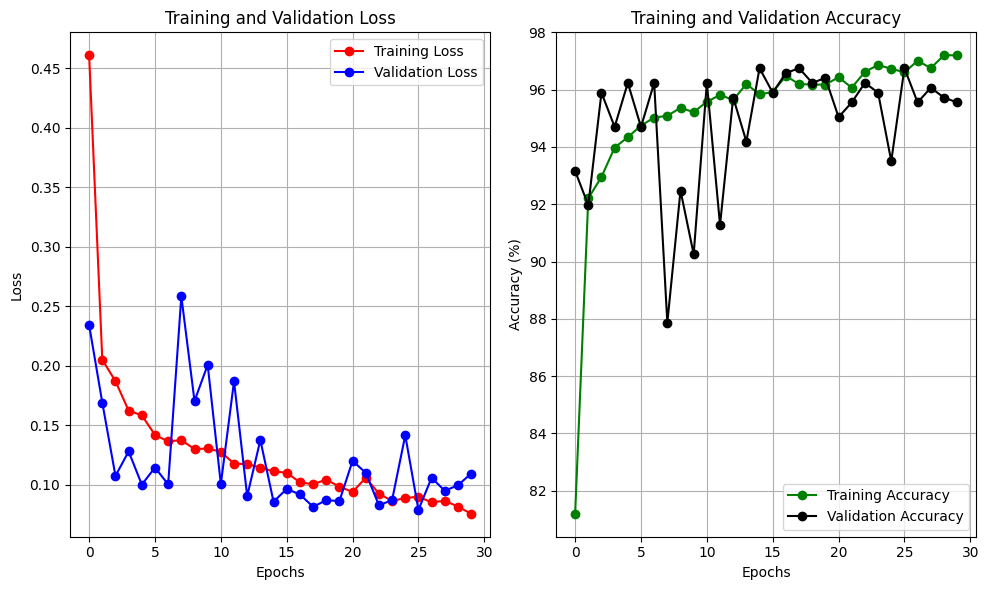

Model saved as 'chest_xray_model_baseline.pth'


In [ ]:
# Initialize the model
model = SimpleModel().to(device)

# Define loss function and optimizer -- Loss and optimizer are set in default config earlier on, but for reference these are the ones I used:

#criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# Train the model
train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies = train_model(
    model, training_dataloader, validation_dataloader, default_config, device, use_wandb=True)

# Plot training curves
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies)

# Save the model
torch.save(model.state_dict(), 'chest_xray_model_baseline.pth')
print("Model saved as 'chest_xray_model_baseline.pth'")


In [ ]:
#to retrieve saved model

#baseline_model = SimpleModel()
#baseline_model.to(device)
#baseline_model.load_state_dict(torch.load('chest_xray_model_baseline.pth'))
#baseline_model.eval()

**(a)**

_Insert brief explanation of the design choices you made_

1. Design choices for Simple Model architecture

A CNN is used in this specific case because this algorithm is a popular method for image classification, proven to perform well in many research papers. To keep our model easy to implement, nn.Sequential is used for a modular approach of the model. Furthermore, only components from the Pytorch library are used (like the convolutional layers and maxpooling). According to studies, a basic CNN is made with three types of layers: Convolutional, Pooling and Fully-Connected. As the depth of the network increases, so will the memory and time consumption. However, it needs to be deep enough to learn the features of the images (Guo, Dong, Li & Gao, 2017). The baseline needs to converge easily and a shallow architecture is thus preferred. Therefore, this simple model is built with only two blocks of ‘Convolutional layers > Relu activation function > MaxPooling’ and closed off with a flatten and fully connected layer. The out_channels, kernel_size, stride & padding for Conv2D are chosen such that computational costs are reasonable, and the spatial resolutions of the images are preserved. Relu is chosen because it is one of the most common activation functions in CNNs, suitable for the simple model because it is effective in fast convergence. MaxPooling with filter size 2x2 and stride 2, retains the most prominent features present in specific regions and is therefore a common choice in medical imaging data (Yamashita, Nishio, Do, et al., 2018). Before the final fully connected layer, the input is flattened to turn it into a vector.  This model has a final fully connected layer with output 2, referring to the probabilities that the label would be Normal or Pneumonia. This, in combination with the loss function Cross Entropy Loss, ensures that incorrect predictions are penalized and that the probabilities for each class are considered. Since nn.CrossEntropyLoss internally applies the Softmax function, this is not added in the SimpleModel(). It might also be a safer option to use 2 classes as outputs and the cross entropy loss instead of 1 output with a sigmoid function due to the imbalanced datasets. The first case also allows more flexibility in adjusting the model later (e.g. applying class weights).

2. Hyperparameters

The loss function is explained in the previous section. The optimizer SGD is chosen based on a study from 2021 that analyzed various optimizers on a CNN model for detecting Pneumonia. Their study concluded that SGD was the best option for this task and thus the Simple Model uses this optimizer (Chowdhury, Dasgupta, Nanda, 2021). Since we are using SGD, the batch size is kept reasonably small at 64. Number of epochs started at 5 for GPU reasons, at which the model showed a decrease on validation set after 3 epochs. Then, it was set to 30 to see if this first maximum was a local maximum or not and the parameter is kept at 30 to allow for convergence. The learning rate was set to 0.01, which is a common starting point for quick convergence. These hyperparameters can be tuned after, which could be considered as one of the improvements. But based on common design choices for CNNs they are set as described above.

3. Training loop

This notebook uses one function for the entire training of a model. This function includes looping over all epochs for both the training and the validation set. Furthermore, it keeps track of different results per epoch to keep track of our training.

**(b)**

_Present your results, including plots etc. here_

The baseline model achieves a validation accuracy of 95.6%, but did not fully converge. Furthermore, the training process seems to be quite unstable.


Summary metrics:

*   Train accuracy: 97.2% & train loss: 0.0755
*   Validation accuracy: 95.6% & validation loss: 0.1093
*   Validation normal class accuracy: 97.5%
*   Validation pneumonia class accuracy: 94.8%


Baseline results in graphs:
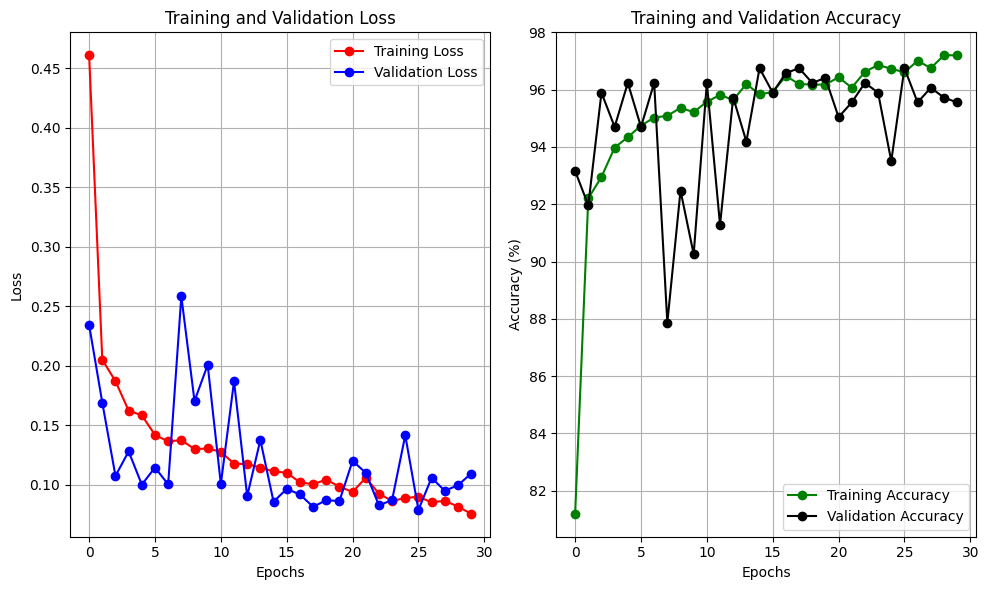

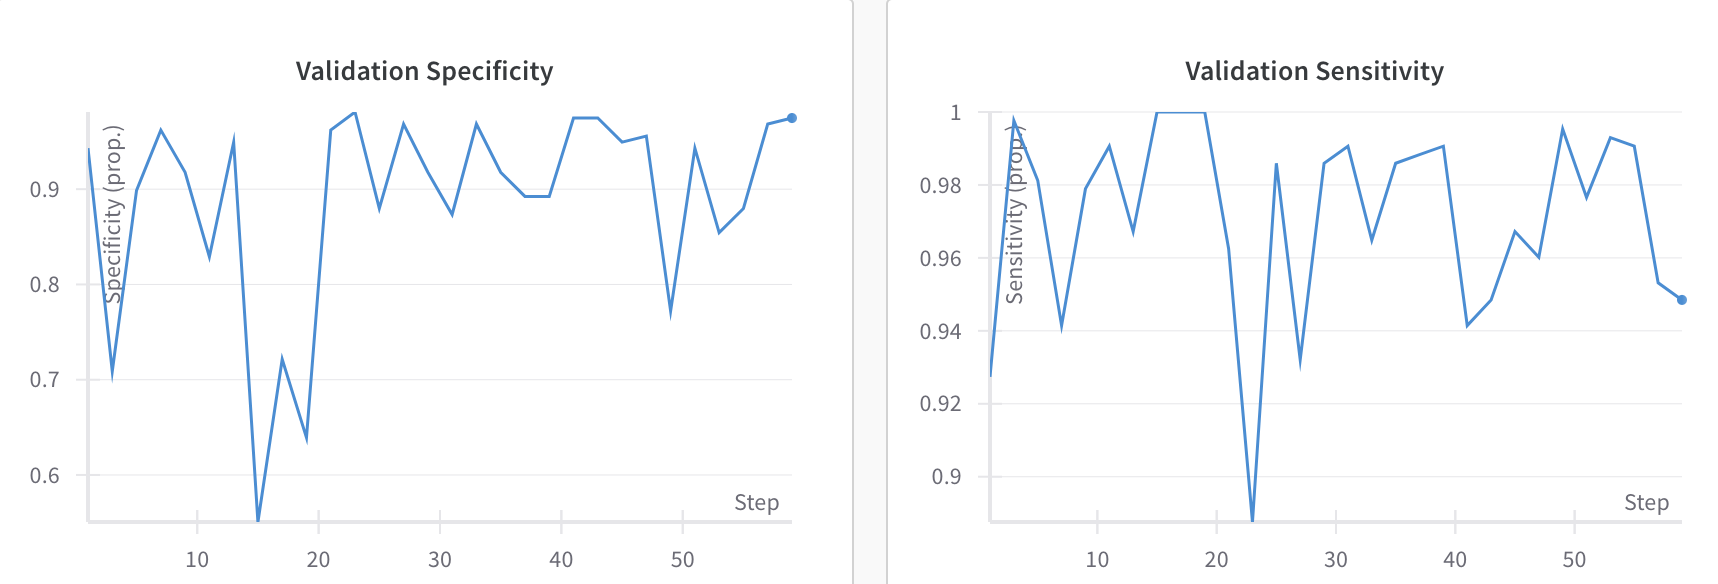

**(c)**

_Discuss your results here_

Since the classification problem is on medical data, the cost of a false negative (i.e. predicting normal when it is in fact pneumonia) is high. This is measured by metrics such as sensitivity and recall. In the sensitivity graph we can see that the validation sensitivity is very unstable, but around 96% in general. During the improvement of the model, it is good to pay attention to this curve to ensure a low false negative rate. Furthermore, it is notable that the normal class accuracy is really good even though there is a clear class imbalance. The baseline model (CNN), consisting of convolutional, pooling and fully connected layers, already performs really well. However, there are some popular ways of improving this model that can still be tested to improve our stability, sensitivity and accuracy/loss. In addition, we need our model to converge for reliability, the capacity to generalise on unseen data and giving us consistent predictions.


# Question 4: Improving the Baseline (50 marks)
After analysing the results of your baseline, can you spot any clear areas for improvement, or think of any obvious improvements to your model and training setup that will improve performance?

You are free to try out as many improvements as you want here. You may also try modifying aspects of the data.

**However, for the final code and results you present in your submission, you should use exactly 3 design choices which (attempt to) improve upon the baseline.**

In [ ]:
def test_improvements(model, config, training_dataloader, validation_dataloader, testing_dataloader, device, saved_path="chest_xray_model.pth"):
  """
  To try out different improvements by just calling this function.
  Train and save the model & log in WandB
  """
  wandb.init(project="xrays_coursework", entity="julievanl-ucl")

  # Train the model
  train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies = train_model(
      model, training_dataloader, validation_dataloader, config, device, use_wandb=True)

  # Plot training curves
  plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies)

  # Save the model
  torch.save(model.state_dict(), saved_path)
  print("Model saved")

  wandb.finish()

  return model

In the cells below, different improvements are tried out and follow the experiment set up: Baseline + 1 improvement. All of these improvements are based on research found online, but only the 3 final improvements are explained in depth. The following topics are adressed:

1. Expand baseline model with an extra fully connected layer
2. Add batch normalization
3. Add dropout layer
4. Add learning rate scheduler
5. Use a weighted sampler for the dataloader
6. Initialize the weights

In [ ]:
"""
Extra fc layer -- increased learning capacity
The baseline model is relatively shallow and thus a first possible improvement could be to add an extra fully connected layer.
"""

class withExtraFullyConnectedLayer(nn.Module):

    def __init__(self, fc_layer_size):
        super().__init__()
        self.conv_relu_pool_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #224 -> 112

            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #112 -> 56

            nn.Flatten(),
            nn.Linear(16 * 56 * 56, fc_layer_size),  #ADDED fully connected layer
            nn.Linear(fc_layer_size, 2)
        )

    def forward(self, x):
        x = self.conv_relu_pool_stack(x)
        return x

model_with_extra_fc = withExtraFullyConnectedLayer(fc_layer_size=256)
model_with_extra_fc.to(device)


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.37batch/s]


Epoch [1/30] - Train Loss: 0.4596, Train Accuracy: 79.31% - Val Loss: 0.2527, Val Accuracy: 91.79% - Train Normal Accuracy: 29.30%, Train Pneumonia Accuracy: 97.83% - Val Normal Accuracy: 88.61%, Val Pneumonia Accuracy: 92.97%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.40batch/s]


Epoch [2/30] - Train Loss: 0.2450, Train Accuracy: 90.44% - Val Loss: 0.2422, Val Accuracy: 88.38% - Train Normal Accuracy: 77.57%, Train Pneumonia Accuracy: 95.20% - Val Normal Accuracy: 96.84%, Val Pneumonia Accuracy: 85.25%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.41batch/s]


Epoch [3/30] - Train Loss: 0.2060, Train Accuracy: 91.93% - Val Loss: 0.1267, Val Accuracy: 94.19% - Train Normal Accuracy: 82.78%, Train Pneumonia Accuracy: 95.32% - Val Normal Accuracy: 81.65%, Val Pneumonia Accuracy: 98.83%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.45batch/s]


Epoch [4/30] - Train Loss: 0.1801, Train Accuracy: 93.04% - Val Loss: 0.1187, Val Accuracy: 94.19% - Train Normal Accuracy: 83.49%, Train Pneumonia Accuracy: 96.58% - Val Normal Accuracy: 81.65%, Val Pneumonia Accuracy: 98.83%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.49batch/s]


Epoch [5/30] - Train Loss: 0.1611, Train Accuracy: 93.74% - Val Loss: 0.1156, Val Accuracy: 94.53% - Train Normal Accuracy: 86.26%, Train Pneumonia Accuracy: 96.52% - Val Normal Accuracy: 82.91%, Val Pneumonia Accuracy: 98.83%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.30batch/s]


Epoch [6/30] - Train Loss: 0.1491, Train Accuracy: 94.30% - Val Loss: 0.0998, Val Accuracy: 95.73% - Train Normal Accuracy: 86.97%, Train Pneumonia Accuracy: 97.02% - Val Normal Accuracy: 89.24%, Val Pneumonia Accuracy: 98.13%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.34batch/s]


Epoch [7/30] - Train Loss: 0.1442, Train Accuracy: 94.58% - Val Loss: 0.5660, Val Accuracy: 76.07% - Train Normal Accuracy: 87.76%, Train Pneumonia Accuracy: 97.10% - Val Normal Accuracy: 100.00%, Val Pneumonia Accuracy: 67.21%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.25batch/s]


Epoch [8/30] - Train Loss: 0.1522, Train Accuracy: 94.53% - Val Loss: 0.1836, Val Accuracy: 91.62% - Train Normal Accuracy: 88.15%, Train Pneumonia Accuracy: 96.90% - Val Normal Accuracy: 68.99%, Val Pneumonia Accuracy: 100.00%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.39batch/s]


Epoch [9/30] - Train Loss: 0.1347, Train Accuracy: 95.28% - Val Loss: 0.1260, Val Accuracy: 94.02% - Train Normal Accuracy: 89.10%, Train Pneumonia Accuracy: 97.57% - Val Normal Accuracy: 81.01%, Val Pneumonia Accuracy: 98.83%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.41batch/s]


Epoch [10/30] - Train Loss: 0.1349, Train Accuracy: 94.96% - Val Loss: 0.1918, Val Accuracy: 91.11% - Train Normal Accuracy: 89.18%, Train Pneumonia Accuracy: 97.10% - Val Normal Accuracy: 98.10%, Val Pneumonia Accuracy: 88.52%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.26batch/s]


Epoch [11/30] - Train Loss: 0.1263, Train Accuracy: 95.35% - Val Loss: 0.1056, Val Accuracy: 95.90% - Train Normal Accuracy: 89.89%, Train Pneumonia Accuracy: 97.37% - Val Normal Accuracy: 95.57%, Val Pneumonia Accuracy: 96.02%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.47batch/s]


Epoch [12/30] - Train Loss: 0.1241, Train Accuracy: 95.45% - Val Loss: 0.0920, Val Accuracy: 96.92% - Train Normal Accuracy: 90.05%, Train Pneumonia Accuracy: 97.45% - Val Normal Accuracy: 94.30%, Val Pneumonia Accuracy: 97.89%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.45batch/s]


Epoch [13/30] - Train Loss: 0.1187, Train Accuracy: 95.45% - Val Loss: 0.0965, Val Accuracy: 95.90% - Train Normal Accuracy: 90.28%, Train Pneumonia Accuracy: 97.37% - Val Normal Accuracy: 87.34%, Val Pneumonia Accuracy: 99.06%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.33batch/s]


Epoch [14/30] - Train Loss: 0.1219, Train Accuracy: 95.58% - Val Loss: 0.4801, Val Accuracy: 81.88% - Train Normal Accuracy: 90.84%, Train Pneumonia Accuracy: 97.34% - Val Normal Accuracy: 32.91%, Val Pneumonia Accuracy: 100.00%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.34batch/s]


Epoch [15/30] - Train Loss: 0.1270, Train Accuracy: 95.32% - Val Loss: 0.1305, Val Accuracy: 94.53% - Train Normal Accuracy: 89.57%, Train Pneumonia Accuracy: 97.45% - Val Normal Accuracy: 97.47%, Val Pneumonia Accuracy: 93.44%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.48batch/s]


Epoch [16/30] - Train Loss: 0.1253, Train Accuracy: 95.67% - Val Loss: 0.0910, Val Accuracy: 97.09% - Train Normal Accuracy: 91.15%, Train Pneumonia Accuracy: 97.34% - Val Normal Accuracy: 93.04%, Val Pneumonia Accuracy: 98.59%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.47batch/s]


Epoch [17/30] - Train Loss: 0.1084, Train Accuracy: 95.84% - Val Loss: 0.0967, Val Accuracy: 95.73% - Train Normal Accuracy: 90.76%, Train Pneumonia Accuracy: 97.72% - Val Normal Accuracy: 86.71%, Val Pneumonia Accuracy: 99.06%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.34batch/s]


Epoch [18/30] - Train Loss: 0.1115, Train Accuracy: 95.75% - Val Loss: 0.1052, Val Accuracy: 95.73% - Train Normal Accuracy: 91.07%, Train Pneumonia Accuracy: 97.48% - Val Normal Accuracy: 95.57%, Val Pneumonia Accuracy: 95.78%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.47batch/s]


Epoch [19/30] - Train Loss: 0.1107, Train Accuracy: 96.20% - Val Loss: 0.4866, Val Accuracy: 80.17% - Train Normal Accuracy: 91.71%, Train Pneumonia Accuracy: 97.86% - Val Normal Accuracy: 99.37%, Val Pneumonia Accuracy: 73.07%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.41batch/s]


Epoch [20/30] - Train Loss: 0.1119, Train Accuracy: 95.88% - Val Loss: 0.1681, Val Accuracy: 92.99% - Train Normal Accuracy: 91.47%, Train Pneumonia Accuracy: 97.51% - Val Normal Accuracy: 97.47%, Val Pneumonia Accuracy: 91.33%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.32batch/s]


Epoch [21/30] - Train Loss: 0.1035, Train Accuracy: 96.35% - Val Loss: 0.0880, Val Accuracy: 96.41% - Train Normal Accuracy: 92.18%, Train Pneumonia Accuracy: 97.89% - Val Normal Accuracy: 95.57%, Val Pneumonia Accuracy: 96.72%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.30batch/s]


Epoch [22/30] - Train Loss: 0.1051, Train Accuracy: 95.96% - Val Loss: 0.0823, Val Accuracy: 96.92% - Train Normal Accuracy: 91.79%, Train Pneumonia Accuracy: 97.51% - Val Normal Accuracy: 93.04%, Val Pneumonia Accuracy: 98.36%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.51batch/s]


Epoch [23/30] - Train Loss: 0.1004, Train Accuracy: 96.52% - Val Loss: 0.0828, Val Accuracy: 96.92% - Train Normal Accuracy: 92.65%, Train Pneumonia Accuracy: 97.95% - Val Normal Accuracy: 93.04%, Val Pneumonia Accuracy: 98.36%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.33batch/s]


Epoch [24/30] - Train Loss: 0.0996, Train Accuracy: 96.16% - Val Loss: 0.0819, Val Accuracy: 97.61% - Train Normal Accuracy: 92.34%, Train Pneumonia Accuracy: 97.57% - Val Normal Accuracy: 95.57%, Val Pneumonia Accuracy: 98.36%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.42batch/s]


Epoch [25/30] - Train Loss: 0.1015, Train Accuracy: 96.31% - Val Loss: 0.0866, Val Accuracy: 96.24% - Train Normal Accuracy: 92.26%, Train Pneumonia Accuracy: 97.81% - Val Normal Accuracy: 89.24%, Val Pneumonia Accuracy: 98.83%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.49batch/s]


Epoch [26/30] - Train Loss: 0.0967, Train Accuracy: 96.43% - Val Loss: 0.0827, Val Accuracy: 97.09% - Train Normal Accuracy: 92.50%, Train Pneumonia Accuracy: 97.89% - Val Normal Accuracy: 94.30%, Val Pneumonia Accuracy: 98.13%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.33batch/s]


Epoch [27/30] - Train Loss: 0.0908, Train Accuracy: 96.93% - Val Loss: 0.1493, Val Accuracy: 94.53% - Train Normal Accuracy: 93.29%, Train Pneumonia Accuracy: 98.27% - Val Normal Accuracy: 80.38%, Val Pneumonia Accuracy: 99.77%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.43batch/s]


Epoch [28/30] - Train Loss: 0.0874, Train Accuracy: 96.69% - Val Loss: 0.0833, Val Accuracy: 97.44% - Train Normal Accuracy: 92.73%, Train Pneumonia Accuracy: 98.16% - Val Normal Accuracy: 95.57%, Val Pneumonia Accuracy: 98.13%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.27batch/s]


Epoch [29/30] - Train Loss: 0.0901, Train Accuracy: 96.73% - Val Loss: 0.0860, Val Accuracy: 96.41% - Train Normal Accuracy: 93.21%, Train Pneumonia Accuracy: 98.04% - Val Normal Accuracy: 94.94%, Val Pneumonia Accuracy: 96.96%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.47batch/s]


Epoch [30/30] - Train Loss: 0.0870, Train Accuracy: 96.80% - Val Loss: 0.0821, Val Accuracy: 96.92% - Train Normal Accuracy: 93.13%, Train Pneumonia Accuracy: 98.16% - Val Normal Accuracy: 94.94%, Val Pneumonia Accuracy: 97.66%


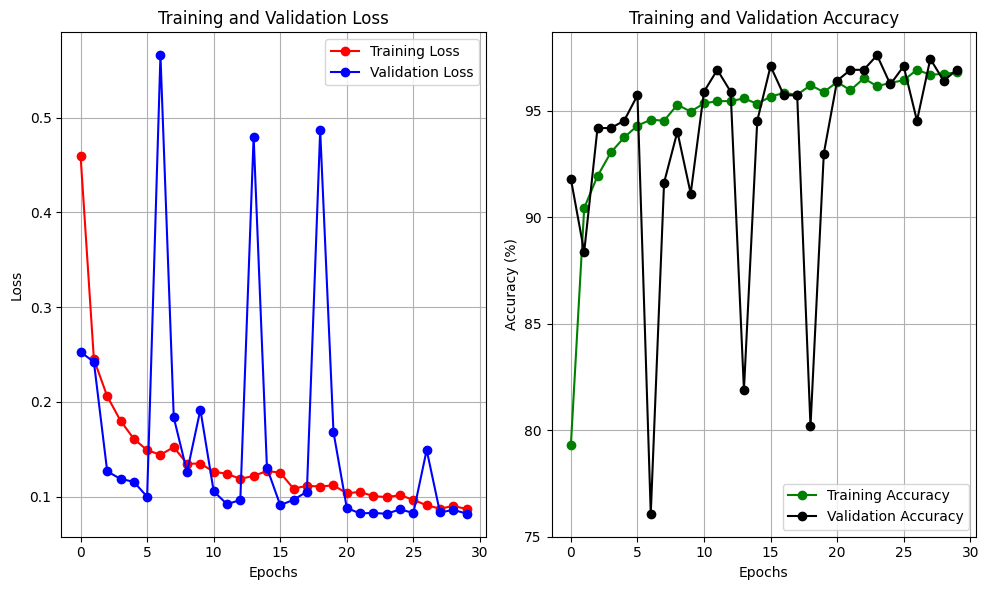

Model saved


withExtraFullyConnectedLayer(
  (conv_relu_pool_stack): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=50176, out_features=256, bias=True)
    (8): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [ ]:
test_improvements(model_with_extra_fc, default_config, training_dataloader, validation_dataloader, testing_dataloader, device, "chest_xray_model_extraFC")
#Validation accuracy of 96.9%, sensitivity of 97.6% --

In [ ]:
"""
Batch normalization -- stability & faster convergence
Batch normalization is a popular technique in CNNs to improve on models.
BatchNorm is typically placed after each convolutional layer and before the activation function (Al-Shourbaji, Kachare, Abualigah, et al., 2022).
"""
class withBatchNormalization(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv_relu_pool_stack = nn.Sequential(
            #layer 1
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8), #ADDED
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #224 -> 112

            #layer 2
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16), #ADDED
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #112 -> 56

            nn.Flatten(),
            nn.Linear(16 * 56 * 56, 2)
        )

    def forward(self, x):
        x = self.conv_relu_pool_stack(x)
        return x

model_with_batchnormalization = withBatchNormalization()
model_with_batchnormalization.to(device)

Validating: 100%|██████████| 10/10 [00:04<00:00,  2.29batch/s]


Epoch [1/30] - Train Loss: 3.3888, Train Accuracy: 82.32% - Val Loss: 4.2505, Val Accuracy: 34.53% - Train Normal Accuracy: 67.54%, Train Pneumonia Accuracy: 87.80% - Val Normal Accuracy: 100.00%, Val Pneumonia Accuracy: 10.30%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.42batch/s]


Epoch [2/30] - Train Loss: 0.2974, Train Accuracy: 92.23% - Val Loss: 0.1450, Val Accuracy: 93.16% - Train Normal Accuracy: 85.07%, Train Pneumonia Accuracy: 94.88% - Val Normal Accuracy: 93.04%, Val Pneumonia Accuracy: 93.21%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.25batch/s]


Epoch [3/30] - Train Loss: 0.1818, Train Accuracy: 94.04% - Val Loss: 0.1045, Val Accuracy: 95.56% - Train Normal Accuracy: 87.52%, Train Pneumonia Accuracy: 96.46% - Val Normal Accuracy: 91.77%, Val Pneumonia Accuracy: 96.96%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.38batch/s]


Epoch [4/30] - Train Loss: 0.1850, Train Accuracy: 93.23% - Val Loss: 0.3874, Val Accuracy: 84.79% - Train Normal Accuracy: 85.55%, Train Pneumonia Accuracy: 96.08% - Val Normal Accuracy: 98.73%, Val Pneumonia Accuracy: 79.63%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.30batch/s]


Epoch [5/30] - Train Loss: 0.1523, Train Accuracy: 94.21% - Val Loss: 0.1940, Val Accuracy: 91.97% - Train Normal Accuracy: 88.07%, Train Pneumonia Accuracy: 96.49% - Val Normal Accuracy: 97.47%, Val Pneumonia Accuracy: 89.93%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.44batch/s]


Epoch [6/30] - Train Loss: 0.1227, Train Accuracy: 95.09% - Val Loss: 0.0942, Val Accuracy: 96.07% - Train Normal Accuracy: 89.18%, Train Pneumonia Accuracy: 97.28% - Val Normal Accuracy: 89.87%, Val Pneumonia Accuracy: 98.36%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.49batch/s]


Epoch [7/30] - Train Loss: 0.1255, Train Accuracy: 95.20% - Val Loss: 0.0951, Val Accuracy: 96.24% - Train Normal Accuracy: 89.57%, Train Pneumonia Accuracy: 97.28% - Val Normal Accuracy: 91.77%, Val Pneumonia Accuracy: 97.89%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.24batch/s]


Epoch [8/30] - Train Loss: 0.1221, Train Accuracy: 95.41% - Val Loss: 0.1930, Val Accuracy: 92.48% - Train Normal Accuracy: 89.65%, Train Pneumonia Accuracy: 97.54% - Val Normal Accuracy: 96.84%, Val Pneumonia Accuracy: 90.87%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.38batch/s]


Epoch [9/30] - Train Loss: 0.1153, Train Accuracy: 95.71% - Val Loss: 0.1152, Val Accuracy: 95.21% - Train Normal Accuracy: 91.23%, Train Pneumonia Accuracy: 97.37% - Val Normal Accuracy: 84.18%, Val Pneumonia Accuracy: 99.30%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.48batch/s]


Epoch [10/30] - Train Loss: 0.1024, Train Accuracy: 95.86% - Val Loss: 0.1186, Val Accuracy: 94.87% - Train Normal Accuracy: 90.84%, Train Pneumonia Accuracy: 97.72% - Val Normal Accuracy: 95.57%, Val Pneumonia Accuracy: 94.61%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.41batch/s]


Epoch [11/30] - Train Loss: 0.0958, Train Accuracy: 96.43% - Val Loss: 0.0927, Val Accuracy: 96.07% - Train Normal Accuracy: 92.50%, Train Pneumonia Accuracy: 97.89% - Val Normal Accuracy: 91.77%, Val Pneumonia Accuracy: 97.66%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.34batch/s]


Epoch [12/30] - Train Loss: 0.0907, Train Accuracy: 96.65% - Val Loss: 0.0896, Val Accuracy: 96.24% - Train Normal Accuracy: 92.10%, Train Pneumonia Accuracy: 98.33% - Val Normal Accuracy: 94.30%, Val Pneumonia Accuracy: 96.96%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.45batch/s]


Epoch [13/30] - Train Loss: 0.1206, Train Accuracy: 95.58% - Val Loss: 0.0845, Val Accuracy: 96.07% - Train Normal Accuracy: 90.84%, Train Pneumonia Accuracy: 97.34% - Val Normal Accuracy: 92.41%, Val Pneumonia Accuracy: 97.42%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.28batch/s]


Epoch [14/30] - Train Loss: 0.0773, Train Accuracy: 97.25% - Val Loss: 0.1002, Val Accuracy: 95.73% - Train Normal Accuracy: 93.68%, Train Pneumonia Accuracy: 98.57% - Val Normal Accuracy: 94.94%, Val Pneumonia Accuracy: 96.02%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.34batch/s]


Epoch [15/30] - Train Loss: 0.0728, Train Accuracy: 97.33% - Val Loss: 0.0968, Val Accuracy: 96.07% - Train Normal Accuracy: 94.31%, Train Pneumonia Accuracy: 98.45% - Val Normal Accuracy: 93.04%, Val Pneumonia Accuracy: 97.19%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.32batch/s]


Epoch [16/30] - Train Loss: 0.0661, Train Accuracy: 97.65% - Val Loss: 0.0920, Val Accuracy: 96.41% - Train Normal Accuracy: 94.87%, Train Pneumonia Accuracy: 98.68% - Val Normal Accuracy: 93.04%, Val Pneumonia Accuracy: 97.66%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.52batch/s]


Epoch [17/30] - Train Loss: 0.0585, Train Accuracy: 97.76% - Val Loss: 0.0908, Val Accuracy: 95.90% - Train Normal Accuracy: 95.34%, Train Pneumonia Accuracy: 98.65% - Val Normal Accuracy: 89.87%, Val Pneumonia Accuracy: 98.13%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.45batch/s]


Epoch [18/30] - Train Loss: 0.0596, Train Accuracy: 98.06% - Val Loss: 0.7574, Val Accuracy: 78.12% - Train Normal Accuracy: 95.73%, Train Pneumonia Accuracy: 98.92% - Val Normal Accuracy: 18.99%, Val Pneumonia Accuracy: 100.00%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.43batch/s]


Epoch [19/30] - Train Loss: 0.0737, Train Accuracy: 97.33% - Val Loss: 0.0871, Val Accuracy: 96.58% - Train Normal Accuracy: 94.00%, Train Pneumonia Accuracy: 98.57% - Val Normal Accuracy: 94.30%, Val Pneumonia Accuracy: 97.42%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.49batch/s]


Epoch [20/30] - Train Loss: 0.0643, Train Accuracy: 97.63% - Val Loss: 0.5105, Val Accuracy: 82.22% - Train Normal Accuracy: 95.10%, Train Pneumonia Accuracy: 98.57% - Val Normal Accuracy: 99.37%, Val Pneumonia Accuracy: 75.88%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.28batch/s]


Epoch [21/30] - Train Loss: 0.0769, Train Accuracy: 97.22% - Val Loss: 0.1137, Val Accuracy: 95.38% - Train Normal Accuracy: 93.92%, Train Pneumonia Accuracy: 98.45% - Val Normal Accuracy: 96.20%, Val Pneumonia Accuracy: 95.08%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.26batch/s]


Epoch [22/30] - Train Loss: 0.0559, Train Accuracy: 98.06% - Val Loss: 0.0952, Val Accuracy: 95.90% - Train Normal Accuracy: 95.89%, Train Pneumonia Accuracy: 98.86% - Val Normal Accuracy: 95.57%, Val Pneumonia Accuracy: 96.02%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.31batch/s]


Epoch [23/30] - Train Loss: 0.0408, Train Accuracy: 98.89% - Val Loss: 0.1456, Val Accuracy: 94.87% - Train Normal Accuracy: 97.31%, Train Pneumonia Accuracy: 99.47% - Val Normal Accuracy: 82.91%, Val Pneumonia Accuracy: 99.30%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.21batch/s]


Epoch [24/30] - Train Loss: 0.0516, Train Accuracy: 98.29% - Val Loss: 0.0960, Val Accuracy: 95.73% - Train Normal Accuracy: 96.21%, Train Pneumonia Accuracy: 99.06% - Val Normal Accuracy: 89.87%, Val Pneumonia Accuracy: 97.89%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.43batch/s]


Epoch [25/30] - Train Loss: 0.0285, Train Accuracy: 99.21% - Val Loss: 0.0958, Val Accuracy: 96.07% - Train Normal Accuracy: 98.26%, Train Pneumonia Accuracy: 99.56% - Val Normal Accuracy: 95.57%, Val Pneumonia Accuracy: 96.25%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.40batch/s]


Epoch [26/30] - Train Loss: 0.0268, Train Accuracy: 99.38% - Val Loss: 0.1100, Val Accuracy: 96.24% - Train Normal Accuracy: 98.42%, Train Pneumonia Accuracy: 99.74% - Val Normal Accuracy: 97.47%, Val Pneumonia Accuracy: 95.78%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.85batch/s]


Epoch [27/30] - Train Loss: 0.0218, Train Accuracy: 99.47% - Val Loss: 0.0953, Val Accuracy: 96.07% - Train Normal Accuracy: 98.58%, Train Pneumonia Accuracy: 99.80% - Val Normal Accuracy: 93.04%, Val Pneumonia Accuracy: 97.19%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.66batch/s]


Epoch [28/30] - Train Loss: 0.0213, Train Accuracy: 99.59% - Val Loss: 0.1046, Val Accuracy: 95.73% - Train Normal Accuracy: 98.82%, Train Pneumonia Accuracy: 99.88% - Val Normal Accuracy: 95.57%, Val Pneumonia Accuracy: 95.78%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.74batch/s]


Epoch [29/30] - Train Loss: 0.0197, Train Accuracy: 99.64% - Val Loss: 0.0935, Val Accuracy: 95.73% - Train Normal Accuracy: 99.13%, Train Pneumonia Accuracy: 99.82% - Val Normal Accuracy: 92.41%, Val Pneumonia Accuracy: 96.96%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.80batch/s]


Epoch [30/30] - Train Loss: 0.0178, Train Accuracy: 99.66% - Val Loss: 0.1180, Val Accuracy: 95.56% - Train Normal Accuracy: 99.13%, Train Pneumonia Accuracy: 99.85% - Val Normal Accuracy: 96.20%, Val Pneumonia Accuracy: 95.32%


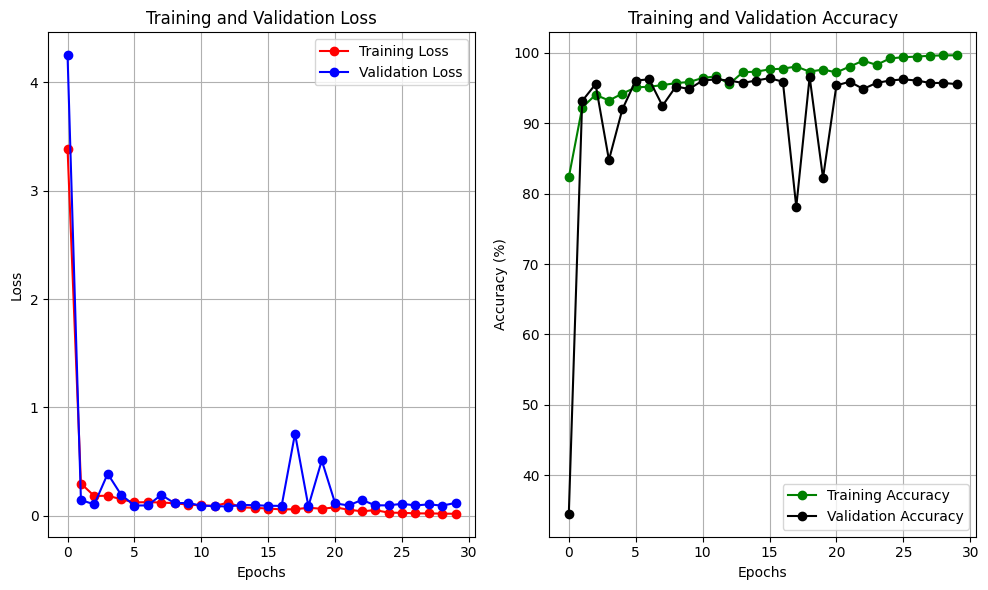

Model saved


withBatchNormalization(
  (conv_relu_pool_stack): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=50176, out_features=2, bias=True)
  )
)

In [ ]:
test_improvements(model_with_batchnormalization, default_config, training_dataloader, validation_dataloader, testing_dataloader, device, "chest_xray_model_batchnorm")
#Validation accuracy with batch: 95.6%, sensitivity: 95.3%

In [ ]:
"""
Dropout layer -- reduce overfitting with respect to validation set
Dropout layers are often implemented in CNNs to improve generalization with respect to the validation/test set
"""
class withDropOutLayer(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv_relu_pool_stack = nn.Sequential(
            #layer 1
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #224 -> 112

            #layer 2
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #112 -> 56

            nn.Flatten(),
            nn.Dropout(0.8),
            nn.Linear(16 * 56 * 56, 2)
        )

    def forward(self, x):
        x = self.conv_relu_pool_stack(x)
        return x

model_with_dropout = withDropOutLayer()
model_with_dropout.to(device)

Validating: 100%|██████████| 10/10 [00:05<00:00,  1.77batch/s]


Epoch [1/30] - Train Loss: 0.5439, Train Accuracy: 80.29% - Val Loss: 0.2663, Val Accuracy: 86.15% - Train Normal Accuracy: 44.55%, Train Pneumonia Accuracy: 93.53% - Val Normal Accuracy: 49.37%, Val Pneumonia Accuracy: 99.77%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.61batch/s]


Epoch [2/30] - Train Loss: 0.2445, Train Accuracy: 90.18% - Val Loss: 0.1456, Val Accuracy: 94.19% - Train Normal Accuracy: 77.57%, Train Pneumonia Accuracy: 94.85% - Val Normal Accuracy: 82.28%, Val Pneumonia Accuracy: 98.59%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.54batch/s]


Epoch [3/30] - Train Loss: 0.1967, Train Accuracy: 92.10% - Val Loss: 0.1271, Val Accuracy: 96.24% - Train Normal Accuracy: 82.70%, Train Pneumonia Accuracy: 95.58% - Val Normal Accuracy: 91.77%, Val Pneumonia Accuracy: 97.89%


Validating: 100%|██████████| 10/10 [00:08<00:00,  1.24batch/s]


Epoch [4/30] - Train Loss: 0.1790, Train Accuracy: 93.02% - Val Loss: 0.1181, Val Accuracy: 95.56% - Train Normal Accuracy: 84.44%, Train Pneumonia Accuracy: 96.20% - Val Normal Accuracy: 87.97%, Val Pneumonia Accuracy: 98.36%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.65batch/s]


Epoch [5/30] - Train Loss: 0.1644, Train Accuracy: 93.64% - Val Loss: 0.1287, Val Accuracy: 96.24% - Train Normal Accuracy: 86.18%, Train Pneumonia Accuracy: 96.40% - Val Normal Accuracy: 95.57%, Val Pneumonia Accuracy: 96.49%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.78batch/s]


Epoch [6/30] - Train Loss: 0.1609, Train Accuracy: 94.13% - Val Loss: 0.1372, Val Accuracy: 93.68% - Train Normal Accuracy: 87.44%, Train Pneumonia Accuracy: 96.61% - Val Normal Accuracy: 78.48%, Val Pneumonia Accuracy: 99.30%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.93batch/s]


Epoch [7/30] - Train Loss: 0.1515, Train Accuracy: 94.13% - Val Loss: 0.1186, Val Accuracy: 94.53% - Train Normal Accuracy: 86.81%, Train Pneumonia Accuracy: 96.84% - Val Normal Accuracy: 81.65%, Val Pneumonia Accuracy: 99.30%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.90batch/s]


Epoch [8/30] - Train Loss: 0.1457, Train Accuracy: 94.36% - Val Loss: 0.0986, Val Accuracy: 96.75% - Train Normal Accuracy: 88.15%, Train Pneumonia Accuracy: 96.66% - Val Normal Accuracy: 91.77%, Val Pneumonia Accuracy: 98.59%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.90batch/s]


Epoch [9/30] - Train Loss: 0.1434, Train Accuracy: 94.60% - Val Loss: 0.1931, Val Accuracy: 93.16% - Train Normal Accuracy: 88.39%, Train Pneumonia Accuracy: 96.90% - Val Normal Accuracy: 98.10%, Val Pneumonia Accuracy: 91.33%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.91batch/s]


Epoch [10/30] - Train Loss: 0.1366, Train Accuracy: 94.71% - Val Loss: 0.0952, Val Accuracy: 97.09% - Train Normal Accuracy: 88.78%, Train Pneumonia Accuracy: 96.90% - Val Normal Accuracy: 93.67%, Val Pneumonia Accuracy: 98.36%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.91batch/s]


Epoch [11/30] - Train Loss: 0.1423, Train Accuracy: 94.66% - Val Loss: 0.1659, Val Accuracy: 94.36% - Train Normal Accuracy: 88.39%, Train Pneumonia Accuracy: 96.99% - Val Normal Accuracy: 98.73%, Val Pneumonia Accuracy: 92.74%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.91batch/s]


Epoch [12/30] - Train Loss: 0.1289, Train Accuracy: 95.54% - Val Loss: 0.3052, Val Accuracy: 89.06% - Train Normal Accuracy: 90.60%, Train Pneumonia Accuracy: 97.37% - Val Normal Accuracy: 99.37%, Val Pneumonia Accuracy: 85.25%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.90batch/s]


Epoch [13/30] - Train Loss: 0.1315, Train Accuracy: 94.88% - Val Loss: 0.1541, Val Accuracy: 93.50% - Train Normal Accuracy: 89.57%, Train Pneumonia Accuracy: 96.84% - Val Normal Accuracy: 75.95%, Val Pneumonia Accuracy: 100.00%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.90batch/s]


Epoch [14/30] - Train Loss: 0.1249, Train Accuracy: 95.45% - Val Loss: 0.1332, Val Accuracy: 95.56% - Train Normal Accuracy: 89.89%, Train Pneumonia Accuracy: 97.51% - Val Normal Accuracy: 98.10%, Val Pneumonia Accuracy: 94.61%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.76batch/s]


Epoch [15/30] - Train Loss: 0.1276, Train Accuracy: 94.94% - Val Loss: 0.0964, Val Accuracy: 95.90% - Train Normal Accuracy: 89.34%, Train Pneumonia Accuracy: 97.02% - Val Normal Accuracy: 86.08%, Val Pneumonia Accuracy: 99.53%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.88batch/s]


Epoch [16/30] - Train Loss: 0.1199, Train Accuracy: 95.52% - Val Loss: 0.1702, Val Accuracy: 94.36% - Train Normal Accuracy: 89.81%, Train Pneumonia Accuracy: 97.63% - Val Normal Accuracy: 98.73%, Val Pneumonia Accuracy: 92.74%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.78batch/s]


Epoch [17/30] - Train Loss: 0.1254, Train Accuracy: 95.52% - Val Loss: 0.4070, Val Accuracy: 85.30% - Train Normal Accuracy: 90.52%, Train Pneumonia Accuracy: 97.37% - Val Normal Accuracy: 99.37%, Val Pneumonia Accuracy: 80.09%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.62batch/s]


Epoch [18/30] - Train Loss: 0.1142, Train Accuracy: 95.84% - Val Loss: 0.1197, Val Accuracy: 96.07% - Train Normal Accuracy: 91.55%, Train Pneumonia Accuracy: 97.43% - Val Normal Accuracy: 97.47%, Val Pneumonia Accuracy: 95.55%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.56batch/s]


Epoch [19/30] - Train Loss: 0.1112, Train Accuracy: 95.86% - Val Loss: 0.0785, Val Accuracy: 96.92% - Train Normal Accuracy: 91.55%, Train Pneumonia Accuracy: 97.45% - Val Normal Accuracy: 91.77%, Val Pneumonia Accuracy: 98.83%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.50batch/s]


Epoch [20/30] - Train Loss: 0.1063, Train Accuracy: 96.01% - Val Loss: 0.0823, Val Accuracy: 97.09% - Train Normal Accuracy: 91.23%, Train Pneumonia Accuracy: 97.78% - Val Normal Accuracy: 94.94%, Val Pneumonia Accuracy: 97.89%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.66batch/s]


Epoch [21/30] - Train Loss: 0.1068, Train Accuracy: 95.96% - Val Loss: 0.0905, Val Accuracy: 96.24% - Train Normal Accuracy: 91.79%, Train Pneumonia Accuracy: 97.51% - Val Normal Accuracy: 89.24%, Val Pneumonia Accuracy: 98.83%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.54batch/s]


Epoch [22/30] - Train Loss: 0.1105, Train Accuracy: 95.99% - Val Loss: 0.1462, Val Accuracy: 94.70% - Train Normal Accuracy: 92.10%, Train Pneumonia Accuracy: 97.43% - Val Normal Accuracy: 98.10%, Val Pneumonia Accuracy: 93.44%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.51batch/s]


Epoch [23/30] - Train Loss: 0.1092, Train Accuracy: 95.69% - Val Loss: 0.0864, Val Accuracy: 96.41% - Train Normal Accuracy: 91.71%, Train Pneumonia Accuracy: 97.16% - Val Normal Accuracy: 88.61%, Val Pneumonia Accuracy: 99.30%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.52batch/s]


Epoch [24/30] - Train Loss: 0.0981, Train Accuracy: 96.37% - Val Loss: 0.0825, Val Accuracy: 97.26% - Train Normal Accuracy: 91.94%, Train Pneumonia Accuracy: 98.01% - Val Normal Accuracy: 96.20%, Val Pneumonia Accuracy: 97.66%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.54batch/s]


Epoch [25/30] - Train Loss: 0.1078, Train Accuracy: 96.01% - Val Loss: 0.2152, Val Accuracy: 92.82% - Train Normal Accuracy: 91.31%, Train Pneumonia Accuracy: 97.75% - Val Normal Accuracy: 98.73%, Val Pneumonia Accuracy: 90.63%


Validating: 100%|██████████| 10/10 [00:07<00:00,  1.34batch/s]


Epoch [26/30] - Train Loss: 0.1020, Train Accuracy: 96.20% - Val Loss: 0.2509, Val Accuracy: 91.97% - Train Normal Accuracy: 92.26%, Train Pneumonia Accuracy: 97.66% - Val Normal Accuracy: 98.73%, Val Pneumonia Accuracy: 89.46%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.53batch/s]


Epoch [27/30] - Train Loss: 0.0958, Train Accuracy: 96.31% - Val Loss: 0.0789, Val Accuracy: 96.92% - Train Normal Accuracy: 92.65%, Train Pneumonia Accuracy: 97.66% - Val Normal Accuracy: 91.14%, Val Pneumonia Accuracy: 99.06%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.58batch/s]


Epoch [28/30] - Train Loss: 0.0944, Train Accuracy: 96.58% - Val Loss: 0.1046, Val Accuracy: 95.38% - Train Normal Accuracy: 92.81%, Train Pneumonia Accuracy: 97.98% - Val Normal Accuracy: 84.18%, Val Pneumonia Accuracy: 99.53%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.73batch/s]


Epoch [29/30] - Train Loss: 0.0990, Train Accuracy: 96.16% - Val Loss: 0.0777, Val Accuracy: 96.92% - Train Normal Accuracy: 91.47%, Train Pneumonia Accuracy: 97.89% - Val Normal Accuracy: 91.14%, Val Pneumonia Accuracy: 99.06%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.84batch/s]


Epoch [30/30] - Train Loss: 0.0935, Train Accuracy: 96.69% - Val Loss: 0.0778, Val Accuracy: 97.44% - Train Normal Accuracy: 92.89%, Train Pneumonia Accuracy: 98.10% - Val Normal Accuracy: 94.30%, Val Pneumonia Accuracy: 98.59%


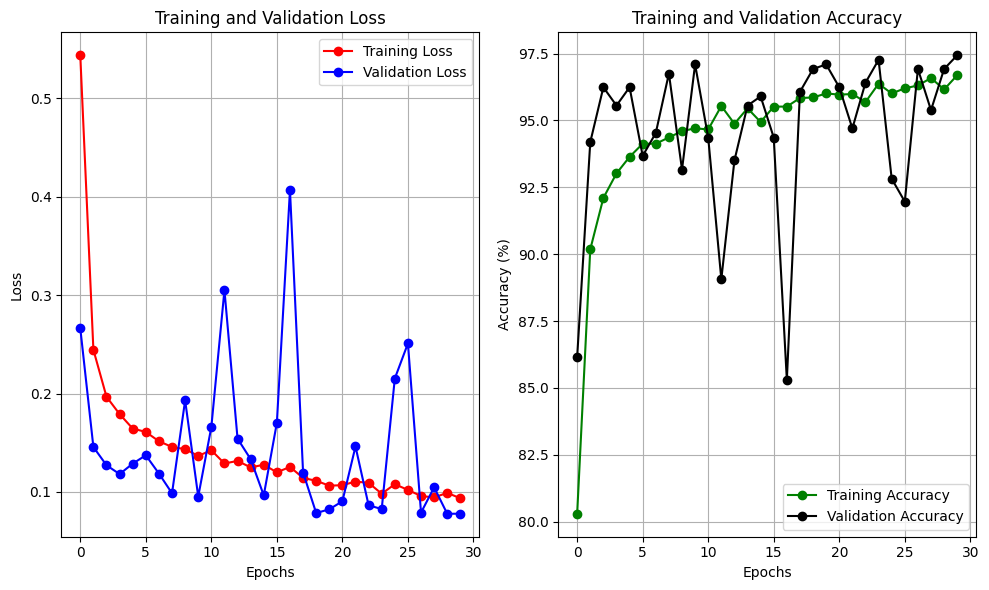

Model saved


withDropOutLayer(
  (conv_relu_pool_stack): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Dropout(p=0.8, inplace=False)
    (8): Linear(in_features=50176, out_features=2, bias=True)
  )
)

In [ ]:
test_improvements(model_with_dropout, default_config, training_dataloader, validation_dataloader, testing_dataloader, device, "chest_xray_model_withoutdropout")
#Validation accuracy with dropout: 97.4%, sensitivity: 98.6%

In [ ]:
"""
Learning rate scheduler -- improved convergence + dynamic adjustment
LR scheduling allows for more effective convergence and implements adaptive learning
The training function needs to be adjusted to implement the scheduler, and the SimpleModel() will be used
"""

model_lr_scheduler = SimpleModel()
model_lr_scheduler.to(device)

#Tried out different learning rate schedulers to check performance
optimizer_lr_sched = optim.SGD(model_lr_scheduler.parameters(), lr=0.01)

#scheduler = optim.lr_scheduler.StepLR(optimizer_lr_sched, step_size=2, gamma=0.5) #--- lr scheduler test accuracy = 93.19%
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_lr_sched, mode='min', factor=0.5, patience=2) #--- lr scheduler test accuracy = 92.84%
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_lr_sched, T_max=30)

def train_model_lr_scheduler(model, train_loader, val_loader, config=default_config, device='cuda', use_wandb=True):

    train_losses = []
    train_accuracies = []
    all_outputs_train = []
    all_labels_train = []
    train_class_accuracies = []
    train_sensitivities = []
    train_specificities = []

    val_losses = []
    val_accuracies = []
    all_outputs_val = []
    all_labels_val = []
    val_class_accuracies = []
    val_sensitivities = []
    val_specificities = []


    #set optimizer based on config input
    if config['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    elif config['optimizer'] == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'])

    loss_function = config['loss_function']

    model.to(device)

    for epoch in range(config["num_epochs"]):
        model.train()

        loss_tracker = 0.0
        prediction_tracker = 0
        number_samples = 0

        for images, labels in tqdm(train_loader, desc="Training", unit="batch"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_function(outputs, labels)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_tracker += loss.item()
            _, predicted = torch.max(outputs, 1)
            prediction_tracker += (predicted == labels).sum().item()
            number_samples += labels.size(0)

            all_outputs_train.append(outputs)
            all_labels_train.append(labels)

        # average loss & accuracy for epoch - training
        train_loss = loss_tracker / len(train_loader)
        train_accuracy = prediction_tracker / number_samples * 100

        #calculate class accuracy
        all_outputs_train = torch.cat(all_outputs_train)
        all_labels_train = torch.cat(all_labels_train)
        train_class_accuracy = calculate_class_accuracy(all_outputs_train, all_labels_train)

        train_sensitivity, train_specificity = calculate_sensitivity_specificity(all_outputs_train, all_labels_train)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        train_class_accuracies.append(train_class_accuracy)
        train_sensitivities.append(train_sensitivity)
        train_specificities.append(train_specificity)

        if use_wandb:
            wandb.log({'Train Loss': train_loss, 'Train Accuracy': train_accuracy, 'Train Class Accuracy':train_class_accuracy,
                       'Train Sensitivity': train_sensitivity, 'Train Specificity': train_specificity})

        #end of training, start evaluation
        model.eval()

        loss_tracker_val = 0.0
        prediction_tracker_val = 0
        number_samples_val = 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validating", unit="batch"):
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                val_loss = loss_function(outputs, labels)
                loss_tracker_val += val_loss.item()

                _, predicted_val = torch.max(outputs, 1)
                prediction_tracker_val += (predicted_val == labels).sum().item()
                number_samples_val += labels.size(0)

                all_outputs_val.append(outputs)
                all_labels_val.append(labels)

        # average loss & accuracy for epoch - validation
        val_loss_avg = loss_tracker_val / len(val_loader)
        val_accuracy = prediction_tracker_val / number_samples_val * 100

        all_outputs_val = torch.cat(all_outputs_val)
        all_labels_val = torch.cat(all_labels_val)
        val_class_accuracy = calculate_class_accuracy(all_outputs_val, all_labels_val)
        val_sensitivity, val_specificity = calculate_sensitivity_specificity(all_outputs_val, all_labels_val)

        val_losses.append(val_loss_avg)
        val_accuracies.append(val_accuracy)
        val_class_accuracies.append(val_class_accuracy)
        val_sensitivities.append(val_sensitivity)
        val_specificities.append(val_specificity)

        if use_wandb:
            wandb.log({'Validation Loss': val_loss_avg, 'Validation Accuracy': val_accuracy, 'Validation Class Accuracy':val_class_accuracy,
                       'Validation Sensitivity': val_sensitivity, 'Validation Specificity': val_specificity})

        train_accuracy_normal, train_accuracy_pneumonia = train_class_accuracy
        val_accuracy_normal, val_accuracy_pneumonia = val_class_accuracy

        print(f"Epoch [{epoch + 1}/{config['num_epochs']}] - "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% - "
              f"Val Loss: {val_loss_avg:.4f}, Val Accuracy: {val_accuracy:.2f}% - "
              f"Train Normal Accuracy: {train_accuracy_normal:.2f}%, Train Pneumonia Accuracy: {train_accuracy_pneumonia:.2f}% - "
              f"Val Normal Accuracy: {val_accuracy_normal:.2f}%, Val Pneumonia Accuracy: {val_accuracy_pneumonia:.2f}%")

        #set as empty lists again for next epoch
        all_outputs_train = []
        all_labels_train = []
        all_outputs_val = []
        all_labels_val = []

        scheduler.step(val_loss_avg) #ADDED this line to apply lr scheduler
        #scheduler.step()

    return train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies

def test_improvements_lr(model, config, training_dataloader, validation_dataloader, testing_dataloader, device, saved_path="chest_xray_model.pth"):
  wandb.init(project="xrays_coursework", entity="julievanl-ucl")

  """
  A seperate improvement training loop which uses the training loop including the scheduler step
  """

  # Train the model
  train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies = train_model_lr_scheduler(
      model, training_dataloader, validation_dataloader, config, device, use_wandb=True)

  # Plot training curves
  plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies)

  # Save the model
  torch.save(model.state_dict(), saved_path)
  print("Model saved")

  wandb.finish()

  return model

Validating: 100%|██████████| 10/10 [00:03<00:00,  2.90batch/s]
c:\Users\alexf\NonSynced Area\Coursework DeepRep\venv\Lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
c:\Users\alexf\NonSynced Area\Coursework DeepRep\venv\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue 

Epoch [1/30] - Train Loss: 0.3969, Train Accuracy: 84.27% - Val Loss: 0.2638, Val Accuracy: 88.03% - Train Normal Accuracy: 57.90%, Train Pneumonia Accuracy: 94.03% - Val Normal Accuracy: 98.10%, Val Pneumonia Accuracy: 84.31%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.70batch/s]


Epoch [2/30] - Train Loss: 0.2170, Train Accuracy: 91.42% - Val Loss: 0.1289, Val Accuracy: 93.85% - Train Normal Accuracy: 81.36%, Train Pneumonia Accuracy: 95.14% - Val Normal Accuracy: 80.38%, Val Pneumonia Accuracy: 98.83%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.65batch/s]


Epoch [3/30] - Train Loss: 0.1781, Train Accuracy: 92.87% - Val Loss: 0.1295, Val Accuracy: 93.33% - Train Normal Accuracy: 83.73%, Train Pneumonia Accuracy: 96.26% - Val Normal Accuracy: 77.85%, Val Pneumonia Accuracy: 99.06%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.79batch/s]


Epoch [4/30] - Train Loss: 0.1691, Train Accuracy: 93.70% - Val Loss: 0.1097, Val Accuracy: 96.41% - Train Normal Accuracy: 86.10%, Train Pneumonia Accuracy: 96.52% - Val Normal Accuracy: 94.94%, Val Pneumonia Accuracy: 96.96%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.72batch/s]


Epoch [5/30] - Train Loss: 0.1556, Train Accuracy: 94.24% - Val Loss: 0.1130, Val Accuracy: 94.70% - Train Normal Accuracy: 86.97%, Train Pneumonia Accuracy: 96.93% - Val Normal Accuracy: 83.54%, Val Pneumonia Accuracy: 98.83%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.66batch/s]


Epoch [6/30] - Train Loss: 0.1436, Train Accuracy: 94.53% - Val Loss: 0.1243, Val Accuracy: 95.04% - Train Normal Accuracy: 87.84%, Train Pneumonia Accuracy: 97.02% - Val Normal Accuracy: 96.20%, Val Pneumonia Accuracy: 94.61%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.71batch/s]


Epoch [7/30] - Train Loss: 0.1350, Train Accuracy: 94.92% - Val Loss: 0.1050, Val Accuracy: 95.90% - Train Normal Accuracy: 88.63%, Train Pneumonia Accuracy: 97.25% - Val Normal Accuracy: 95.57%, Val Pneumonia Accuracy: 96.02%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.80batch/s]


Epoch [8/30] - Train Loss: 0.1388, Train Accuracy: 94.60% - Val Loss: 0.0940, Val Accuracy: 95.73% - Train Normal Accuracy: 88.55%, Train Pneumonia Accuracy: 96.84% - Val Normal Accuracy: 89.24%, Val Pneumonia Accuracy: 98.13%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.54batch/s]


Epoch [9/30] - Train Loss: 0.1350, Train Accuracy: 95.09% - Val Loss: 0.1061, Val Accuracy: 96.41% - Train Normal Accuracy: 89.34%, Train Pneumonia Accuracy: 97.22% - Val Normal Accuracy: 96.84%, Val Pneumonia Accuracy: 96.25%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.73batch/s]


Epoch [10/30] - Train Loss: 0.1284, Train Accuracy: 95.52% - Val Loss: 0.0901, Val Accuracy: 97.09% - Train Normal Accuracy: 89.97%, Train Pneumonia Accuracy: 97.57% - Val Normal Accuracy: 93.04%, Val Pneumonia Accuracy: 98.59%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.80batch/s]


Epoch [11/30] - Train Loss: 0.1191, Train Accuracy: 95.58% - Val Loss: 0.1367, Val Accuracy: 93.50% - Train Normal Accuracy: 90.28%, Train Pneumonia Accuracy: 97.54% - Val Normal Accuracy: 96.84%, Val Pneumonia Accuracy: 92.27%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.67batch/s]


Epoch [12/30] - Train Loss: 0.1194, Train Accuracy: 95.47% - Val Loss: 0.1057, Val Accuracy: 95.04% - Train Normal Accuracy: 90.13%, Train Pneumonia Accuracy: 97.45% - Val Normal Accuracy: 84.18%, Val Pneumonia Accuracy: 99.06%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.81batch/s]


Epoch [13/30] - Train Loss: 0.1178, Train Accuracy: 95.52% - Val Loss: 0.1935, Val Accuracy: 91.11% - Train Normal Accuracy: 90.44%, Train Pneumonia Accuracy: 97.40% - Val Normal Accuracy: 67.09%, Val Pneumonia Accuracy: 100.00%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.49batch/s]


Epoch [14/30] - Train Loss: 0.1116, Train Accuracy: 96.03% - Val Loss: 0.0892, Val Accuracy: 97.09% - Train Normal Accuracy: 91.15%, Train Pneumonia Accuracy: 97.83% - Val Normal Accuracy: 96.20%, Val Pneumonia Accuracy: 97.42%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.32batch/s]


Epoch [15/30] - Train Loss: 0.1103, Train Accuracy: 95.99% - Val Loss: 0.0804, Val Accuracy: 97.09% - Train Normal Accuracy: 91.31%, Train Pneumonia Accuracy: 97.72% - Val Normal Accuracy: 93.67%, Val Pneumonia Accuracy: 98.36%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.65batch/s]


Epoch [16/30] - Train Loss: 0.1162, Train Accuracy: 95.62% - Val Loss: 0.0879, Val Accuracy: 96.24% - Train Normal Accuracy: 90.60%, Train Pneumonia Accuracy: 97.48% - Val Normal Accuracy: 88.61%, Val Pneumonia Accuracy: 99.06%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.69batch/s]


Epoch [17/30] - Train Loss: 0.1029, Train Accuracy: 96.33% - Val Loss: 0.4914, Val Accuracy: 80.68% - Train Normal Accuracy: 91.79%, Train Pneumonia Accuracy: 98.01% - Val Normal Accuracy: 99.37%, Val Pneumonia Accuracy: 73.77%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.67batch/s]


Epoch [18/30] - Train Loss: 0.1109, Train Accuracy: 95.96% - Val Loss: 0.0903, Val Accuracy: 95.73% - Train Normal Accuracy: 91.63%, Train Pneumonia Accuracy: 97.57% - Val Normal Accuracy: 86.71%, Val Pneumonia Accuracy: 99.06%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.65batch/s]


Epoch [19/30] - Train Loss: 0.1051, Train Accuracy: 96.43% - Val Loss: 0.1213, Val Accuracy: 94.87% - Train Normal Accuracy: 92.18%, Train Pneumonia Accuracy: 98.01% - Val Normal Accuracy: 97.47%, Val Pneumonia Accuracy: 93.91%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.72batch/s]


Epoch [20/30] - Train Loss: 0.0977, Train Accuracy: 96.35% - Val Loss: 0.2299, Val Accuracy: 90.60% - Train Normal Accuracy: 91.71%, Train Pneumonia Accuracy: 98.07% - Val Normal Accuracy: 98.73%, Val Pneumonia Accuracy: 87.59%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.96batch/s]


Epoch [21/30] - Train Loss: 0.0931, Train Accuracy: 96.58% - Val Loss: 0.0761, Val Accuracy: 97.09% - Train Normal Accuracy: 92.97%, Train Pneumonia Accuracy: 97.92% - Val Normal Accuracy: 93.04%, Val Pneumonia Accuracy: 98.59%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.67batch/s]


Epoch [22/30] - Train Loss: 0.0968, Train Accuracy: 96.46% - Val Loss: 0.1283, Val Accuracy: 94.19% - Train Normal Accuracy: 92.42%, Train Pneumonia Accuracy: 97.95% - Val Normal Accuracy: 80.38%, Val Pneumonia Accuracy: 99.30%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.54batch/s]


Epoch [23/30] - Train Loss: 0.0954, Train Accuracy: 96.61% - Val Loss: 0.0809, Val Accuracy: 96.75% - Train Normal Accuracy: 92.50%, Train Pneumonia Accuracy: 98.13% - Val Normal Accuracy: 94.94%, Val Pneumonia Accuracy: 97.42%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.56batch/s]


Epoch [24/30] - Train Loss: 0.0926, Train Accuracy: 96.71% - Val Loss: 0.1540, Val Accuracy: 93.50% - Train Normal Accuracy: 92.73%, Train Pneumonia Accuracy: 98.19% - Val Normal Accuracy: 97.47%, Val Pneumonia Accuracy: 92.04%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.65batch/s]


Epoch [25/30] - Train Loss: 0.0855, Train Accuracy: 96.86% - Val Loss: 0.0759, Val Accuracy: 96.92% - Train Normal Accuracy: 93.13%, Train Pneumonia Accuracy: 98.24% - Val Normal Accuracy: 92.41%, Val Pneumonia Accuracy: 98.59%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.58batch/s]


Epoch [26/30] - Train Loss: 0.0869, Train Accuracy: 96.65% - Val Loss: 0.0876, Val Accuracy: 96.58% - Train Normal Accuracy: 92.97%, Train Pneumonia Accuracy: 98.01% - Val Normal Accuracy: 96.20%, Val Pneumonia Accuracy: 96.72%


Validating: 100%|██████████| 10/10 [00:04<00:00,  2.48batch/s]


Epoch [27/30] - Train Loss: 0.0812, Train Accuracy: 97.27% - Val Loss: 0.0866, Val Accuracy: 96.58% - Train Normal Accuracy: 94.23%, Train Pneumonia Accuracy: 98.39% - Val Normal Accuracy: 96.84%, Val Pneumonia Accuracy: 96.49%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.72batch/s]


Epoch [28/30] - Train Loss: 0.0827, Train Accuracy: 96.80% - Val Loss: 0.1367, Val Accuracy: 93.85% - Train Normal Accuracy: 93.21%, Train Pneumonia Accuracy: 98.13% - Val Normal Accuracy: 97.47%, Val Pneumonia Accuracy: 92.51%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.89batch/s]


Epoch [29/30] - Train Loss: 0.0831, Train Accuracy: 96.82% - Val Loss: 0.1107, Val Accuracy: 95.21% - Train Normal Accuracy: 93.29%, Train Pneumonia Accuracy: 98.13% - Val Normal Accuracy: 97.47%, Val Pneumonia Accuracy: 94.38%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.94batch/s]


Epoch [30/30] - Train Loss: 0.0763, Train Accuracy: 97.18% - Val Loss: 0.0754, Val Accuracy: 97.44% - Train Normal Accuracy: 94.08%, Train Pneumonia Accuracy: 98.33% - Val Normal Accuracy: 92.41%, Val Pneumonia Accuracy: 99.30%


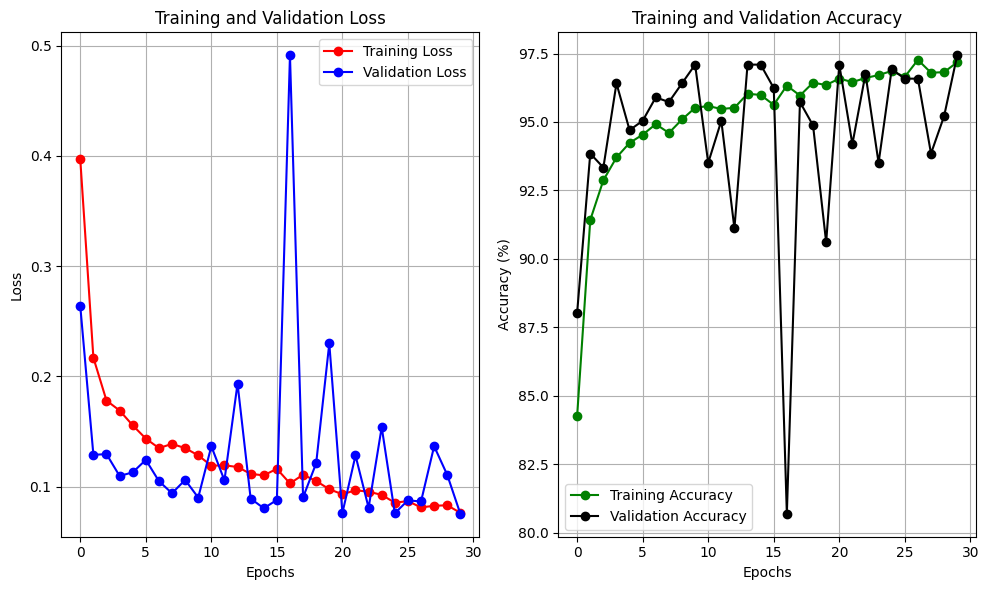

Model saved


SimpleModel(
  (conv_relu_pool_stack): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=50176, out_features=2, bias=True)
  )
)

In [ ]:
test_improvements_lr(model_lr_scheduler, default_config, training_dataloader, validation_dataloader, testing_dataloader, device, "chest_xray_model_lrscheduler")
#Validation accuracy = 97.4%, sensitivity: 99.3%

In [ ]:
"""
Weighted sampling to account for the minority class (normal)
Since the normal class has less images than the Pneumonia class, the model might be biased towards the Pneumonia class

"""

def weighted_sampling(dataset):
    #with data visualisation we already got our class sizes
    targets = [label for _, label in dataset]
    class_weights = [1/1266, 1/3418] #known from stats in beginning of notebook, no need to calculate again
    weights = [class_weights[label] for label in targets]
    sampler = WeightedRandomSampler(weights, len(weights))
    return sampler

sampler = weighted_sampling(training_data)
train_loader_sampled = DataLoader(training_data, batch_size=batch_size, sampler=sampler)

model_sampledclass = SimpleModel()
model_sampledclass.to(device)

Validating: 100%|██████████| 10/10 [00:05<00:00,  1.85batch/s]


Epoch [1/30] - Train Loss: 0.5096, Train Accuracy: 79.23% - Val Loss: 0.2110, Val Accuracy: 89.40% - Train Normal Accuracy: 83.97%, Train Pneumonia Accuracy: 74.29% - Val Normal Accuracy: 61.39%, Val Pneumonia Accuracy: 99.77%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.70batch/s]


Epoch [2/30] - Train Loss: 0.2445, Train Accuracy: 89.86% - Val Loss: 0.1803, Val Accuracy: 92.31% - Train Normal Accuracy: 89.40%, Train Pneumonia Accuracy: 90.31% - Val Normal Accuracy: 96.84%, Val Pneumonia Accuracy: 90.63%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.68batch/s]


Epoch [3/30] - Train Loss: 0.1855, Train Accuracy: 93.15% - Val Loss: 0.1436, Val Accuracy: 94.70% - Train Normal Accuracy: 92.90%, Train Pneumonia Accuracy: 93.41% - Val Normal Accuracy: 98.10%, Val Pneumonia Accuracy: 93.44%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.86batch/s]


Epoch [4/30] - Train Loss: 0.1973, Train Accuracy: 92.57% - Val Loss: 0.1231, Val Accuracy: 94.36% - Train Normal Accuracy: 92.57%, Train Pneumonia Accuracy: 92.57% - Val Normal Accuracy: 81.01%, Val Pneumonia Accuracy: 99.30%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.76batch/s]


Epoch [5/30] - Train Loss: 0.1749, Train Accuracy: 93.13% - Val Loss: 0.1855, Val Accuracy: 91.79% - Train Normal Accuracy: 92.94%, Train Pneumonia Accuracy: 93.31% - Val Normal Accuracy: 98.73%, Val Pneumonia Accuracy: 89.23%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.91batch/s]


Epoch [6/30] - Train Loss: 0.1590, Train Accuracy: 93.72% - Val Loss: 0.1688, Val Accuracy: 92.31% - Train Normal Accuracy: 93.19%, Train Pneumonia Accuracy: 94.23% - Val Normal Accuracy: 98.73%, Val Pneumonia Accuracy: 89.93%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.74batch/s]


Epoch [7/30] - Train Loss: 0.1530, Train Accuracy: 94.26% - Val Loss: 0.0945, Val Accuracy: 95.90% - Train Normal Accuracy: 93.81%, Train Pneumonia Accuracy: 94.71% - Val Normal Accuracy: 87.34%, Val Pneumonia Accuracy: 99.06%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.74batch/s]


Epoch [8/30] - Train Loss: 0.1668, Train Accuracy: 93.77% - Val Loss: 0.2673, Val Accuracy: 88.38% - Train Normal Accuracy: 93.12%, Train Pneumonia Accuracy: 94.41% - Val Normal Accuracy: 56.96%, Val Pneumonia Accuracy: 100.00%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.83batch/s]


Epoch [9/30] - Train Loss: 0.1473, Train Accuracy: 94.94% - Val Loss: 0.1356, Val Accuracy: 94.53% - Train Normal Accuracy: 94.65%, Train Pneumonia Accuracy: 95.24% - Val Normal Accuracy: 97.47%, Val Pneumonia Accuracy: 93.44%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.77batch/s]


Epoch [10/30] - Train Loss: 0.1323, Train Accuracy: 95.35% - Val Loss: 0.1768, Val Accuracy: 92.14% - Train Normal Accuracy: 95.41%, Train Pneumonia Accuracy: 95.28% - Val Normal Accuracy: 98.73%, Val Pneumonia Accuracy: 89.70%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.75batch/s]


Epoch [11/30] - Train Loss: 0.1387, Train Accuracy: 94.73% - Val Loss: 0.2303, Val Accuracy: 90.77% - Train Normal Accuracy: 94.65%, Train Pneumonia Accuracy: 94.80% - Val Normal Accuracy: 99.37%, Val Pneumonia Accuracy: 87.59%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.78batch/s]


Epoch [12/30] - Train Loss: 0.1322, Train Accuracy: 94.90% - Val Loss: 0.4119, Val Accuracy: 82.56% - Train Normal Accuracy: 95.02%, Train Pneumonia Accuracy: 94.77% - Val Normal Accuracy: 100.00%, Val Pneumonia Accuracy: 76.11%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.75batch/s]


Epoch [13/30] - Train Loss: 0.1354, Train Accuracy: 94.94% - Val Loss: 0.4928, Val Accuracy: 80.34% - Train Normal Accuracy: 94.71%, Train Pneumonia Accuracy: 95.17% - Val Normal Accuracy: 100.00%, Val Pneumonia Accuracy: 73.07%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.67batch/s]


Epoch [14/30] - Train Loss: 0.1252, Train Accuracy: 95.45% - Val Loss: 0.0928, Val Accuracy: 96.58% - Train Normal Accuracy: 95.26%, Train Pneumonia Accuracy: 95.64% - Val Normal Accuracy: 95.57%, Val Pneumonia Accuracy: 96.96%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.70batch/s]


Epoch [15/30] - Train Loss: 0.1078, Train Accuracy: 96.33% - Val Loss: 0.0830, Val Accuracy: 96.75% - Train Normal Accuracy: 96.29%, Train Pneumonia Accuracy: 96.37% - Val Normal Accuracy: 95.57%, Val Pneumonia Accuracy: 97.19%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.84batch/s]


Epoch [16/30] - Train Loss: 0.1148, Train Accuracy: 95.64% - Val Loss: 0.1777, Val Accuracy: 92.31% - Train Normal Accuracy: 95.36%, Train Pneumonia Accuracy: 95.92% - Val Normal Accuracy: 98.10%, Val Pneumonia Accuracy: 90.16%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.75batch/s]


Epoch [17/30] - Train Loss: 0.1220, Train Accuracy: 95.56% - Val Loss: 0.1480, Val Accuracy: 92.99% - Train Normal Accuracy: 95.50%, Train Pneumonia Accuracy: 95.62% - Val Normal Accuracy: 98.10%, Val Pneumonia Accuracy: 91.10%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.75batch/s]


Epoch [18/30] - Train Loss: 0.1068, Train Accuracy: 96.16% - Val Loss: 0.1137, Val Accuracy: 95.04% - Train Normal Accuracy: 96.42%, Train Pneumonia Accuracy: 95.88% - Val Normal Accuracy: 97.47%, Val Pneumonia Accuracy: 94.15%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.81batch/s]


Epoch [19/30] - Train Loss: 0.1046, Train Accuracy: 96.20% - Val Loss: 0.0808, Val Accuracy: 96.75% - Train Normal Accuracy: 95.87%, Train Pneumonia Accuracy: 96.53% - Val Normal Accuracy: 95.57%, Val Pneumonia Accuracy: 97.19%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.68batch/s]


Epoch [20/30] - Train Loss: 0.1110, Train Accuracy: 95.86% - Val Loss: 0.1118, Val Accuracy: 94.87% - Train Normal Accuracy: 95.79%, Train Pneumonia Accuracy: 95.92% - Val Normal Accuracy: 97.47%, Val Pneumonia Accuracy: 93.91%


Validating: 100%|██████████| 10/10 [00:03<00:00,  3.12batch/s]


Epoch [21/30] - Train Loss: 0.1000, Train Accuracy: 96.26% - Val Loss: 0.1027, Val Accuracy: 95.56% - Train Normal Accuracy: 96.27%, Train Pneumonia Accuracy: 96.26% - Val Normal Accuracy: 96.84%, Val Pneumonia Accuracy: 95.08%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.77batch/s]


Epoch [22/30] - Train Loss: 0.0850, Train Accuracy: 97.05% - Val Loss: 0.0970, Val Accuracy: 95.21% - Train Normal Accuracy: 96.95%, Train Pneumonia Accuracy: 97.15% - Val Normal Accuracy: 96.84%, Val Pneumonia Accuracy: 94.61%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.78batch/s]


Epoch [23/30] - Train Loss: 0.0866, Train Accuracy: 96.99% - Val Loss: 0.1256, Val Accuracy: 94.36% - Train Normal Accuracy: 97.24%, Train Pneumonia Accuracy: 96.72% - Val Normal Accuracy: 97.47%, Val Pneumonia Accuracy: 93.21%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.66batch/s]


Epoch [24/30] - Train Loss: 0.0952, Train Accuracy: 96.71% - Val Loss: 0.1493, Val Accuracy: 93.33% - Train Normal Accuracy: 96.74%, Train Pneumonia Accuracy: 96.69% - Val Normal Accuracy: 97.47%, Val Pneumonia Accuracy: 91.80%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.76batch/s]


Epoch [25/30] - Train Loss: 0.0914, Train Accuracy: 96.78% - Val Loss: 0.0952, Val Accuracy: 96.07% - Train Normal Accuracy: 96.82%, Train Pneumonia Accuracy: 96.74% - Val Normal Accuracy: 97.47%, Val Pneumonia Accuracy: 95.55%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.76batch/s]


Epoch [26/30] - Train Loss: 0.0972, Train Accuracy: 96.56% - Val Loss: 0.1146, Val Accuracy: 95.04% - Train Normal Accuracy: 96.68%, Train Pneumonia Accuracy: 96.45% - Val Normal Accuracy: 98.10%, Val Pneumonia Accuracy: 93.91%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.71batch/s]


Epoch [27/30] - Train Loss: 0.0919, Train Accuracy: 96.63% - Val Loss: 0.0992, Val Accuracy: 95.90% - Train Normal Accuracy: 96.96%, Train Pneumonia Accuracy: 96.27% - Val Normal Accuracy: 97.47%, Val Pneumonia Accuracy: 95.32%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.80batch/s]


Epoch [28/30] - Train Loss: 0.0867, Train Accuracy: 96.84% - Val Loss: 0.0754, Val Accuracy: 96.92% - Train Normal Accuracy: 97.09%, Train Pneumonia Accuracy: 96.59% - Val Normal Accuracy: 95.57%, Val Pneumonia Accuracy: 97.42%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.78batch/s]


Epoch [29/30] - Train Loss: 0.0856, Train Accuracy: 97.20% - Val Loss: 0.3250, Val Accuracy: 86.50% - Train Normal Accuracy: 97.52%, Train Pneumonia Accuracy: 96.88% - Val Normal Accuracy: 50.00%, Val Pneumonia Accuracy: 100.00%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.92batch/s]


Epoch [30/30] - Train Loss: 0.1197, Train Accuracy: 96.07% - Val Loss: 0.0835, Val Accuracy: 96.58% - Train Normal Accuracy: 96.22%, Train Pneumonia Accuracy: 95.92% - Val Normal Accuracy: 96.20%, Val Pneumonia Accuracy: 96.72%


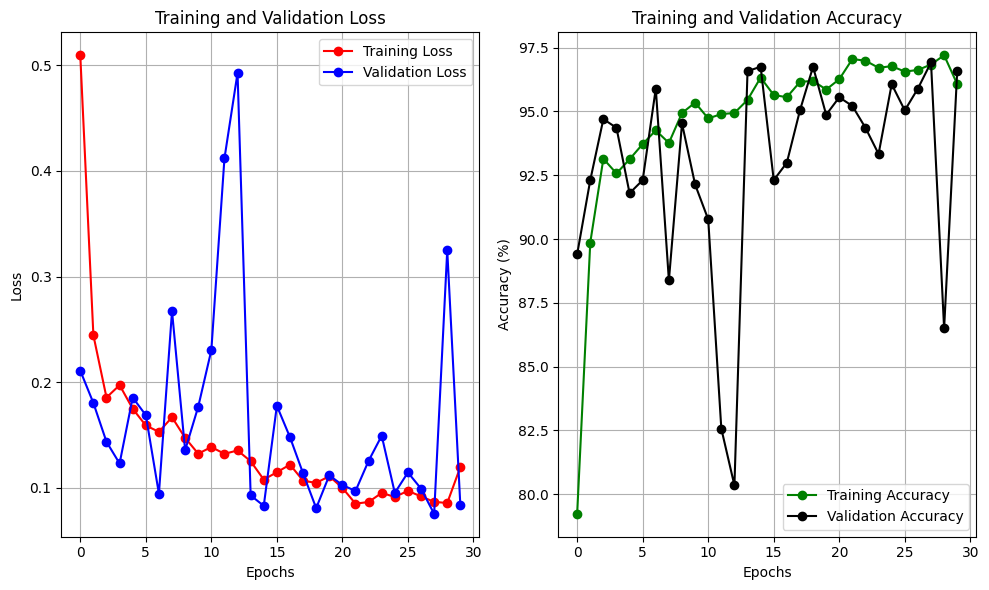

Model saved


SimpleModel(
  (conv_relu_pool_stack): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=50176, out_features=2, bias=True)
  )
)

In [ ]:
test_improvements(model_sampledclass, default_config, train_loader_sampled, validation_dataloader, testing_dataloader,  device, "chest_xray_model_sampledtraining.pth")
# accuracy 96.6%, sensitivity: 96.7%

In [ ]:
"""
Initializing weights can help avoid exploding/vanise, local minima
He initialization works well with ReLu
"""

class withWeightsInitialized(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv_relu_pool_stack = nn.Sequential(
            #layer 1
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #224 -> 112

            #layer 2
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #112 -> 56

            nn.Flatten(),
            nn.Linear(16 * 56 * 56, 2)
        )

        self.apply(self._initialize_weights)

    def _initialize_weights(self, module):
        if isinstance(module, nn.Conv2d):
            nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Linear):
            # He initialization for Linear layer
            nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
            if module.bias is not None:
                nn.init.zeros_(module.bias)

    def forward(self, x):
        x = self.conv_relu_pool_stack(x)
        return x

model_with_weights = withWeightsInitialized()
model_with_weights.to(device)

Training:   0%|          | 0/74 [00:00<?, ?batch/s]

Validating: 100%|██████████| 10/10 [00:03<00:00,  2.80batch/s]


Epoch [1/30] - Train Loss: 1.3265, Train Accuracy: 84.74% - Val Loss: 0.2353, Val Accuracy: 88.21% - Train Normal Accuracy: 62.48%, Train Pneumonia Accuracy: 92.98% - Val Normal Accuracy: 60.76%, Val Pneumonia Accuracy: 98.36%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.76batch/s]


Epoch [2/30] - Train Loss: 0.1957, Train Accuracy: 92.53% - Val Loss: 0.1489, Val Accuracy: 95.04% - Train Normal Accuracy: 83.81%, Train Pneumonia Accuracy: 95.76% - Val Normal Accuracy: 92.41%, Val Pneumonia Accuracy: 96.02%


Validating: 100%|██████████| 10/10 [00:03<00:00,  3.03batch/s]


Epoch [3/30] - Train Loss: 0.1499, Train Accuracy: 94.68% - Val Loss: 0.3946, Val Accuracy: 82.22% - Train Normal Accuracy: 88.63%, Train Pneumonia Accuracy: 96.93% - Val Normal Accuracy: 34.18%, Val Pneumonia Accuracy: 100.00%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.76batch/s]


Epoch [4/30] - Train Loss: 0.1290, Train Accuracy: 94.98% - Val Loss: 0.1105, Val Accuracy: 94.87% - Train Normal Accuracy: 89.02%, Train Pneumonia Accuracy: 97.19% - Val Normal Accuracy: 86.08%, Val Pneumonia Accuracy: 98.13%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.77batch/s]


Epoch [5/30] - Train Loss: 0.1166, Train Accuracy: 95.52% - Val Loss: 0.1094, Val Accuracy: 94.70% - Train Normal Accuracy: 90.76%, Train Pneumonia Accuracy: 97.28% - Val Normal Accuracy: 84.18%, Val Pneumonia Accuracy: 98.59%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.77batch/s]


Epoch [6/30] - Train Loss: 0.1049, Train Accuracy: 96.31% - Val Loss: 0.1563, Val Accuracy: 94.19% - Train Normal Accuracy: 92.42%, Train Pneumonia Accuracy: 97.75% - Val Normal Accuracy: 98.73%, Val Pneumonia Accuracy: 92.51%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.75batch/s]


Epoch [7/30] - Train Loss: 0.0983, Train Accuracy: 96.14% - Val Loss: 0.0875, Val Accuracy: 96.41% - Train Normal Accuracy: 91.71%, Train Pneumonia Accuracy: 97.78% - Val Normal Accuracy: 92.41%, Val Pneumonia Accuracy: 97.89%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.73batch/s]


Epoch [8/30] - Train Loss: 0.0867, Train Accuracy: 96.97% - Val Loss: 0.0956, Val Accuracy: 95.73% - Train Normal Accuracy: 93.21%, Train Pneumonia Accuracy: 98.36% - Val Normal Accuracy: 87.34%, Val Pneumonia Accuracy: 98.83%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.68batch/s]


Epoch [9/30] - Train Loss: 0.0755, Train Accuracy: 97.46% - Val Loss: 0.0836, Val Accuracy: 96.58% - Train Normal Accuracy: 94.55%, Train Pneumonia Accuracy: 98.54% - Val Normal Accuracy: 93.04%, Val Pneumonia Accuracy: 97.89%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.74batch/s]


Epoch [10/30] - Train Loss: 0.0902, Train Accuracy: 96.73% - Val Loss: 0.2202, Val Accuracy: 93.16% - Train Normal Accuracy: 92.97%, Train Pneumonia Accuracy: 98.13% - Val Normal Accuracy: 99.37%, Val Pneumonia Accuracy: 90.87%


Validating: 100%|██████████| 10/10 [00:03<00:00,  3.03batch/s]


Epoch [11/30] - Train Loss: 0.0678, Train Accuracy: 97.93% - Val Loss: 0.1902, Val Accuracy: 93.68% - Train Normal Accuracy: 95.66%, Train Pneumonia Accuracy: 98.77% - Val Normal Accuracy: 98.73%, Val Pneumonia Accuracy: 91.80%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.78batch/s]


Epoch [12/30] - Train Loss: 0.0622, Train Accuracy: 97.76% - Val Loss: 0.0993, Val Accuracy: 95.38% - Train Normal Accuracy: 95.42%, Train Pneumonia Accuracy: 98.62% - Val Normal Accuracy: 85.44%, Val Pneumonia Accuracy: 99.06%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.76batch/s]


Epoch [13/30] - Train Loss: 0.0558, Train Accuracy: 98.10% - Val Loss: 0.0776, Val Accuracy: 95.90% - Train Normal Accuracy: 95.89%, Train Pneumonia Accuracy: 98.92% - Val Normal Accuracy: 89.87%, Val Pneumonia Accuracy: 98.13%


Validating: 100%|██████████| 10/10 [00:03<00:00,  3.18batch/s]


Epoch [14/30] - Train Loss: 0.0525, Train Accuracy: 98.42% - Val Loss: 0.2934, Val Accuracy: 88.89% - Train Normal Accuracy: 96.60%, Train Pneumonia Accuracy: 99.09% - Val Normal Accuracy: 58.86%, Val Pneumonia Accuracy: 100.00%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.93batch/s]


Epoch [15/30] - Train Loss: 0.0502, Train Accuracy: 98.36% - Val Loss: 0.0899, Val Accuracy: 95.90% - Train Normal Accuracy: 96.13%, Train Pneumonia Accuracy: 99.18% - Val Normal Accuracy: 87.97%, Val Pneumonia Accuracy: 98.83%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.65batch/s]


Epoch [16/30] - Train Loss: 0.0442, Train Accuracy: 98.74% - Val Loss: 0.0817, Val Accuracy: 96.24% - Train Normal Accuracy: 97.31%, Train Pneumonia Accuracy: 99.27% - Val Normal Accuracy: 91.77%, Val Pneumonia Accuracy: 97.89%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.75batch/s]


Epoch [17/30] - Train Loss: 0.0439, Train Accuracy: 98.55% - Val Loss: 0.0789, Val Accuracy: 95.90% - Train Normal Accuracy: 97.08%, Train Pneumonia Accuracy: 99.09% - Val Normal Accuracy: 89.87%, Val Pneumonia Accuracy: 98.13%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.81batch/s]


Epoch [18/30] - Train Loss: 0.0366, Train Accuracy: 98.93% - Val Loss: 0.0982, Val Accuracy: 95.21% - Train Normal Accuracy: 97.71%, Train Pneumonia Accuracy: 99.39% - Val Normal Accuracy: 85.44%, Val Pneumonia Accuracy: 98.83%


Validating: 100%|██████████| 10/10 [00:03<00:00,  3.05batch/s]


Epoch [19/30] - Train Loss: 0.0329, Train Accuracy: 99.12% - Val Loss: 0.0817, Val Accuracy: 96.75% - Train Normal Accuracy: 97.71%, Train Pneumonia Accuracy: 99.65% - Val Normal Accuracy: 93.67%, Val Pneumonia Accuracy: 97.89%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.76batch/s]


Epoch [20/30] - Train Loss: 0.0321, Train Accuracy: 99.47% - Val Loss: 0.0921, Val Accuracy: 95.90% - Train Normal Accuracy: 98.82%, Train Pneumonia Accuracy: 99.71% - Val Normal Accuracy: 88.61%, Val Pneumonia Accuracy: 98.59%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.84batch/s]


Epoch [21/30] - Train Loss: 0.0293, Train Accuracy: 99.36% - Val Loss: 0.0848, Val Accuracy: 95.90% - Train Normal Accuracy: 98.50%, Train Pneumonia Accuracy: 99.68% - Val Normal Accuracy: 93.67%, Val Pneumonia Accuracy: 96.72%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.81batch/s]


Epoch [22/30] - Train Loss: 0.0283, Train Accuracy: 99.34% - Val Loss: 0.8087, Val Accuracy: 78.12% - Train Normal Accuracy: 98.42%, Train Pneumonia Accuracy: 99.68% - Val Normal Accuracy: 18.99%, Val Pneumonia Accuracy: 100.00%


Validating: 100%|██████████| 10/10 [00:03<00:00,  3.18batch/s]


Epoch [23/30] - Train Loss: 0.0358, Train Accuracy: 99.25% - Val Loss: 0.0816, Val Accuracy: 95.73% - Train Normal Accuracy: 98.03%, Train Pneumonia Accuracy: 99.71% - Val Normal Accuracy: 89.24%, Val Pneumonia Accuracy: 98.13%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.75batch/s]


Epoch [24/30] - Train Loss: 0.0258, Train Accuracy: 99.30% - Val Loss: 0.0848, Val Accuracy: 96.07% - Train Normal Accuracy: 98.34%, Train Pneumonia Accuracy: 99.65% - Val Normal Accuracy: 91.14%, Val Pneumonia Accuracy: 97.89%


Validating: 100%|██████████| 10/10 [00:03<00:00,  3.13batch/s]


Epoch [25/30] - Train Loss: 0.0211, Train Accuracy: 99.64% - Val Loss: 0.0806, Val Accuracy: 95.73% - Train Normal Accuracy: 98.97%, Train Pneumonia Accuracy: 99.88% - Val Normal Accuracy: 88.61%, Val Pneumonia Accuracy: 98.36%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.76batch/s]


Epoch [26/30] - Train Loss: 0.0206, Train Accuracy: 99.68% - Val Loss: 0.0853, Val Accuracy: 95.56% - Train Normal Accuracy: 98.97%, Train Pneumonia Accuracy: 99.94% - Val Normal Accuracy: 91.77%, Val Pneumonia Accuracy: 96.96%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.81batch/s]


Epoch [27/30] - Train Loss: 0.0175, Train Accuracy: 99.87% - Val Loss: 0.0823, Val Accuracy: 95.90% - Train Normal Accuracy: 99.61%, Train Pneumonia Accuracy: 99.97% - Val Normal Accuracy: 89.24%, Val Pneumonia Accuracy: 98.36%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.78batch/s]


Epoch [28/30] - Train Loss: 0.0168, Train Accuracy: 99.79% - Val Loss: 0.0854, Val Accuracy: 95.73% - Train Normal Accuracy: 99.37%, Train Pneumonia Accuracy: 99.94% - Val Normal Accuracy: 89.87%, Val Pneumonia Accuracy: 97.89%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.76batch/s]


Epoch [29/30] - Train Loss: 0.0158, Train Accuracy: 99.87% - Val Loss: 0.0871, Val Accuracy: 95.73% - Train Normal Accuracy: 99.61%, Train Pneumonia Accuracy: 99.97% - Val Normal Accuracy: 87.97%, Val Pneumonia Accuracy: 98.59%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.76batch/s]


Epoch [30/30] - Train Loss: 0.0178, Train Accuracy: 99.81% - Val Loss: 0.0873, Val Accuracy: 96.24% - Train Normal Accuracy: 99.61%, Train Pneumonia Accuracy: 99.88% - Val Normal Accuracy: 93.67%, Val Pneumonia Accuracy: 97.19%


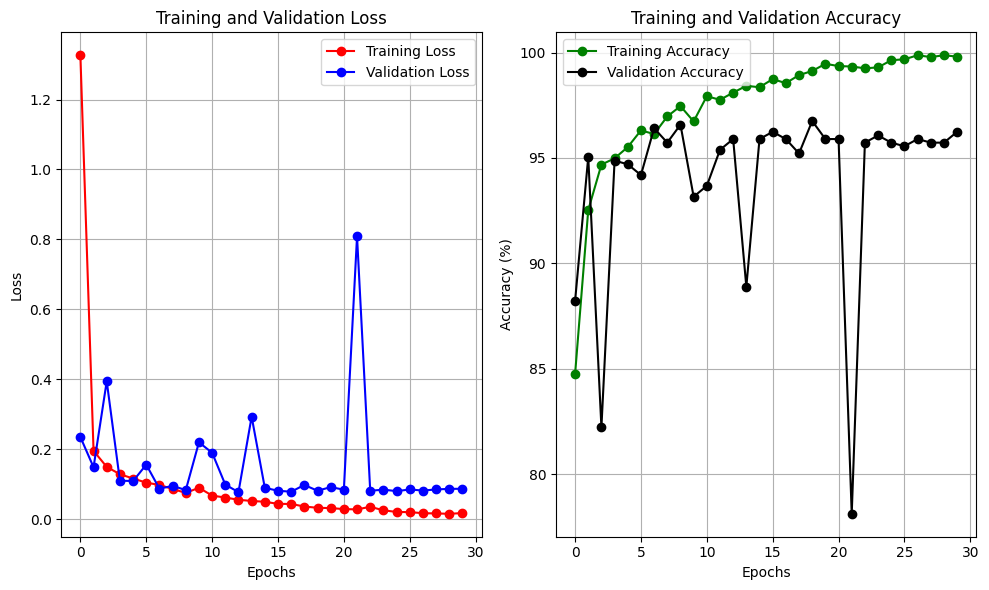

Model saved


withWeightsInitialized(
  (conv_relu_pool_stack): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=50176, out_features=2, bias=True)
  )
)

In [ ]:
test_improvements(model_with_weights, default_config, training_dataloader, validation_dataloader, testing_dataloader, device)
#test accuracy with weights: 96.2% & sensitivity: 97.1%

Tips:
* If you struggle to improve upon the baseline, but your design choices are well motivated and well implemented, and your results are well-presented and discussed, you will still receive most marks here. You will get some extra marks for improving upon baseline performance, but you will primarily be marked for making reasonable design choices.
* A small number of marks will be deducted if there are extremely obvious issues with the baseline that you do not attempt to address

## Q 4.1: Final improved model -- baseline + 3 improvements (20 marks)



You should now choose three final improvements. Explain them, implement them, train a model, and present and discuss the results.

Try to maximize performance with the final three improvements you choose (i.e., pick the three best improvements you found).

In [ ]:
test_config = {
    'optimizer': 'sgd',
    'learning_rate': 0.01,
    'batch_size': 64,
    'num_epochs': 30,
    'loss_function': nn.CrossEntropyLoss()} #cross entropy handles softmax activation

wandb: Currently logged in as: julievanl (julievanl-ucl). Use `wandb login --relogin` to force relogin


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.94batch/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com

Epoch [1/30] - Train Loss: 4.1956, Train Accuracy: 82.07% - Val Loss: 0.1450, Val Accuracy: 94.70% - Train Normal Accuracy: 66.82%, Train Pneumonia Accuracy: 87.71% - Val Normal Accuracy: 88.61%, Val Pneumonia Accuracy: 96.96%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.90batch/s]


Epoch [2/30] - Train Loss: 0.3656, Train Accuracy: 91.40% - Val Loss: 1.5592, Val Accuracy: 74.02% - Train Normal Accuracy: 83.57%, Train Pneumonia Accuracy: 94.29% - Val Normal Accuracy: 3.80%, Val Pneumonia Accuracy: 100.00%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.73batch/s]


Epoch [3/30] - Train Loss: 0.2501, Train Accuracy: 92.78% - Val Loss: 0.1036, Val Accuracy: 95.38% - Train Normal Accuracy: 85.23%, Train Pneumonia Accuracy: 95.58% - Val Normal Accuracy: 87.97%, Val Pneumonia Accuracy: 98.13%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.75batch/s]


Epoch [4/30] - Train Loss: 0.1901, Train Accuracy: 93.92% - Val Loss: 0.3175, Val Accuracy: 89.57% - Train Normal Accuracy: 87.68%, Train Pneumonia Accuracy: 96.23% - Val Normal Accuracy: 98.73%, Val Pneumonia Accuracy: 86.18%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.68batch/s]


Epoch [5/30] - Train Loss: 0.1797, Train Accuracy: 93.81% - Val Loss: 0.1005, Val Accuracy: 96.24% - Train Normal Accuracy: 88.07%, Train Pneumonia Accuracy: 95.93% - Val Normal Accuracy: 95.57%, Val Pneumonia Accuracy: 96.49%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.74batch/s]


Epoch [6/30] - Train Loss: 0.1557, Train Accuracy: 94.53% - Val Loss: 0.0970, Val Accuracy: 96.41% - Train Normal Accuracy: 88.86%, Train Pneumonia Accuracy: 96.64% - Val Normal Accuracy: 94.94%, Val Pneumonia Accuracy: 96.96%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.73batch/s]


Epoch [7/30] - Train Loss: 0.1382, Train Accuracy: 95.13% - Val Loss: 0.0909, Val Accuracy: 96.41% - Train Normal Accuracy: 89.81%, Train Pneumonia Accuracy: 97.10% - Val Normal Accuracy: 89.87%, Val Pneumonia Accuracy: 98.83%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.67batch/s]


Epoch [8/30] - Train Loss: 0.1322, Train Accuracy: 95.07% - Val Loss: 0.2270, Val Accuracy: 92.14% - Train Normal Accuracy: 89.81%, Train Pneumonia Accuracy: 97.02% - Val Normal Accuracy: 98.73%, Val Pneumonia Accuracy: 89.70%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.60batch/s]


Epoch [9/30] - Train Loss: 0.1345, Train Accuracy: 95.07% - Val Loss: 0.1117, Val Accuracy: 95.21% - Train Normal Accuracy: 90.21%, Train Pneumonia Accuracy: 96.87% - Val Normal Accuracy: 84.81%, Val Pneumonia Accuracy: 99.06%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.57batch/s]


Epoch [10/30] - Train Loss: 0.1321, Train Accuracy: 95.35% - Val Loss: 0.1353, Val Accuracy: 95.90% - Train Normal Accuracy: 90.44%, Train Pneumonia Accuracy: 97.16% - Val Normal Accuracy: 96.20%, Val Pneumonia Accuracy: 95.78%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.64batch/s]


Epoch [11/30] - Train Loss: 0.1322, Train Accuracy: 94.71% - Val Loss: 0.1084, Val Accuracy: 95.21% - Train Normal Accuracy: 89.42%, Train Pneumonia Accuracy: 96.66% - Val Normal Accuracy: 84.81%, Val Pneumonia Accuracy: 99.06%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.69batch/s]


Epoch [12/30] - Train Loss: 0.1156, Train Accuracy: 95.86% - Val Loss: 0.0987, Val Accuracy: 97.09% - Train Normal Accuracy: 91.71%, Train Pneumonia Accuracy: 97.40% - Val Normal Accuracy: 95.57%, Val Pneumonia Accuracy: 97.66%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.71batch/s]


Epoch [13/30] - Train Loss: 0.1212, Train Accuracy: 95.30% - Val Loss: 0.0958, Val Accuracy: 96.41% - Train Normal Accuracy: 90.05%, Train Pneumonia Accuracy: 97.25% - Val Normal Accuracy: 96.20%, Val Pneumonia Accuracy: 96.49%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.73batch/s]


Epoch [14/30] - Train Loss: 0.1162, Train Accuracy: 95.58% - Val Loss: 0.3480, Val Accuracy: 88.21% - Train Normal Accuracy: 91.00%, Train Pneumonia Accuracy: 97.28% - Val Normal Accuracy: 98.73%, Val Pneumonia Accuracy: 84.31%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.54batch/s]


Epoch [15/30] - Train Loss: 0.1066, Train Accuracy: 96.01% - Val Loss: 0.0833, Val Accuracy: 96.41% - Train Normal Accuracy: 91.79%, Train Pneumonia Accuracy: 97.57% - Val Normal Accuracy: 92.41%, Val Pneumonia Accuracy: 97.89%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.57batch/s]


Epoch [16/30] - Train Loss: 0.1120, Train Accuracy: 95.99% - Val Loss: 0.0881, Val Accuracy: 96.58% - Train Normal Accuracy: 91.39%, Train Pneumonia Accuracy: 97.69% - Val Normal Accuracy: 89.87%, Val Pneumonia Accuracy: 99.06%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.49batch/s]


Epoch [17/30] - Train Loss: 0.1021, Train Accuracy: 96.01% - Val Loss: 0.1064, Val Accuracy: 95.21% - Train Normal Accuracy: 91.23%, Train Pneumonia Accuracy: 97.78% - Val Normal Accuracy: 84.18%, Val Pneumonia Accuracy: 99.30%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.54batch/s]


Epoch [18/30] - Train Loss: 0.0950, Train Accuracy: 96.35% - Val Loss: 0.0874, Val Accuracy: 97.09% - Train Normal Accuracy: 92.10%, Train Pneumonia Accuracy: 97.92% - Val Normal Accuracy: 95.57%, Val Pneumonia Accuracy: 97.66%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.57batch/s]


Epoch [19/30] - Train Loss: 0.1027, Train Accuracy: 95.90% - Val Loss: 0.0857, Val Accuracy: 96.92% - Train Normal Accuracy: 91.39%, Train Pneumonia Accuracy: 97.57% - Val Normal Accuracy: 91.14%, Val Pneumonia Accuracy: 99.06%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.73batch/s]


Epoch [20/30] - Train Loss: 0.0942, Train Accuracy: 96.31% - Val Loss: 0.0925, Val Accuracy: 96.07% - Train Normal Accuracy: 92.73%, Train Pneumonia Accuracy: 97.63% - Val Normal Accuracy: 87.97%, Val Pneumonia Accuracy: 99.06%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.76batch/s]


Epoch [21/30] - Train Loss: 0.1023, Train Accuracy: 96.50% - Val Loss: 0.0961, Val Accuracy: 96.75% - Train Normal Accuracy: 92.73%, Train Pneumonia Accuracy: 97.89% - Val Normal Accuracy: 94.30%, Val Pneumonia Accuracy: 97.66%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.76batch/s]


Epoch [22/30] - Train Loss: 0.0897, Train Accuracy: 96.52% - Val Loss: 0.1079, Val Accuracy: 96.58% - Train Normal Accuracy: 92.50%, Train Pneumonia Accuracy: 98.01% - Val Normal Accuracy: 96.84%, Val Pneumonia Accuracy: 96.49%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.80batch/s]


Epoch [23/30] - Train Loss: 0.0915, Train Accuracy: 96.56% - Val Loss: 0.1132, Val Accuracy: 96.41% - Train Normal Accuracy: 92.97%, Train Pneumonia Accuracy: 97.89% - Val Normal Accuracy: 97.47%, Val Pneumonia Accuracy: 96.02%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.71batch/s]


Epoch [24/30] - Train Loss: 0.0874, Train Accuracy: 96.78% - Val Loss: 0.1028, Val Accuracy: 96.75% - Train Normal Accuracy: 93.29%, Train Pneumonia Accuracy: 98.07% - Val Normal Accuracy: 94.94%, Val Pneumonia Accuracy: 97.42%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.75batch/s]


Epoch [25/30] - Train Loss: 0.0874, Train Accuracy: 96.80% - Val Loss: 0.0899, Val Accuracy: 96.58% - Train Normal Accuracy: 93.68%, Train Pneumonia Accuracy: 97.95% - Val Normal Accuracy: 92.41%, Val Pneumonia Accuracy: 98.13%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.51batch/s]


Epoch [26/30] - Train Loss: 0.0888, Train Accuracy: 96.82% - Val Loss: 0.1086, Val Accuracy: 96.58% - Train Normal Accuracy: 92.97%, Train Pneumonia Accuracy: 98.24% - Val Normal Accuracy: 96.84%, Val Pneumonia Accuracy: 96.49%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.51batch/s]


Epoch [27/30] - Train Loss: 0.0794, Train Accuracy: 96.95% - Val Loss: 0.0941, Val Accuracy: 97.26% - Train Normal Accuracy: 93.68%, Train Pneumonia Accuracy: 98.16% - Val Normal Accuracy: 95.57%, Val Pneumonia Accuracy: 97.89%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.51batch/s]


Epoch [28/30] - Train Loss: 0.0793, Train Accuracy: 96.80% - Val Loss: 0.0950, Val Accuracy: 96.92% - Train Normal Accuracy: 93.68%, Train Pneumonia Accuracy: 97.95% - Val Normal Accuracy: 94.30%, Val Pneumonia Accuracy: 97.89%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.51batch/s]


Epoch [29/30] - Train Loss: 0.0847, Train Accuracy: 96.80% - Val Loss: 0.0835, Val Accuracy: 96.92% - Train Normal Accuracy: 92.73%, Train Pneumonia Accuracy: 98.30% - Val Normal Accuracy: 93.04%, Val Pneumonia Accuracy: 98.36%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.55batch/s]


Epoch [30/30] - Train Loss: 0.0837, Train Accuracy: 96.86% - Val Loss: 0.0889, Val Accuracy: 96.75% - Train Normal Accuracy: 93.29%, Train Pneumonia Accuracy: 98.19% - Val Normal Accuracy: 92.41%, Val Pneumonia Accuracy: 98.36%


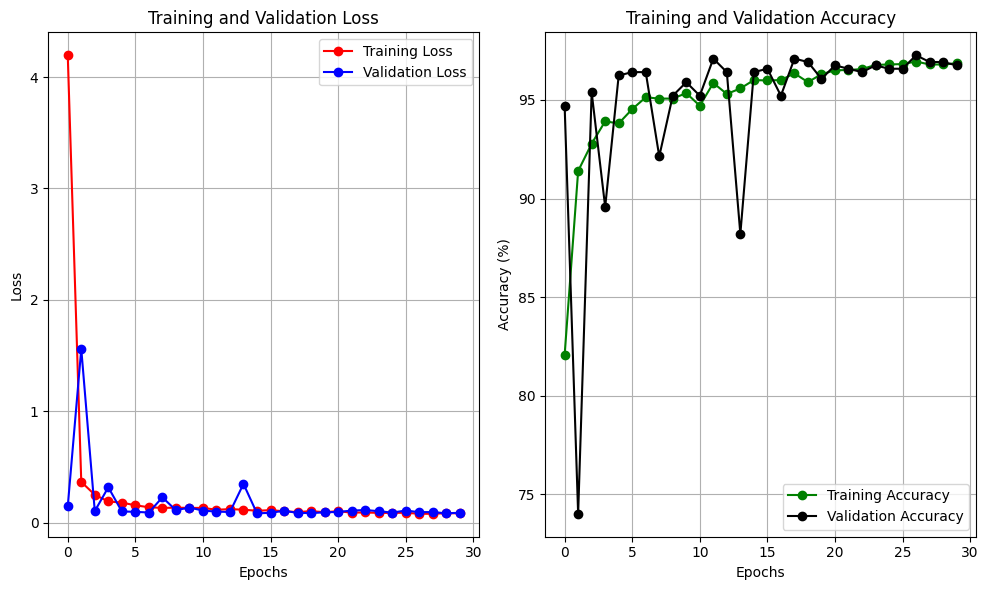

Model saved


FinalModelThree_extradropout(
  (conv_relu_pool_stack): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Dropout(p=0.8, inplace=False)
    (10): Linear(in_features=50176, out_features=2, bias=True)
  )
)

In [ ]:
#with dropout, annealing lr scheduler, batch norm
class FinalModelThree_extradropout(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv_relu_pool_stack = nn.Sequential(
            #layer 1
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #224 -> 112

            #layer 2
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #112 -> 56

            nn.Flatten(),
            nn.Dropout(0.8),
            nn.Linear(16 * 56 * 56, 2)
        )

    def forward(self, x):
        x = self.conv_relu_pool_stack(x)
        return x

final_model_three_extra = FinalModelThree_extradropout()
final_model_three_extra.to(device)

optimizer_lr_sched_extra = optim.SGD(final_model_three_extra.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_lr_sched_extra, T_max=30)

test_improvements_lr(final_model_three_extra, test_config, training_dataloader, validation_dataloader, testing_dataloader, device, "chest_xray_model_finalthreemodel_extradropout.pth")

**(a)**

*Insert a brief explanation of the three improvements you have used*

Recall that our baseline model was not fully converging, was quite unstable and could be improved on some result metrices.

*For each improvment:*

*State the change being made;*

*State **why** this change could, in theory, improve the performance of the baseline model. If possible, motivate your hypothesis using empirical evidence from the baseline models results*

1. **Dropout layer**

The dropout layer adresses the problem of instability. Furthermore, it helps the model to generalise better to unseen data by not relying too heavily on any single neuron or feature in the model. So in theory, the dropout layer could improve our baseline model since that model is quite unstable and it seems to overfit with respect to the validation set.

The dropout rate of 0.8 means that 80% of the neurons in the fully connected layer are randomly deactivated during each forward pass. Therefore, it cannot rely on any particular features. The model now has to learn different ways of solving the same classification task, which will make the model better and generalisation to unseen data.

The dropout layer is tested both on the baseline as a single improvement and left out of the final model to see it's impact.

2. **Batch normalization**

In theory, batch normalization stabilizes and accelerates training. It tackles the problem of internal covariate shift, which is when the distribution of outputs changes during the training. This change happens because of the parameter weights that are updated. Batch normalization normalizes the output of each layer. This will lead to more effective gradient descent (which is desired since SGD is used) and faster convergence. Batch normalization will in theory also work better with ReLu since the input for the activation function is stabilized. Based on our baseline, which is not fully converged and quite unstable, batch normalization should thus be an improvement.

There is not one specific location for a batch normalization layer. After reading different papers on where it would fit best, I found that it is typically placed after each convolutional layer and before the activation function (Al-Shourbaji, Kachare, Abualigah, et al., 2022).

Batch normalization is tested both on the baseline as a single improvement and left out of the final model to see it's impact.


3. **Learning rate scheduler**

Generally, a learning rate scheduler allows for more effective convergence and implements adaptive learning. The scheduler dynamically adjusts the learning rate during training, which, theoretically, could benefit convergence issues and improve model stability. Both of which are problems in our baseline model.

Cosine annealing gradually reduces the learning rate over time following a cosine curve, which allows the model to take smaller and more controlled steps as training progresses. This helps to avoid overshooting local minima and thus allowing the model to settle into an optimal solution. Cosine annealing lets the model explore in early stages of training and refines the parameters closer to the end of training.

The learning rate scheduler is added in the training loop of our code and does not change our model architecture.  

The learning rate scheduler is tested both on the baseline as a single improvement and left out of the final model to see it's impact.






**(b)**

_Present your results, including plots etc, here_

Our final model achieves a validation accuracy of 96.8% (+1.2%pt above baseline). The validation loss is 0.0889 (-0.0204 compared to baseline). The validation sensitivity is 98.4% (+3.6%pt above baseline). The summary metrices are given below, were 'vs. X' is the comparison to the baseline results.

*   Train accuracy: 96.9% (vs. 97.2%) & train loss: 0.0837 (vs. 0.0755)
*   Validation accuracy: 96.8% (vs. 95.6%) & validation loss: 0.0889 (vs. 0.1093)
*   Validation normal class accuracy: 92.4% (vs. 97.5%)
*   Validation pneumonia class accuracy: 98.4 (vs. 94.8%)




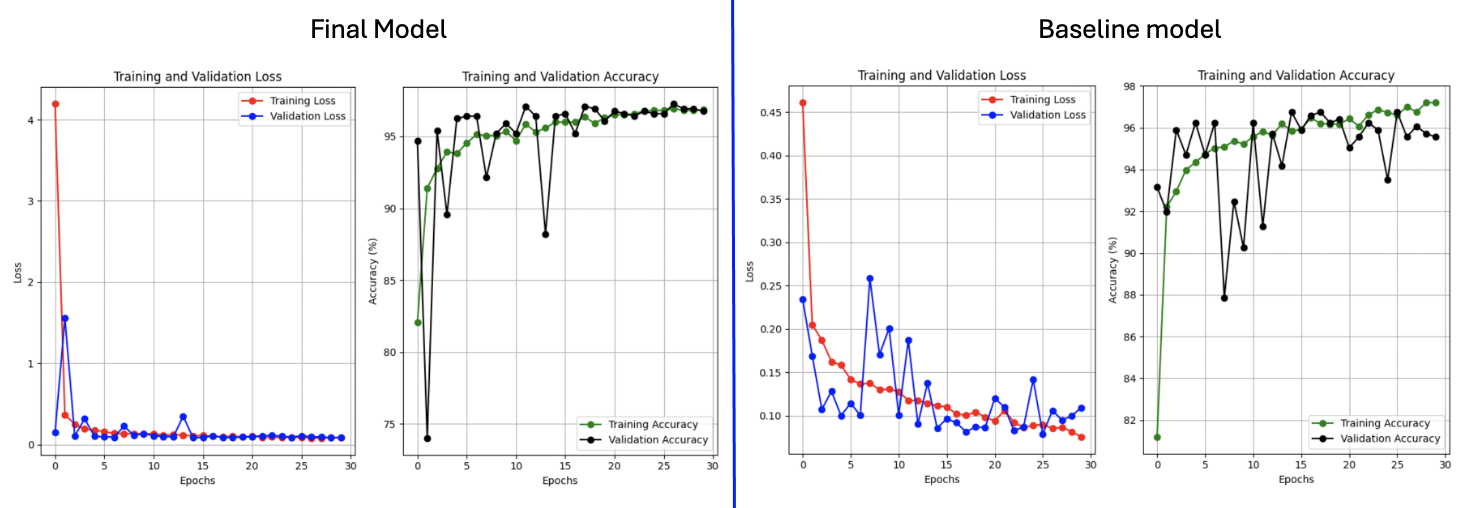

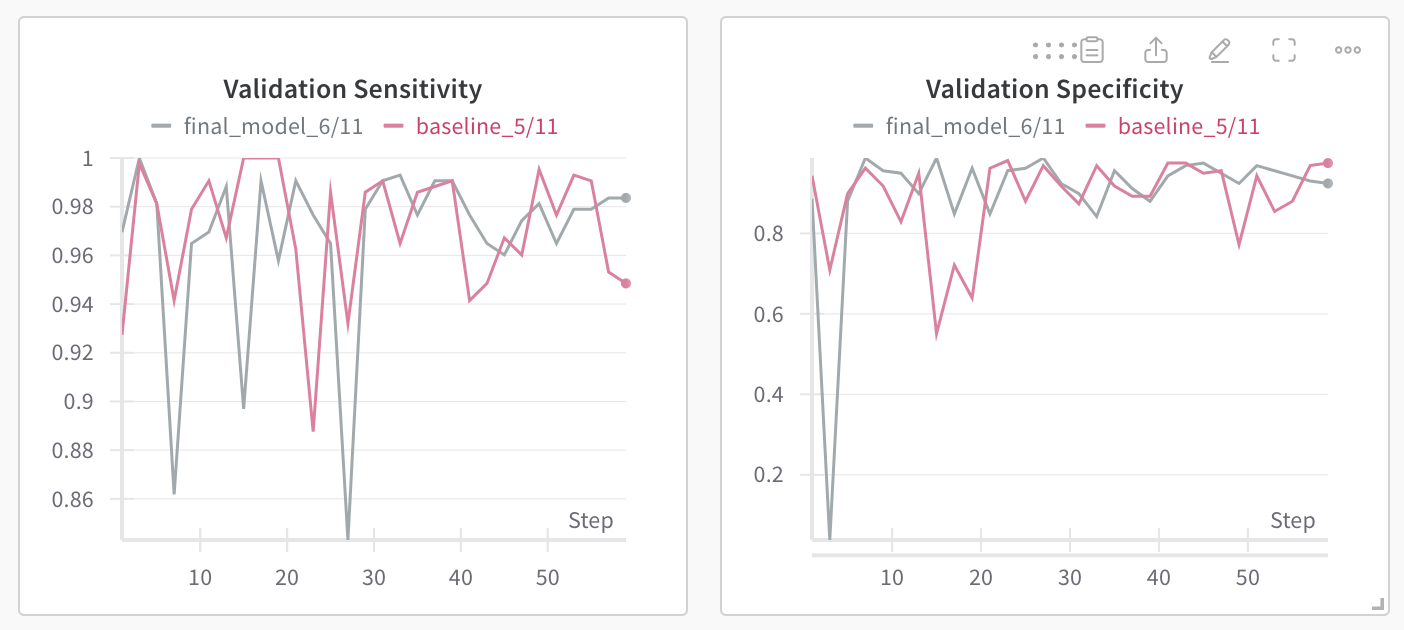

**(c)**

_Discuss your results here_

As shown in above, our final model is converging, achieves a higher validation accuracy and a lower validation loss. The better performance on the validation set indicates that our improved model is more accurate in classifying X-Rays. Furthermore, both validation sensitivity and specificity seem to become more stable towards the end of our training, which improves the reliability of our model

The improved model has a higher pneumonia class accuracy, but a lower normal class accuracy. This indicates that our improved model is more focused on detecting pneumonia than detecting normal X-Rays. Since we are dealing with a medical classification problem, this is desired as it will miss less individuals with pneumonia.

The training set performances of the improved model are slightly below the baseline model, but since the alignment of the validation and training set improved. The lower training set performances do not impact the performance of our overall model. The better alignment of the training and validation accuracy and loss implies a more robust generalization to unseen data.

## Q 4.2: Empirically justify improvement 1 (10 marks)

Now you will empirically demonstrate the contribution of each improvement to the final performance of your model.

To justify the utility of an improvement, you should present one of the following experiments:
- *Option 1:* Train the final model _without_ that improvement (but still with the other two improvements). Compare these results to the results you presented previously with all three improvements. If the improvement is useful, removing it should result in a drop in performance
- *Option 2:* Compare the performance of baseline to the perfroamnce of the baseline plus a single improvement. If the improvement is useful, you should expect improved performance versus the baseline.

You will still get a significant portion of the marks if the proposed improvement was well-motivated but does not empirically improve perfromance. In this case, ensure your discussion touches on why performance may not have improved or any other interesting talking points.


***Option 2 is already executed in Q4.0 when trying out different improvements on the baseline, based on those experiments i have chosen the improvements. Now we will use option 1 to double check and present both experiment results. ***


In [ ]:
# loose the dropout, keep the annealing and batchnorm

class FinalModelNoDropout(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv_relu_pool_stack = nn.Sequential(
            #layer 1
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #224 -> 112

            #layer 2
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #112 -> 56

            nn.Flatten(),
            #nn.Dropout(0.8),
            nn.Linear(16 * 56 * 56, 2)
        )

    def forward(self, x):
        x = self.conv_relu_pool_stack(x)
        return x

final_model_nodropout = FinalModelNoDropout()
final_model_nodropout.to(device)

optimizer_lr_sched_nodropout = optim.SGD(final_model_nodropout.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_lr_sched_nodropout, T_max=30)

Training:   0%|          | 0/74 [00:00<?, ?batch/s]

Validating: 100%|██████████| 10/10 [00:03<00:00,  2.75batch/s]
c:\Users\alexf\NonSynced Area\JulieProject\venv\Lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
c:\Users\alexf\NonSynced Area\JulieProject\venv\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are u

Epoch [1/30] - Train Loss: 3.9489, Train Accuracy: 82.60% - Val Loss: 0.1394, Val Accuracy: 94.36% - Train Normal Accuracy: 68.09%, Train Pneumonia Accuracy: 87.98% - Val Normal Accuracy: 82.91%, Val Pneumonia Accuracy: 98.59%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.68batch/s]


Epoch [2/30] - Train Loss: 0.2238, Train Accuracy: 92.68% - Val Loss: 0.1810, Val Accuracy: 92.14% - Train Normal Accuracy: 85.07%, Train Pneumonia Accuracy: 95.49% - Val Normal Accuracy: 97.47%, Val Pneumonia Accuracy: 90.16%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.86batch/s]


Epoch [3/30] - Train Loss: 0.1997, Train Accuracy: 93.25% - Val Loss: 0.1400, Val Accuracy: 93.85% - Train Normal Accuracy: 85.78%, Train Pneumonia Accuracy: 96.02% - Val Normal Accuracy: 80.38%, Val Pneumonia Accuracy: 98.83%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.74batch/s]


Epoch [4/30] - Train Loss: 0.1766, Train Accuracy: 93.60% - Val Loss: 0.1966, Val Accuracy: 91.45% - Train Normal Accuracy: 86.41%, Train Pneumonia Accuracy: 96.26% - Val Normal Accuracy: 98.10%, Val Pneumonia Accuracy: 88.99%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.73batch/s]


Epoch [5/30] - Train Loss: 0.1506, Train Accuracy: 94.43% - Val Loss: 0.0971, Val Accuracy: 95.90% - Train Normal Accuracy: 88.15%, Train Pneumonia Accuracy: 96.75% - Val Normal Accuracy: 89.24%, Val Pneumonia Accuracy: 98.36%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.87batch/s]


Epoch [6/30] - Train Loss: 0.1341, Train Accuracy: 95.11% - Val Loss: 0.0944, Val Accuracy: 96.24% - Train Normal Accuracy: 89.10%, Train Pneumonia Accuracy: 97.34% - Val Normal Accuracy: 92.41%, Val Pneumonia Accuracy: 97.66%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.74batch/s]


Epoch [7/30] - Train Loss: 0.1351, Train Accuracy: 94.79% - Val Loss: 0.1169, Val Accuracy: 95.04% - Train Normal Accuracy: 88.78%, Train Pneumonia Accuracy: 97.02% - Val Normal Accuracy: 96.20%, Val Pneumonia Accuracy: 94.61%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.78batch/s]


Epoch [8/30] - Train Loss: 0.1107, Train Accuracy: 95.71% - Val Loss: 0.0910, Val Accuracy: 96.41% - Train Normal Accuracy: 91.07%, Train Pneumonia Accuracy: 97.43% - Val Normal Accuracy: 94.94%, Val Pneumonia Accuracy: 96.96%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.74batch/s]


Epoch [9/30] - Train Loss: 0.1015, Train Accuracy: 96.05% - Val Loss: 0.3176, Val Accuracy: 86.67% - Train Normal Accuracy: 91.31%, Train Pneumonia Accuracy: 97.81% - Val Normal Accuracy: 50.63%, Val Pneumonia Accuracy: 100.00%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.64batch/s]


Epoch [10/30] - Train Loss: 0.0944, Train Accuracy: 96.41% - Val Loss: 0.1034, Val Accuracy: 96.07% - Train Normal Accuracy: 92.18%, Train Pneumonia Accuracy: 97.98% - Val Normal Accuracy: 87.97%, Val Pneumonia Accuracy: 99.06%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.66batch/s]


Epoch [11/30] - Train Loss: 0.0885, Train Accuracy: 96.52% - Val Loss: 0.0905, Val Accuracy: 96.58% - Train Normal Accuracy: 92.89%, Train Pneumonia Accuracy: 97.86% - Val Normal Accuracy: 90.51%, Val Pneumonia Accuracy: 98.83%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.98batch/s]


Epoch [12/30] - Train Loss: 0.0752, Train Accuracy: 97.29% - Val Loss: 0.0957, Val Accuracy: 96.24% - Train Normal Accuracy: 94.47%, Train Pneumonia Accuracy: 98.33% - Val Normal Accuracy: 95.57%, Val Pneumonia Accuracy: 96.49%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.99batch/s]


Epoch [13/30] - Train Loss: 0.0680, Train Accuracy: 97.37% - Val Loss: 0.1194, Val Accuracy: 95.56% - Train Normal Accuracy: 94.47%, Train Pneumonia Accuracy: 98.45% - Val Normal Accuracy: 85.44%, Val Pneumonia Accuracy: 99.30%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.57batch/s]


Epoch [14/30] - Train Loss: 0.0621, Train Accuracy: 97.78% - Val Loss: 0.0965, Val Accuracy: 96.41% - Train Normal Accuracy: 95.34%, Train Pneumonia Accuracy: 98.68% - Val Normal Accuracy: 90.51%, Val Pneumonia Accuracy: 98.59%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.50batch/s]


Epoch [15/30] - Train Loss: 0.0659, Train Accuracy: 97.59% - Val Loss: 0.0911, Val Accuracy: 96.24% - Train Normal Accuracy: 95.18%, Train Pneumonia Accuracy: 98.48% - Val Normal Accuracy: 93.67%, Val Pneumonia Accuracy: 97.19%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.73batch/s]


Epoch [16/30] - Train Loss: 0.0496, Train Accuracy: 98.27% - Val Loss: 0.1072, Val Accuracy: 95.38% - Train Normal Accuracy: 96.29%, Train Pneumonia Accuracy: 99.01% - Val Normal Accuracy: 87.97%, Val Pneumonia Accuracy: 98.13%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.91batch/s]


Epoch [17/30] - Train Loss: 0.0525, Train Accuracy: 98.31% - Val Loss: 0.1710, Val Accuracy: 93.16% - Train Normal Accuracy: 96.21%, Train Pneumonia Accuracy: 99.09% - Val Normal Accuracy: 96.84%, Val Pneumonia Accuracy: 91.80%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.66batch/s]


Epoch [18/30] - Train Loss: 0.0440, Train Accuracy: 98.83% - Val Loss: 0.1411, Val Accuracy: 95.04% - Train Normal Accuracy: 97.47%, Train Pneumonia Accuracy: 99.33% - Val Normal Accuracy: 96.20%, Val Pneumonia Accuracy: 94.61%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.73batch/s]


Epoch [19/30] - Train Loss: 0.0391, Train Accuracy: 98.91% - Val Loss: 0.1312, Val Accuracy: 95.56% - Train Normal Accuracy: 97.79%, Train Pneumonia Accuracy: 99.33% - Val Normal Accuracy: 96.20%, Val Pneumonia Accuracy: 95.32%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.74batch/s]


Epoch [20/30] - Train Loss: 0.0408, Train Accuracy: 98.85% - Val Loss: 1.2214, Val Accuracy: 64.62% - Train Normal Accuracy: 97.47%, Train Pneumonia Accuracy: 99.36% - Val Normal Accuracy: 100.00%, Val Pneumonia Accuracy: 51.52%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.75batch/s]


Epoch [21/30] - Train Loss: 0.0667, Train Accuracy: 98.27% - Val Loss: 0.1137, Val Accuracy: 95.56% - Train Normal Accuracy: 96.68%, Train Pneumonia Accuracy: 98.86% - Val Normal Accuracy: 93.67%, Val Pneumonia Accuracy: 96.25%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.67batch/s]


Epoch [22/30] - Train Loss: 0.0282, Train Accuracy: 99.38% - Val Loss: 0.1181, Val Accuracy: 95.56% - Train Normal Accuracy: 98.58%, Train Pneumonia Accuracy: 99.68% - Val Normal Accuracy: 94.30%, Val Pneumonia Accuracy: 96.02%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.81batch/s]


Epoch [23/30] - Train Loss: 0.0280, Train Accuracy: 99.49% - Val Loss: 0.1101, Val Accuracy: 96.07% - Train Normal Accuracy: 98.74%, Train Pneumonia Accuracy: 99.77% - Val Normal Accuracy: 93.67%, Val Pneumonia Accuracy: 96.96%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.70batch/s]


Epoch [24/30] - Train Loss: 0.0239, Train Accuracy: 99.59% - Val Loss: 0.1478, Val Accuracy: 95.38% - Train Normal Accuracy: 98.89%, Train Pneumonia Accuracy: 99.85% - Val Normal Accuracy: 96.20%, Val Pneumonia Accuracy: 95.08%


Validating: 100%|██████████| 10/10 [00:03<00:00,  3.01batch/s]


Epoch [25/30] - Train Loss: 0.0242, Train Accuracy: 99.57% - Val Loss: 0.1396, Val Accuracy: 94.87% - Train Normal Accuracy: 98.89%, Train Pneumonia Accuracy: 99.82% - Val Normal Accuracy: 94.94%, Val Pneumonia Accuracy: 94.85%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.66batch/s]


Epoch [26/30] - Train Loss: 0.0198, Train Accuracy: 99.64% - Val Loss: 0.1239, Val Accuracy: 95.73% - Train Normal Accuracy: 99.13%, Train Pneumonia Accuracy: 99.82% - Val Normal Accuracy: 89.87%, Val Pneumonia Accuracy: 97.89%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.90batch/s]


Epoch [27/30] - Train Loss: 0.0172, Train Accuracy: 99.77% - Val Loss: 0.1267, Val Accuracy: 95.56% - Train Normal Accuracy: 99.37%, Train Pneumonia Accuracy: 99.91% - Val Normal Accuracy: 94.30%, Val Pneumonia Accuracy: 96.02%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.66batch/s]


Epoch [28/30] - Train Loss: 0.0153, Train Accuracy: 99.89% - Val Loss: 0.1295, Val Accuracy: 95.56% - Train Normal Accuracy: 99.68%, Train Pneumonia Accuracy: 99.97% - Val Normal Accuracy: 93.04%, Val Pneumonia Accuracy: 96.49%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.66batch/s]


Epoch [29/30] - Train Loss: 0.0150, Train Accuracy: 99.79% - Val Loss: 0.1249, Val Accuracy: 95.90% - Train Normal Accuracy: 99.37%, Train Pneumonia Accuracy: 99.94% - Val Normal Accuracy: 93.04%, Val Pneumonia Accuracy: 96.96%


Validating: 100%|██████████| 10/10 [00:03<00:00,  2.75batch/s]


Epoch [30/30] - Train Loss: 0.0130, Train Accuracy: 99.91% - Val Loss: 0.1315, Val Accuracy: 95.21% - Train Normal Accuracy: 99.68%, Train Pneumonia Accuracy: 100.00% - Val Normal Accuracy: 92.41%, Val Pneumonia Accuracy: 96.25%


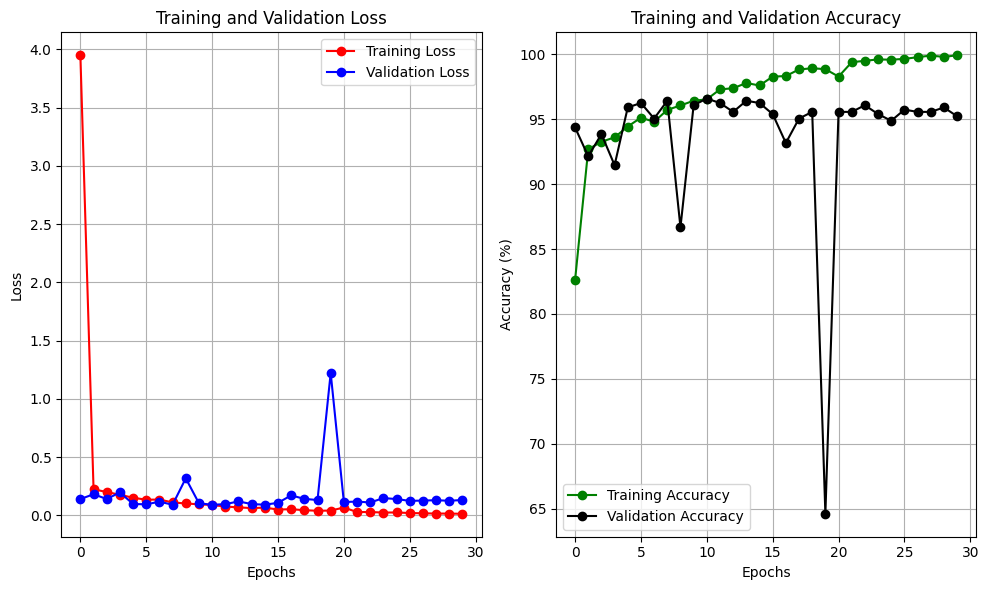

Model saved


FinalModelNoDropout(
  (conv_relu_pool_stack): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=50176, out_features=2, bias=True)
  )
)

In [ ]:
test_improvements_lr(final_model_nodropout, test_config, training_dataloader, validation_dataloader, testing_dataloader, device, "chest_xray_model_finalmodelNoDropout.pth")

**(a)**

Dropout layer (0.8)

**(b)**

_Present your results, including plots etc, here_

The summary metrices are given below, were 'vs. X' is the comparison to the final model results.

**Final model without dropout vs. Final model**

*   Validation accuracy: 95.2% (vs. 96.8%) & validation loss: 0.0889 (vs. 0.1315)
*   Validation normal class accuracy: 92.4% (vs. 92.4%)
*   Validation pneumonia class accuracy: 96.3% (vs. 98.4%)



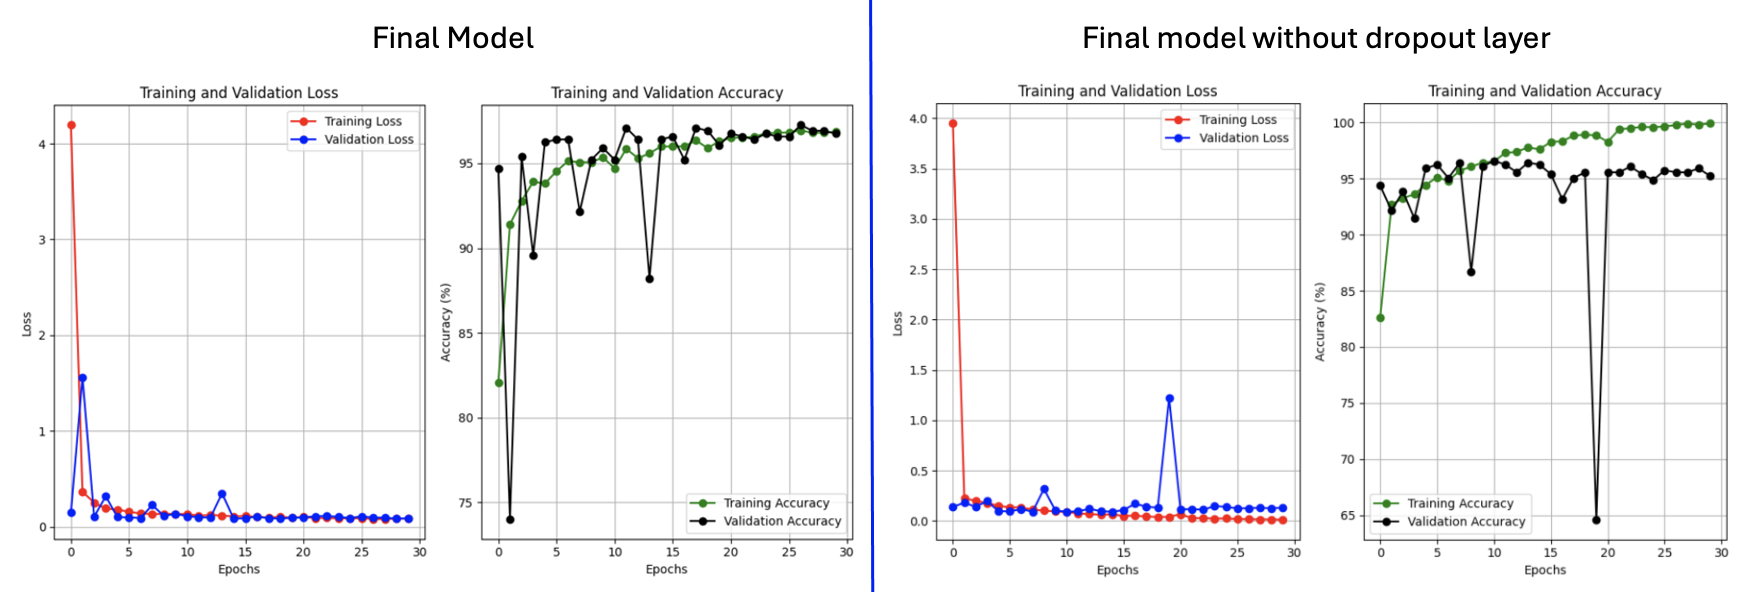

**Baseline + dropout layer vs. Baseline**

*   Validation accuracy: 97.4% (vs. 95.6%) & validation loss: 0.0778 (vs. 0.1093)
*   Validation normal class accuracy: 94.3% (vs. 97.5%)
*   Validation pneumonia class accuracy: 98.6% (vs. 94.8%)

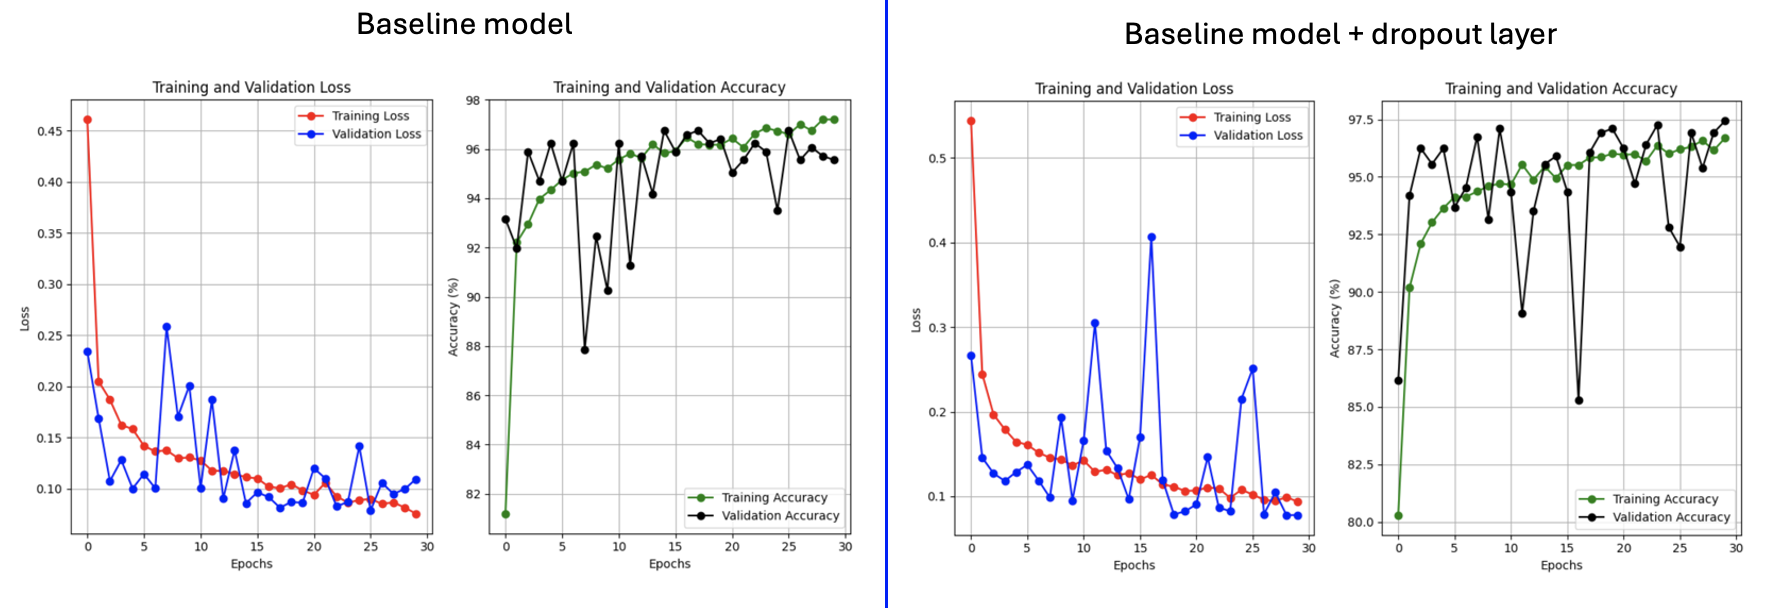

**(c)**

_Discuss your results here_

As shown above, we can see that removing the dropout layer from our final model results in overfitting on our trainingset with respect to our validation set. Furthermore, we can see that the sensitivity of our models drops by 2.1%pt. Our overall validation accuracy drops with 1.6%pt and loss drops with 0.0426. It is therefore safe to say that our final model performs better on unseen data with the dropout layer included.

Secondly, our baseline model is improved with the addition of a dropout layer. As with the other experiment, it is clear that pneumonia class accuracy increases (+3.8%pt) as well as our overall validation accuracy (+1.8%pt) and loss (-0.0315) .

In conclusion, there is empirical evidence that shows that the addition of a dropout layer to our model has improved the overall performance.

## Q 4.3: Empirically justify improvement 2 (10 marks)

In [ ]:
# loose the batch normalisation, keep the annealing and dropout

class FinalModelNoBatch(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv_relu_pool_stack = nn.Sequential(
            #layer 1
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #224 -> 112

            #layer 2
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #112 -> 56

            nn.Flatten(),
            nn.Dropout(0.8),
            nn.Linear(16 * 56 * 56, 2)
        )

    def forward(self, x):
        x = self.conv_relu_pool_stack(x)
        return x

final_model_nobatch = FinalModelNoBatch()
final_model_nobatch.to(device)

optimizer_lr_sched_nobatch = optim.SGD(final_model_nobatch.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_lr_sched_nobatch, T_max=30)

Validating: 100%|██████████| 10/10 [00:06<00:00,  1.62batch/s]


Epoch [1/30] - Train Loss: 0.4062, Train Accuracy: 82.77% - Val Loss: 0.2128, Val Accuracy: 93.85% - Train Normal Accuracy: 56.71%, Train Pneumonia Accuracy: 92.42% - Val Normal Accuracy: 94.30%, Val Pneumonia Accuracy: 93.68%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.79batch/s]


Epoch [2/30] - Train Loss: 0.2168, Train Accuracy: 91.89% - Val Loss: 0.1320, Val Accuracy: 94.87% - Train Normal Accuracy: 81.04%, Train Pneumonia Accuracy: 95.90% - Val Normal Accuracy: 84.18%, Val Pneumonia Accuracy: 98.83%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.63batch/s]


Epoch [3/30] - Train Loss: 0.1809, Train Accuracy: 92.87% - Val Loss: 0.2533, Val Accuracy: 90.09% - Train Normal Accuracy: 84.36%, Train Pneumonia Accuracy: 96.02% - Val Normal Accuracy: 96.20%, Val Pneumonia Accuracy: 87.82%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.68batch/s]


Epoch [4/30] - Train Loss: 0.1767, Train Accuracy: 93.25% - Val Loss: 0.1525, Val Accuracy: 95.21% - Train Normal Accuracy: 84.76%, Train Pneumonia Accuracy: 96.40% - Val Normal Accuracy: 96.20%, Val Pneumonia Accuracy: 94.85%


Validating: 100%|██████████| 10/10 [00:07<00:00,  1.38batch/s]


Epoch [5/30] - Train Loss: 0.1573, Train Accuracy: 94.17% - Val Loss: 0.1106, Val Accuracy: 97.26% - Train Normal Accuracy: 86.65%, Train Pneumonia Accuracy: 96.96% - Val Normal Accuracy: 94.94%, Val Pneumonia Accuracy: 98.13%


Validating: 100%|██████████| 10/10 [00:07<00:00,  1.30batch/s]


Epoch [6/30] - Train Loss: 0.1649, Train Accuracy: 93.77% - Val Loss: 0.1314, Val Accuracy: 94.19% - Train Normal Accuracy: 86.49%, Train Pneumonia Accuracy: 96.46% - Val Normal Accuracy: 81.01%, Val Pneumonia Accuracy: 99.06%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.53batch/s]


Epoch [7/30] - Train Loss: 0.1480, Train Accuracy: 94.47% - Val Loss: 0.1548, Val Accuracy: 92.65% - Train Normal Accuracy: 87.36%, Train Pneumonia Accuracy: 97.10% - Val Normal Accuracy: 73.42%, Val Pneumonia Accuracy: 99.77%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.54batch/s]


Epoch [8/30] - Train Loss: 0.1455, Train Accuracy: 94.60% - Val Loss: 0.1043, Val Accuracy: 97.26% - Train Normal Accuracy: 87.44%, Train Pneumonia Accuracy: 97.25% - Val Normal Accuracy: 94.94%, Val Pneumonia Accuracy: 98.13%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.55batch/s]


Epoch [9/30] - Train Loss: 0.1456, Train Accuracy: 94.53% - Val Loss: 0.1163, Val Accuracy: 94.53% - Train Normal Accuracy: 88.07%, Train Pneumonia Accuracy: 96.93% - Val Normal Accuracy: 81.65%, Val Pneumonia Accuracy: 99.30%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.52batch/s]


Epoch [10/30] - Train Loss: 0.1355, Train Accuracy: 94.83% - Val Loss: 0.0968, Val Accuracy: 97.44% - Train Normal Accuracy: 88.63%, Train Pneumonia Accuracy: 97.13% - Val Normal Accuracy: 94.94%, Val Pneumonia Accuracy: 98.36%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.51batch/s]


Epoch [11/30] - Train Loss: 0.1413, Train Accuracy: 94.71% - Val Loss: 0.1526, Val Accuracy: 93.85% - Train Normal Accuracy: 88.86%, Train Pneumonia Accuracy: 96.87% - Val Normal Accuracy: 96.84%, Val Pneumonia Accuracy: 92.74%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.52batch/s]


Epoch [12/30] - Train Loss: 0.1345, Train Accuracy: 94.94% - Val Loss: 0.0937, Val Accuracy: 97.09% - Train Normal Accuracy: 89.02%, Train Pneumonia Accuracy: 97.13% - Val Normal Accuracy: 91.77%, Val Pneumonia Accuracy: 99.06%


Validating: 100%|██████████| 10/10 [00:07<00:00,  1.26batch/s]


Epoch [13/30] - Train Loss: 0.1313, Train Accuracy: 95.28% - Val Loss: 0.1260, Val Accuracy: 94.02% - Train Normal Accuracy: 90.05%, Train Pneumonia Accuracy: 97.22% - Val Normal Accuracy: 79.11%, Val Pneumonia Accuracy: 99.53%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.53batch/s]


Epoch [14/30] - Train Loss: 0.1240, Train Accuracy: 95.47% - Val Loss: 0.1745, Val Accuracy: 91.97% - Train Normal Accuracy: 89.97%, Train Pneumonia Accuracy: 97.51% - Val Normal Accuracy: 70.25%, Val Pneumonia Accuracy: 100.00%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.92batch/s]


Epoch [15/30] - Train Loss: 0.1184, Train Accuracy: 95.86% - Val Loss: 0.1327, Val Accuracy: 95.04% - Train Normal Accuracy: 90.60%, Train Pneumonia Accuracy: 97.81% - Val Normal Accuracy: 97.47%, Val Pneumonia Accuracy: 94.15%


Validating: 100%|██████████| 10/10 [00:07<00:00,  1.36batch/s]


Epoch [16/30] - Train Loss: 0.1198, Train Accuracy: 95.54% - Val Loss: 0.0993, Val Accuracy: 95.38% - Train Normal Accuracy: 90.13%, Train Pneumonia Accuracy: 97.54% - Val Normal Accuracy: 85.44%, Val Pneumonia Accuracy: 99.06%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.90batch/s]


Epoch [17/30] - Train Loss: 0.1152, Train Accuracy: 95.58% - Val Loss: 0.0916, Val Accuracy: 97.26% - Train Normal Accuracy: 90.21%, Train Pneumonia Accuracy: 97.57% - Val Normal Accuracy: 95.57%, Val Pneumonia Accuracy: 97.89%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.74batch/s]


Epoch [18/30] - Train Loss: 0.1111, Train Accuracy: 95.96% - Val Loss: 0.0990, Val Accuracy: 96.07% - Train Normal Accuracy: 91.15%, Train Pneumonia Accuracy: 97.75% - Val Normal Accuracy: 87.34%, Val Pneumonia Accuracy: 99.30%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.90batch/s]


Epoch [19/30] - Train Loss: 0.1107, Train Accuracy: 95.71% - Val Loss: 0.0888, Val Accuracy: 97.61% - Train Normal Accuracy: 90.44%, Train Pneumonia Accuracy: 97.66% - Val Normal Accuracy: 96.20%, Val Pneumonia Accuracy: 98.13%


Validating: 100%|██████████| 10/10 [00:07<00:00,  1.37batch/s]


Epoch [20/30] - Train Loss: 0.1100, Train Accuracy: 96.11% - Val Loss: 0.0917, Val Accuracy: 97.26% - Train Normal Accuracy: 91.55%, Train Pneumonia Accuracy: 97.81% - Val Normal Accuracy: 96.20%, Val Pneumonia Accuracy: 97.66%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.79batch/s]


Epoch [21/30] - Train Loss: 0.1093, Train Accuracy: 96.05% - Val Loss: 0.2164, Val Accuracy: 92.14% - Train Normal Accuracy: 91.55%, Train Pneumonia Accuracy: 97.72% - Val Normal Accuracy: 98.73%, Val Pneumonia Accuracy: 89.70%


Validating: 100%|██████████| 10/10 [00:08<00:00,  1.23batch/s]


Epoch [22/30] - Train Loss: 0.1112, Train Accuracy: 95.94% - Val Loss: 0.0934, Val Accuracy: 96.58% - Train Normal Accuracy: 91.23%, Train Pneumonia Accuracy: 97.69% - Val Normal Accuracy: 96.20%, Val Pneumonia Accuracy: 96.72%


Validating: 100%|██████████| 10/10 [00:07<00:00,  1.42batch/s]


Epoch [23/30] - Train Loss: 0.1005, Train Accuracy: 96.46% - Val Loss: 0.0825, Val Accuracy: 97.26% - Train Normal Accuracy: 92.65%, Train Pneumonia Accuracy: 97.86% - Val Normal Accuracy: 91.77%, Val Pneumonia Accuracy: 99.30%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.54batch/s]


Epoch [24/30] - Train Loss: 0.1098, Train Accuracy: 96.24% - Val Loss: 0.0982, Val Accuracy: 95.56% - Train Normal Accuracy: 91.86%, Train Pneumonia Accuracy: 97.86% - Val Normal Accuracy: 85.44%, Val Pneumonia Accuracy: 99.30%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.51batch/s]


Epoch [25/30] - Train Loss: 0.1005, Train Accuracy: 96.43% - Val Loss: 0.1519, Val Accuracy: 94.87% - Train Normal Accuracy: 92.34%, Train Pneumonia Accuracy: 97.95% - Val Normal Accuracy: 98.73%, Val Pneumonia Accuracy: 93.44%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.70batch/s]


Epoch [26/30] - Train Loss: 0.1040, Train Accuracy: 96.01% - Val Loss: 0.0772, Val Accuracy: 97.44% - Train Normal Accuracy: 91.71%, Train Pneumonia Accuracy: 97.60% - Val Normal Accuracy: 94.30%, Val Pneumonia Accuracy: 98.59%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.64batch/s]


Epoch [27/30] - Train Loss: 0.0966, Train Accuracy: 96.63% - Val Loss: 0.1259, Val Accuracy: 95.38% - Train Normal Accuracy: 92.81%, Train Pneumonia Accuracy: 98.04% - Val Normal Accuracy: 97.47%, Val Pneumonia Accuracy: 94.61%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.54batch/s]


Epoch [28/30] - Train Loss: 0.0982, Train Accuracy: 96.58% - Val Loss: 0.0794, Val Accuracy: 97.61% - Train Normal Accuracy: 92.81%, Train Pneumonia Accuracy: 97.98% - Val Normal Accuracy: 93.67%, Val Pneumonia Accuracy: 99.06%


Validating: 100%|██████████| 10/10 [00:08<00:00,  1.12batch/s]


Epoch [29/30] - Train Loss: 0.0935, Train Accuracy: 96.50% - Val Loss: 0.0798, Val Accuracy: 97.26% - Train Normal Accuracy: 92.42%, Train Pneumonia Accuracy: 98.01% - Val Normal Accuracy: 94.30%, Val Pneumonia Accuracy: 98.36%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.66batch/s]


Epoch [30/30] - Train Loss: 0.0908, Train Accuracy: 96.73% - Val Loss: 0.0825, Val Accuracy: 96.92% - Train Normal Accuracy: 93.21%, Train Pneumonia Accuracy: 98.04% - Val Normal Accuracy: 90.51%, Val Pneumonia Accuracy: 99.30%


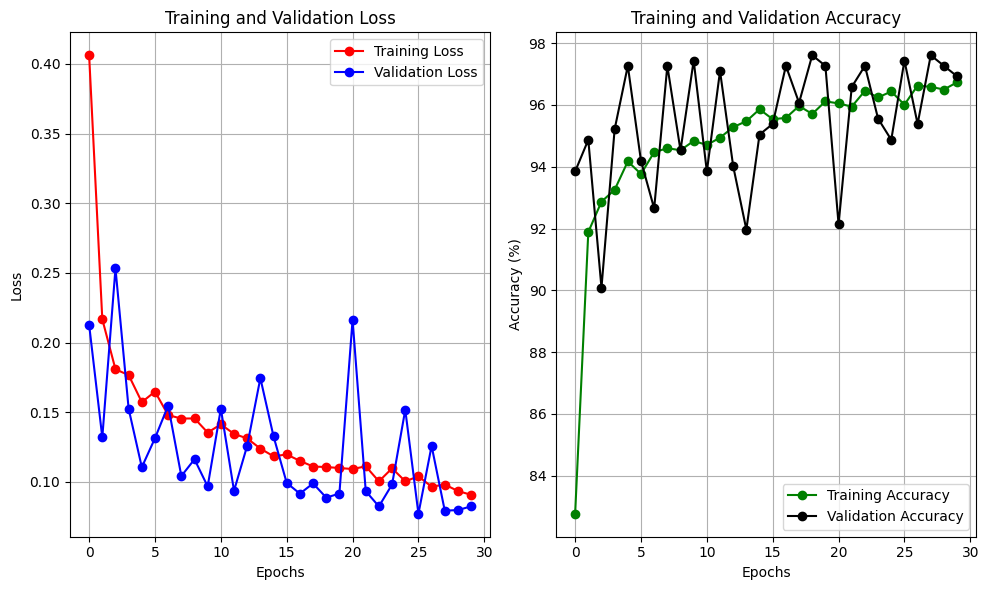

Model saved


FinalModelNoBatch(
  (conv_relu_pool_stack): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Dropout(p=0.8, inplace=False)
    (8): Linear(in_features=50176, out_features=2, bias=True)
  )
)

In [ ]:
test_improvements_lr(final_model_nobatch, test_config, training_dataloader, validation_dataloader, testing_dataloader, device, "chest_xray_model_finalmodelNoBatch.pth")

**(a)**

Batch normalization

**(b)**

_Present your results, including plots etc, here_

The summary metrices are given below, were 'vs. X' is the comparison to the final model results.

**Final model without batch normalization vs. Final model**

*   Validation accuracy: 96.9% (vs. 96.8%) & validation loss: 0.0825 (vs. 0.1315)
*   Validation normal class accuracy: 90.5% (vs. 92.4%)
*   Validation pneumonia class accuracy: 99.3% (vs. 98.4%)

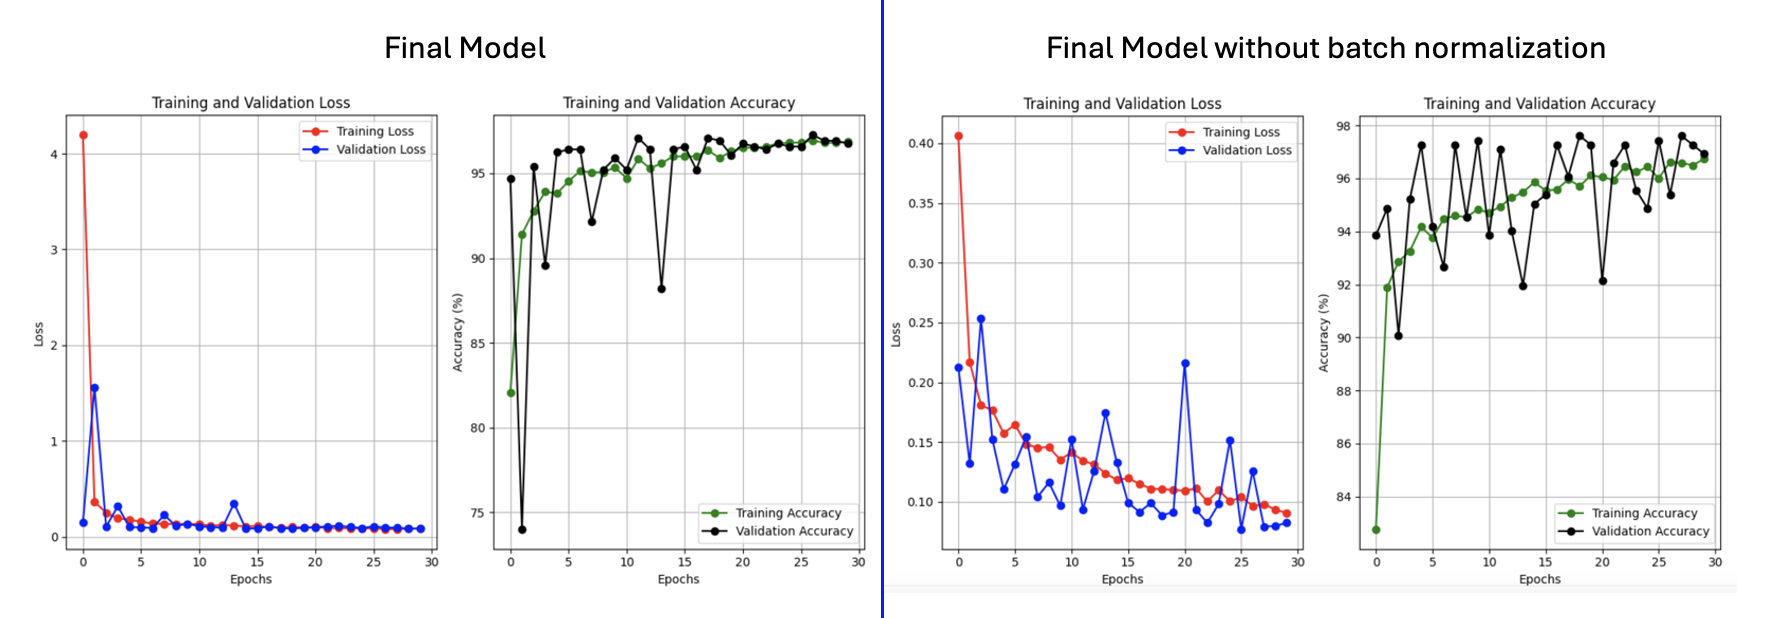

**Baseline + batch normalization layer vs. Baseline**

*   Validation accuracy: 95.6% (vs. 95.6%) & validation loss: 0.1180 (vs. 0.1093)
*   Validation normal class accuracy: 96.2% (vs. 97.5%)
*   Validation pneumonia class accuracy: 95.3% (vs. 94.8%)

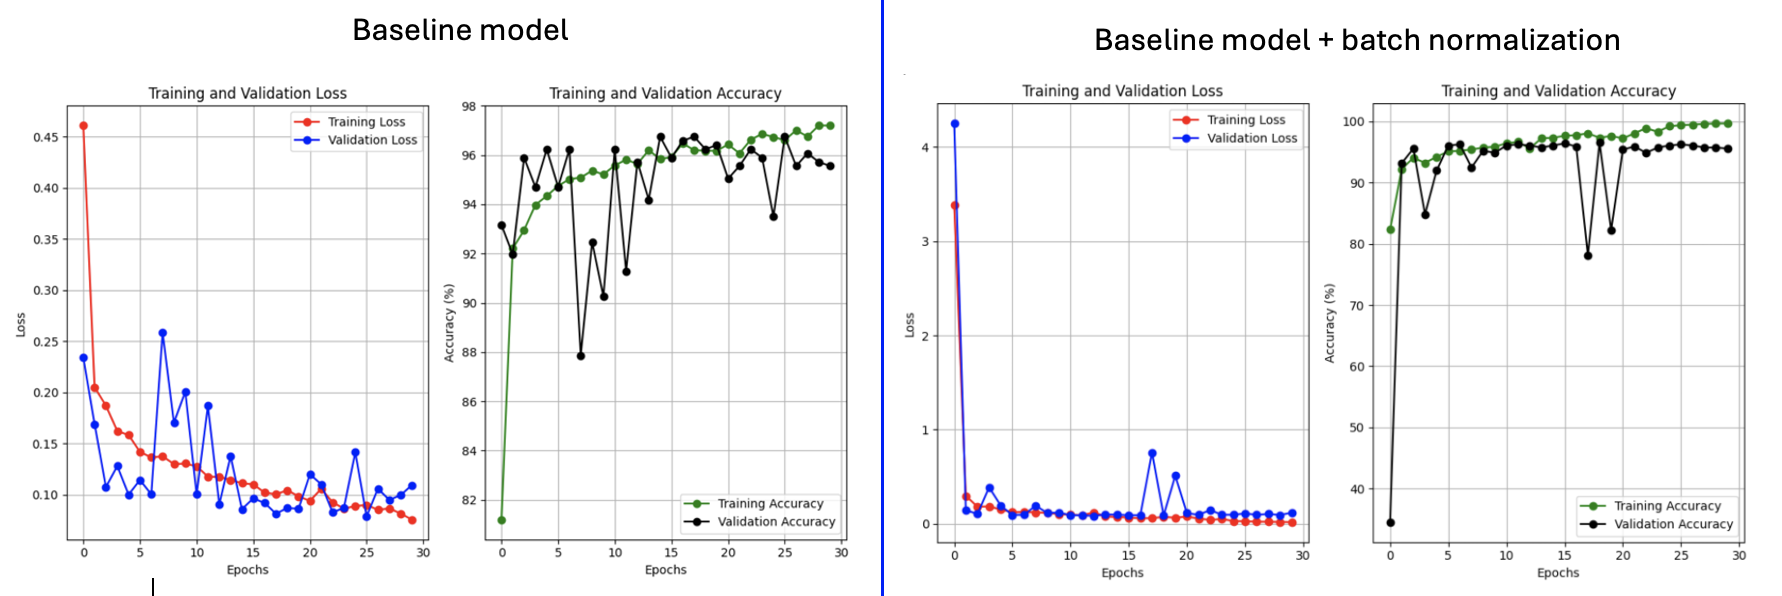

**(c)**

_Discuss your results here_

We can see that the training is more stable in the final model with batch normalization than without. The same goes for a more stable baseline + batch normalization than without. This is also one of the main reasons why batch normalization was chosen as an improvement. In addition, batch normalization improves the pneumonia class accuracy as desired.

The baseline has slightly lower loss than the baseline + batch normalization, which might be just a consequence of the more unstable learning curve of the baseline. However, overall validation accuracy remaind around the same for both experiments.

In conclusion, batch normalization has stabilized our training as desired. This improves the reliability of our model.



## Q 4.4: Empirically justify improvement 3 (10 marks)

In [ ]:
# loose the lr scheduler, keep the batch normalisation and dropout

class FinalModelNoLRscheduler(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv_relu_pool_stack = nn.Sequential(
            #layer 1
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #224 -> 112

            #layer 2
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #112 -> 56

            nn.Flatten(),
            nn.Dropout(0.8),
            nn.Linear(16 * 56 * 56, 2)
        )

    def forward(self, x):
        x = self.conv_relu_pool_stack(x)
        return x

final_model_noLR = FinalModelNoLRscheduler()
final_model_noLR.to(device)

FinalModelNoLRscheduler(
  (conv_relu_pool_stack): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Dropout(p=0.8, inplace=False)
    (10): Linear(in_features=50176, out_features=2, bias=True)
  )
)

Validating: 100%|██████████| 10/10 [00:05<00:00,  1.85batch/s]


Epoch [1/30] - Train Loss: 3.5474, Train Accuracy: 81.45% - Val Loss: 0.2281, Val Accuracy: 92.48% - Train Normal Accuracy: 65.09%, Train Pneumonia Accuracy: 87.51% - Val Normal Accuracy: 93.67%, Val Pneumonia Accuracy: 92.04%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.54batch/s]


Epoch [2/30] - Train Loss: 0.2596, Train Accuracy: 91.65% - Val Loss: 0.3906, Val Accuracy: 87.52% - Train Normal Accuracy: 83.10%, Train Pneumonia Accuracy: 94.82% - Val Normal Accuracy: 53.80%, Val Pneumonia Accuracy: 100.00%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.52batch/s]


Epoch [3/30] - Train Loss: 0.2198, Train Accuracy: 92.34% - Val Loss: 0.1535, Val Accuracy: 93.33% - Train Normal Accuracy: 84.28%, Train Pneumonia Accuracy: 95.32% - Val Normal Accuracy: 77.85%, Val Pneumonia Accuracy: 99.06%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.91batch/s]


Epoch [4/30] - Train Loss: 0.1962, Train Accuracy: 92.55% - Val Loss: 0.1534, Val Accuracy: 93.50% - Train Normal Accuracy: 84.28%, Train Pneumonia Accuracy: 95.61% - Val Normal Accuracy: 77.85%, Val Pneumonia Accuracy: 99.30%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.89batch/s]


Epoch [5/30] - Train Loss: 0.1865, Train Accuracy: 93.25% - Val Loss: 0.1469, Val Accuracy: 95.04% - Train Normal Accuracy: 86.26%, Train Pneumonia Accuracy: 95.85% - Val Normal Accuracy: 95.57%, Val Pneumonia Accuracy: 94.85%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.89batch/s]


Epoch [6/30] - Train Loss: 0.1726, Train Accuracy: 93.60% - Val Loss: 0.2878, Val Accuracy: 90.60% - Train Normal Accuracy: 86.89%, Train Pneumonia Accuracy: 96.08% - Val Normal Accuracy: 97.47%, Val Pneumonia Accuracy: 88.06%


Validating: 100%|██████████| 10/10 [00:07<00:00,  1.31batch/s]


Epoch [7/30] - Train Loss: 0.1624, Train Accuracy: 94.06% - Val Loss: 0.1561, Val Accuracy: 94.70% - Train Normal Accuracy: 87.76%, Train Pneumonia Accuracy: 96.40% - Val Normal Accuracy: 96.20%, Val Pneumonia Accuracy: 94.15%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.60batch/s]


Epoch [8/30] - Train Loss: 0.1541, Train Accuracy: 94.24% - Val Loss: 0.1226, Val Accuracy: 95.90% - Train Normal Accuracy: 87.36%, Train Pneumonia Accuracy: 96.78% - Val Normal Accuracy: 94.30%, Val Pneumonia Accuracy: 96.49%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.54batch/s]


Epoch [9/30] - Train Loss: 0.1512, Train Accuracy: 93.89% - Val Loss: 0.1128, Val Accuracy: 96.58% - Train Normal Accuracy: 87.12%, Train Pneumonia Accuracy: 96.40% - Val Normal Accuracy: 94.94%, Val Pneumonia Accuracy: 97.19%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.51batch/s]


Epoch [10/30] - Train Loss: 0.1418, Train Accuracy: 94.39% - Val Loss: 0.1049, Val Accuracy: 96.75% - Train Normal Accuracy: 88.55%, Train Pneumonia Accuracy: 96.55% - Val Normal Accuracy: 93.04%, Val Pneumonia Accuracy: 98.13%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.53batch/s]


Epoch [11/30] - Train Loss: 0.1332, Train Accuracy: 94.73% - Val Loss: 0.1068, Val Accuracy: 95.90% - Train Normal Accuracy: 88.63%, Train Pneumonia Accuracy: 96.99% - Val Normal Accuracy: 88.61%, Val Pneumonia Accuracy: 98.59%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.81batch/s]


Epoch [12/30] - Train Loss: 0.1313, Train Accuracy: 95.05% - Val Loss: 0.1400, Val Accuracy: 93.68% - Train Normal Accuracy: 89.57%, Train Pneumonia Accuracy: 97.07% - Val Normal Accuracy: 77.22%, Val Pneumonia Accuracy: 99.77%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.92batch/s]


Epoch [13/30] - Train Loss: 0.1315, Train Accuracy: 95.15% - Val Loss: 0.2416, Val Accuracy: 91.11% - Train Normal Accuracy: 89.73%, Train Pneumonia Accuracy: 97.16% - Val Normal Accuracy: 98.10%, Val Pneumonia Accuracy: 88.52%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.53batch/s]


Epoch [14/30] - Train Loss: 0.1307, Train Accuracy: 95.05% - Val Loss: 0.1184, Val Accuracy: 95.04% - Train Normal Accuracy: 89.34%, Train Pneumonia Accuracy: 97.16% - Val Normal Accuracy: 82.91%, Val Pneumonia Accuracy: 99.53%


Validating: 100%|██████████| 10/10 [00:08<00:00,  1.25batch/s]


Epoch [15/30] - Train Loss: 0.1218, Train Accuracy: 95.35% - Val Loss: 0.2887, Val Accuracy: 88.03% - Train Normal Accuracy: 89.89%, Train Pneumonia Accuracy: 97.37% - Val Normal Accuracy: 55.70%, Val Pneumonia Accuracy: 100.00%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.53batch/s]


Epoch [16/30] - Train Loss: 0.1194, Train Accuracy: 95.69% - Val Loss: 0.1216, Val Accuracy: 95.73% - Train Normal Accuracy: 90.36%, Train Pneumonia Accuracy: 97.66% - Val Normal Accuracy: 95.57%, Val Pneumonia Accuracy: 95.78%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.73batch/s]


Epoch [17/30] - Train Loss: 0.1116, Train Accuracy: 95.52% - Val Loss: 0.1148, Val Accuracy: 95.21% - Train Normal Accuracy: 90.36%, Train Pneumonia Accuracy: 97.43% - Val Normal Accuracy: 84.18%, Val Pneumonia Accuracy: 99.30%


Validating: 100%|██████████| 10/10 [00:10<00:00,  1.02s/batch]


Epoch [18/30] - Train Loss: 0.1115, Train Accuracy: 96.03% - Val Loss: 0.0999, Val Accuracy: 96.58% - Train Normal Accuracy: 91.31%, Train Pneumonia Accuracy: 97.78% - Val Normal Accuracy: 94.94%, Val Pneumonia Accuracy: 97.19%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.92batch/s]


Epoch [19/30] - Train Loss: 0.1104, Train Accuracy: 95.67% - Val Loss: 0.0879, Val Accuracy: 96.75% - Train Normal Accuracy: 90.44%, Train Pneumonia Accuracy: 97.60% - Val Normal Accuracy: 92.41%, Val Pneumonia Accuracy: 98.36%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.93batch/s]


Epoch [20/30] - Train Loss: 0.1079, Train Accuracy: 96.01% - Val Loss: 0.1294, Val Accuracy: 95.56% - Train Normal Accuracy: 90.84%, Train Pneumonia Accuracy: 97.92% - Val Normal Accuracy: 96.20%, Val Pneumonia Accuracy: 95.32%


Validating: 100%|██████████| 10/10 [00:08<00:00,  1.13batch/s]


Epoch [21/30] - Train Loss: 0.0983, Train Accuracy: 96.18% - Val Loss: 0.0977, Val Accuracy: 96.58% - Train Normal Accuracy: 91.31%, Train Pneumonia Accuracy: 97.98% - Val Normal Accuracy: 94.94%, Val Pneumonia Accuracy: 97.19%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.46batch/s]


Epoch [22/30] - Train Loss: 0.0954, Train Accuracy: 96.65% - Val Loss: 0.1025, Val Accuracy: 95.38% - Train Normal Accuracy: 93.05%, Train Pneumonia Accuracy: 97.98% - Val Normal Accuracy: 84.81%, Val Pneumonia Accuracy: 99.30%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.50batch/s]


Epoch [23/30] - Train Loss: 0.1032, Train Accuracy: 96.20% - Val Loss: 0.0860, Val Accuracy: 96.58% - Train Normal Accuracy: 91.86%, Train Pneumonia Accuracy: 97.81% - Val Normal Accuracy: 92.41%, Val Pneumonia Accuracy: 98.13%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.53batch/s]


Epoch [24/30] - Train Loss: 0.0994, Train Accuracy: 95.99% - Val Loss: 0.0840, Val Accuracy: 95.90% - Train Normal Accuracy: 91.00%, Train Pneumonia Accuracy: 97.83% - Val Normal Accuracy: 90.51%, Val Pneumonia Accuracy: 97.89%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.53batch/s]


Epoch [25/30] - Train Loss: 0.0906, Train Accuracy: 96.69% - Val Loss: 0.0858, Val Accuracy: 96.24% - Train Normal Accuracy: 92.81%, Train Pneumonia Accuracy: 98.13% - Val Normal Accuracy: 89.87%, Val Pneumonia Accuracy: 98.59%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.75batch/s]


Epoch [26/30] - Train Loss: 0.0981, Train Accuracy: 96.31% - Val Loss: 0.0950, Val Accuracy: 96.41% - Train Normal Accuracy: 92.42%, Train Pneumonia Accuracy: 97.75% - Val Normal Accuracy: 94.94%, Val Pneumonia Accuracy: 96.96%


Validating: 100%|██████████| 10/10 [00:05<00:00,  1.73batch/s]


Epoch [27/30] - Train Loss: 0.0923, Train Accuracy: 96.37% - Val Loss: 0.1368, Val Accuracy: 95.21% - Train Normal Accuracy: 92.58%, Train Pneumonia Accuracy: 97.78% - Val Normal Accuracy: 82.28%, Val Pneumonia Accuracy: 100.00%


Validating: 100%|██████████| 10/10 [00:07<00:00,  1.36batch/s]


Epoch [28/30] - Train Loss: 0.0921, Train Accuracy: 96.46% - Val Loss: 0.0794, Val Accuracy: 96.75% - Train Normal Accuracy: 92.65%, Train Pneumonia Accuracy: 97.86% - Val Normal Accuracy: 93.04%, Val Pneumonia Accuracy: 98.13%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.56batch/s]


Epoch [29/30] - Train Loss: 0.0846, Train Accuracy: 96.80% - Val Loss: 0.0889, Val Accuracy: 96.58% - Train Normal Accuracy: 93.36%, Train Pneumonia Accuracy: 98.07% - Val Normal Accuracy: 95.57%, Val Pneumonia Accuracy: 96.96%


Validating: 100%|██████████| 10/10 [00:06<00:00,  1.52batch/s]


Epoch [30/30] - Train Loss: 0.0811, Train Accuracy: 96.78% - Val Loss: 0.0938, Val Accuracy: 96.58% - Train Normal Accuracy: 93.36%, Train Pneumonia Accuracy: 98.04% - Val Normal Accuracy: 95.57%, Val Pneumonia Accuracy: 96.96%


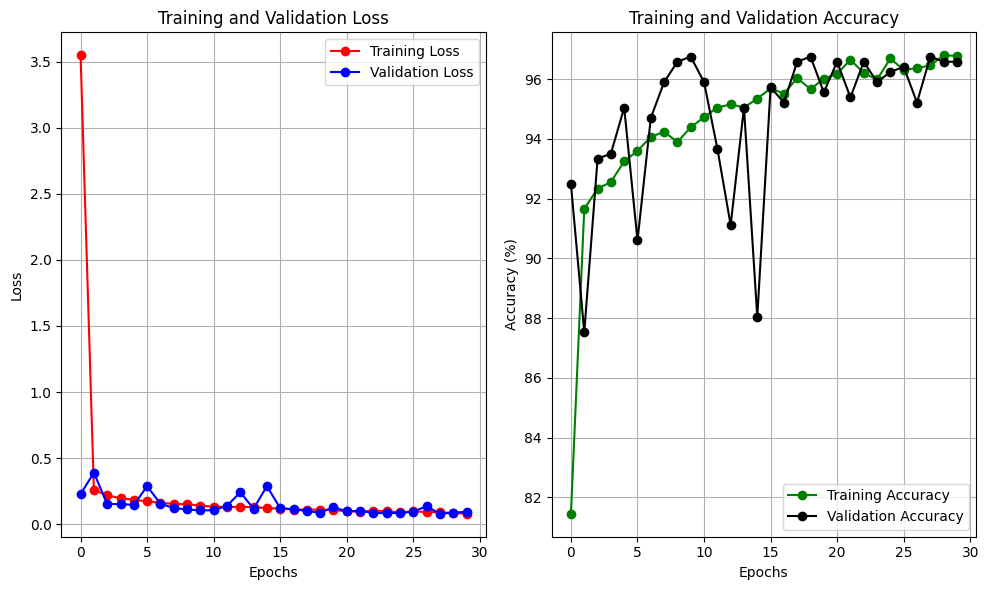

Model saved


FinalModelNoLRscheduler(
  (conv_relu_pool_stack): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Dropout(p=0.8, inplace=False)
    (10): Linear(in_features=50176, out_features=2, bias=True)
  )
)

In [ ]:
#run it on the normal test_improvements function and train_model function without learning rate scheduler

test_improvements(final_model_noLR, test_config, training_dataloader, validation_dataloader, testing_dataloader, device, "chest_xray_model_finalmodelNoLR")

**(a)**

Using the Cosine Annealing Learning Rate scheduler

**(b)**

_Present your results, including plots etc, here_

The summary metrices are given below, were 'vs. X' is the comparison to the final model results.

**Final model without batch normalization vs. Final model**

*   Validation accuracy: 96.6% (vs. 96.8%) & validation loss: 0.0938 (vs. 0.1315)
*   Validation normal class accuracy: 95.6% (vs. 92.4%)
*   Validation pneumonia class accuracy: 97.0% (vs. 98.4%)

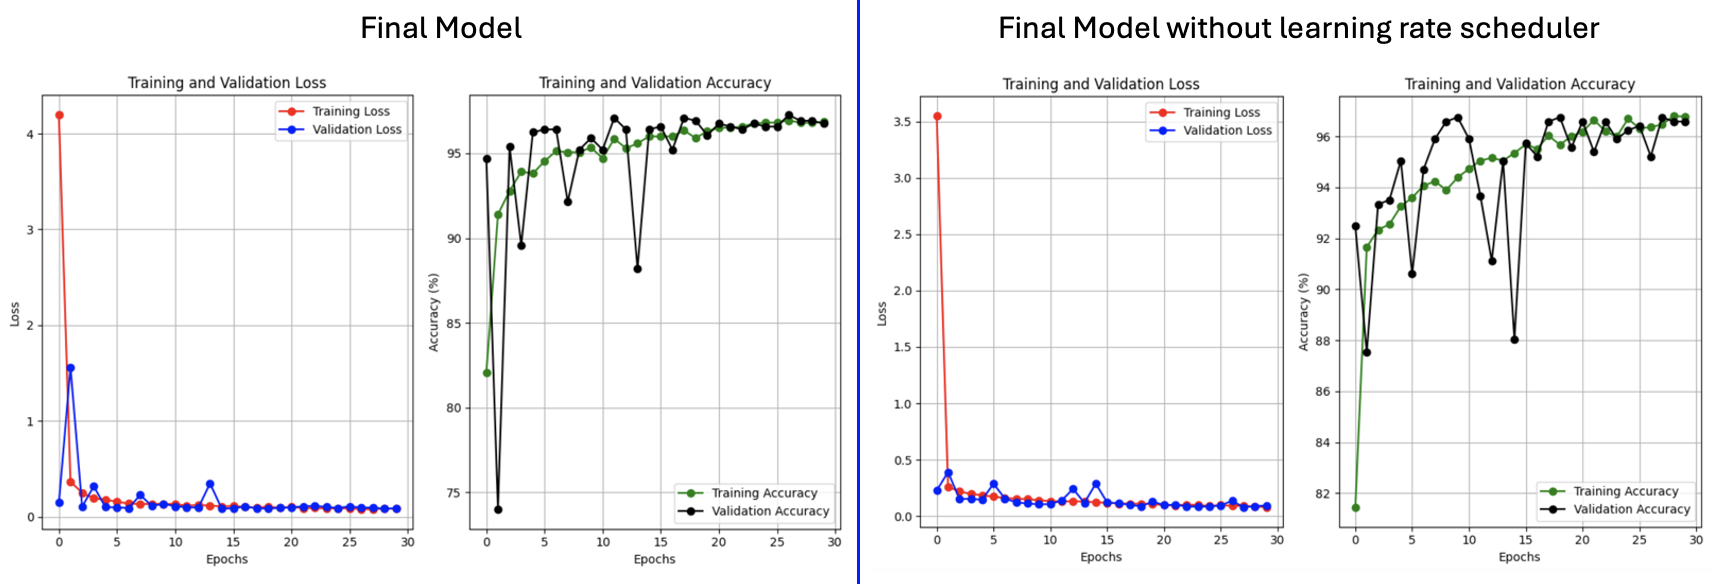

**Baseline + LR scheduler vs. Baseline**

*   Validation accuracy: 97.4% (vs. 95.6%) & validation loss: 0.0754 (vs. 0.1093)
*   Validation normal class accuracy: 92.4% (vs. 97.5%)
*   Validation pneumonia class accuracy: 99.3% (vs. 94.8%)

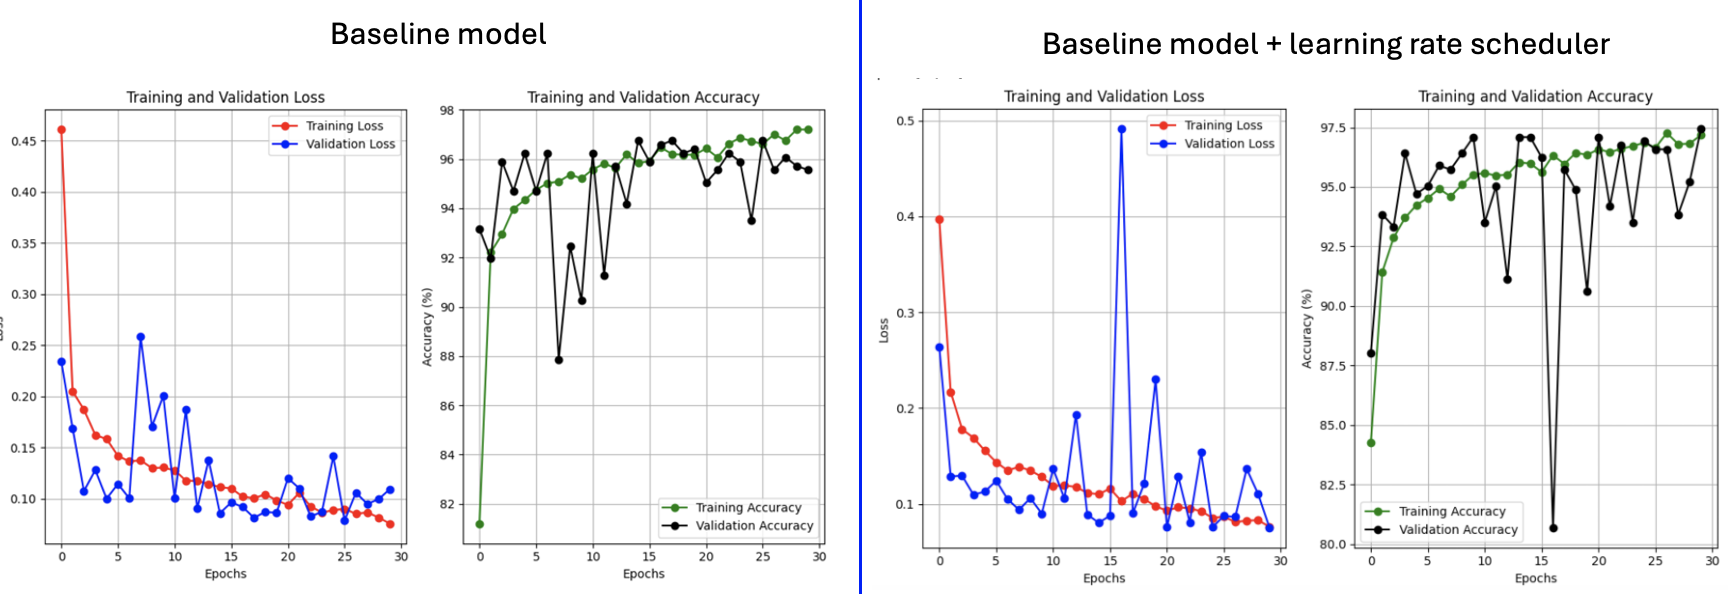

**(c)**

_Discuss your results here_

The learning rate scheduler was chosen to improve convergence, which is shown with the difference between final model & final moden without learning rate scheduler. However, our baseline does not seem to be converging more easily with just the learning rate scheduler. In the baseline case, the learning rate scheduler does improve the pneumonia class accuracy, overall accuracy and loss. Since this is not a really stable learning process it is not reliable.

In this case, the empirical proof for choosing the cosine annealing learning rate scheduler is only in the convergence of our final model.

# Question 5: Final Evaluation (10 marks)

You should perform a final evaluation of the performance of your model


In [ ]:
# Implement evaluation here

def test_model(model, test_loader, config=default_config, device='cuda', use_wandb=True):
    """
    To test our model on unseen data
    """

    model.eval()

    all_outputs = []
    all_labels = []

    loss_tracker_test = 0.0
    prediction_tracker_test = 0
    number_samples_test = 0

    loss_function = config['loss_function']

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Validating", unit="batch"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            test_loss = loss_function(outputs, labels)
            loss_tracker_test += test_loss.item()

            all_outputs.append(outputs)
            all_labels.append(labels)

            _, predicted_test = torch.max(outputs, 1)
            prediction_tracker_test += (predicted_test == labels).sum().item()
            number_samples_test += labels.size(0)

    test_loss_avg = loss_tracker_test / len(test_loader)
    test_accuracy = prediction_tracker_test / number_samples_test * 100

    #concatenate all output tensors
    all_outputs = torch.cat(all_outputs)
    all_labels = torch.cat(all_labels)

    test_class_accuracy = calculate_class_accuracy(all_outputs, all_labels)
    accuracy_normal, accuracy_pneumonia = test_class_accuracy

    print(f"Test Loss: {test_loss_avg:.4f}, Test Accuracy: {test_accuracy:.2f}% - "
      f"Normal Class Accuracy: {accuracy_normal:.2f}%, Pneumonia Class Accuracy: {accuracy_pneumonia:.2f}%")

    return test_loss_avg, test_accuracy, test_class_accuracy, all_outputs, all_labels

In [ ]:
test_loss, test_accuracies, test_class_accuracies, predicted_labels, true_labels = test_model(
     final_model_three_extra, testing_dataloader, test_config, device, use_wandb=True)

Validating: 100%|██████████| 10/10 [00:10<00:00,  1.02s/batch]

Test Loss: 0.1468, Test Accuracy: 95.40% - Normal Class Accuracy: 88.05%, Pneumonia Class Accuracy: 98.13%


In [ ]:
#present results

def present_results(true_labels, predicted_label, test_loss, test_accuracies, test_class_accuracies):
  """
  Presenting our results here, including:
  1. summary of basic numbers on our performance
  2. confusion matrix
  3. ROC curve
  4. Precision-recall curve
  """

  #needed for use of Numpy
  if isinstance(true_labels, torch.Tensor):
    true_labels = true_labels.cpu().numpy()

  if isinstance(predicted_label, torch.Tensor):
    probabilities = F.softmax(predicted_label, dim=1).cpu().numpy() #needed for roc/auc and use the raw output for this before turning it into labels
    predicted_label = torch.argmax(predicted_label, axis=1).cpu().numpy() #argmax because we have probabilities for each label

  #basics
  print(f"Test Loss: {test_loss:.4f} ")
  print(f"Test Accuracy: {test_accuracies:.2f}% ")
  normal_class_accuracy, pneumonia_class_accuracy = test_class_accuracies
  print(f"Test Normal Class Accuracy: {normal_class_accuracy:.2f}% & Test Pneumonia Class Accuracy: {pneumonia_class_accuracy:.2f}%")

  #consusion matrix
  confusion_matrix = metrics.confusion_matrix(true_labels, predicted_label)
  confusion_matrix_plot = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
  confusion_matrix_plot.plot(colorbar=False)
  plt.title("Confusion Matrix")
  plt.show()

  #roc/auc & precision recall
  positive_probs = probabilities[:, 1]

  fpr, tpr, _ = roc_curve(true_labels, positive_probs)
  roc_auc = auc(fpr, tpr)

  precision, recall, _ = precision_recall_curve(true_labels, positive_probs)
  average_precision = average_precision_score(true_labels, positive_probs)

  f1 = f1_score(true_labels, predicted_label)
  print(f"F1 score: {f1:.2f}")

  plt.figure(figsize=(12, 5))

  #roc/auc subplot
  plt.subplot(1, 2, 1)
  plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc="lower right")

  #precision recall subplot
  plt.subplot(1, 2, 2)
  plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AP = {average_precision:.2f})')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall (PR) Curve')
  plt.legend(loc="lower left")

  plt.tight_layout()
  plt.show()

**(a)**

_Present your results, including plots etc, here_

Test Loss: 0.1468 
Test Accuracy: 95.40% 
Test Normal Class Accuracy: 88.05% & Test Pneumonia Class Accuracy: 98.13%


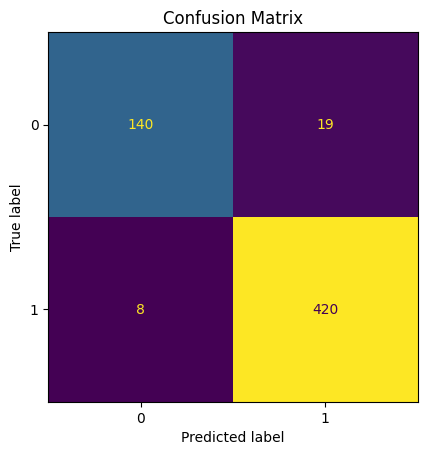

F1 score: 0.97


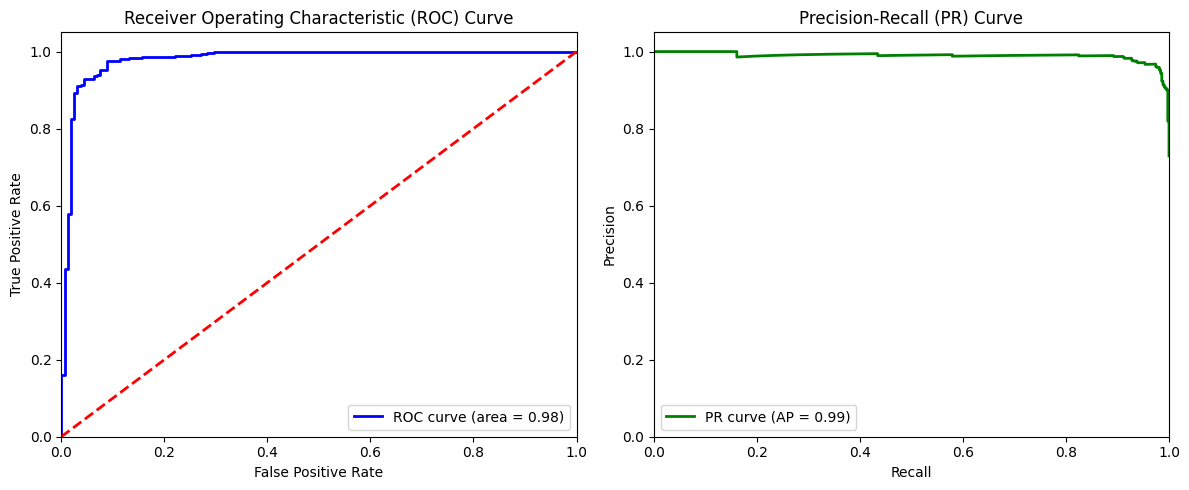

In [ ]:
present_results(true_labels, predicted_labels, test_loss, test_accuracies, test_class_accuracies)

**(b)**

_Discuss your results here_

The final evaluation of our model shows an accuracy of 95.4% on our test data, with a loss of 0.1468. Only 8 out of 420 pneumonia images were missed, which is a class accuracy of 98.13%. However, the normal class accuracy is only 88.05%. As noted before, this way is preferred since we are dealing with healthcare data and missing positives cases has a higher impact than missing negative cases.

The model has an F1 score of 0.97. This metric is particularly interesting for imbalanced datasets and represents the ratio between recall and precision. 0.97 is a high F1 score and gives more detailed information than just the test accuracy in an imbalanced dataset.

The ROC curve has an AUC of 0.98, which indicates that the model performs well in terms of classifying pneumonia and non-pneumonia cases. In addition, the precision recall curve has an average of 0.99. This indicates, again, that our final model is highly reliable in identifying pneumonia without compromising accuracy in terms of false alarms.

In conclusion, our final model performs well on unseen data and can classify X-Ray images with an accuracy of 95.4%.